In [1]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#data
import scipy.io as sio
from dataset import SURREALDataset, SittingDataset
from torch.utils.data import DataLoader

#pytorch
import torch
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
import torch.optim as optim
from torch.autograd import Variable

#models
from models import unet11

#train
from train import Trainer
from metrics import Soft_dice_loss

## SURREAL DATASET

In [2]:
dirr_train = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0'
dirr_test = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0'
dirr_val = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0'

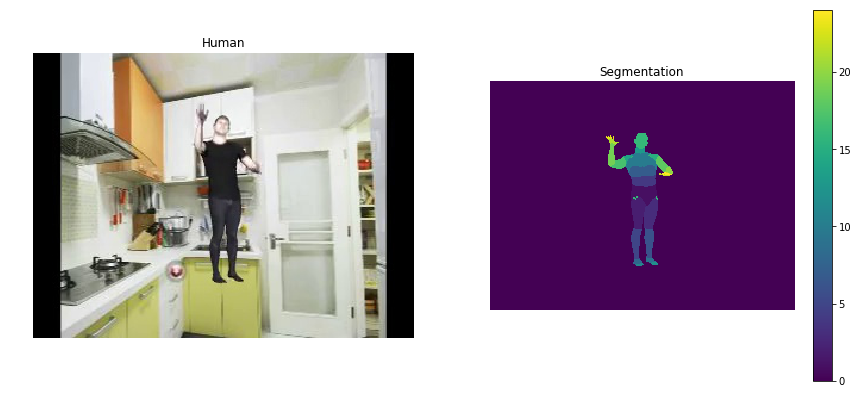

In [8]:
demonstrate_pic = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002frame1.jpg'
demonstrate_map = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002_segm.mat')['segm_1']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(demonstrate_pic))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_map)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [30]:
def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(5*col,5*row))
    for i in range(0, col*row):
        fig.add_subplot(row, col, i + 1)
        if i < len(imgs):
            plt.imshow(imgs[i])
            plt.title('Class ' + str(i+1))
        plt.axis("off")
        
def binarize_classes(classes, num):
    classes_bin = np.zeros((num, classes.shape[0], classes.shape[1]))
    for i in range(len(classes)):
        row = classes[i]
        for j in range(len(row)):
            classes_bin[int(row[j]), i, j] = 1.0
            
    return classes_bin

In [5]:
demonstrate_classes = binarize_classes(demonstrate_map, 25)

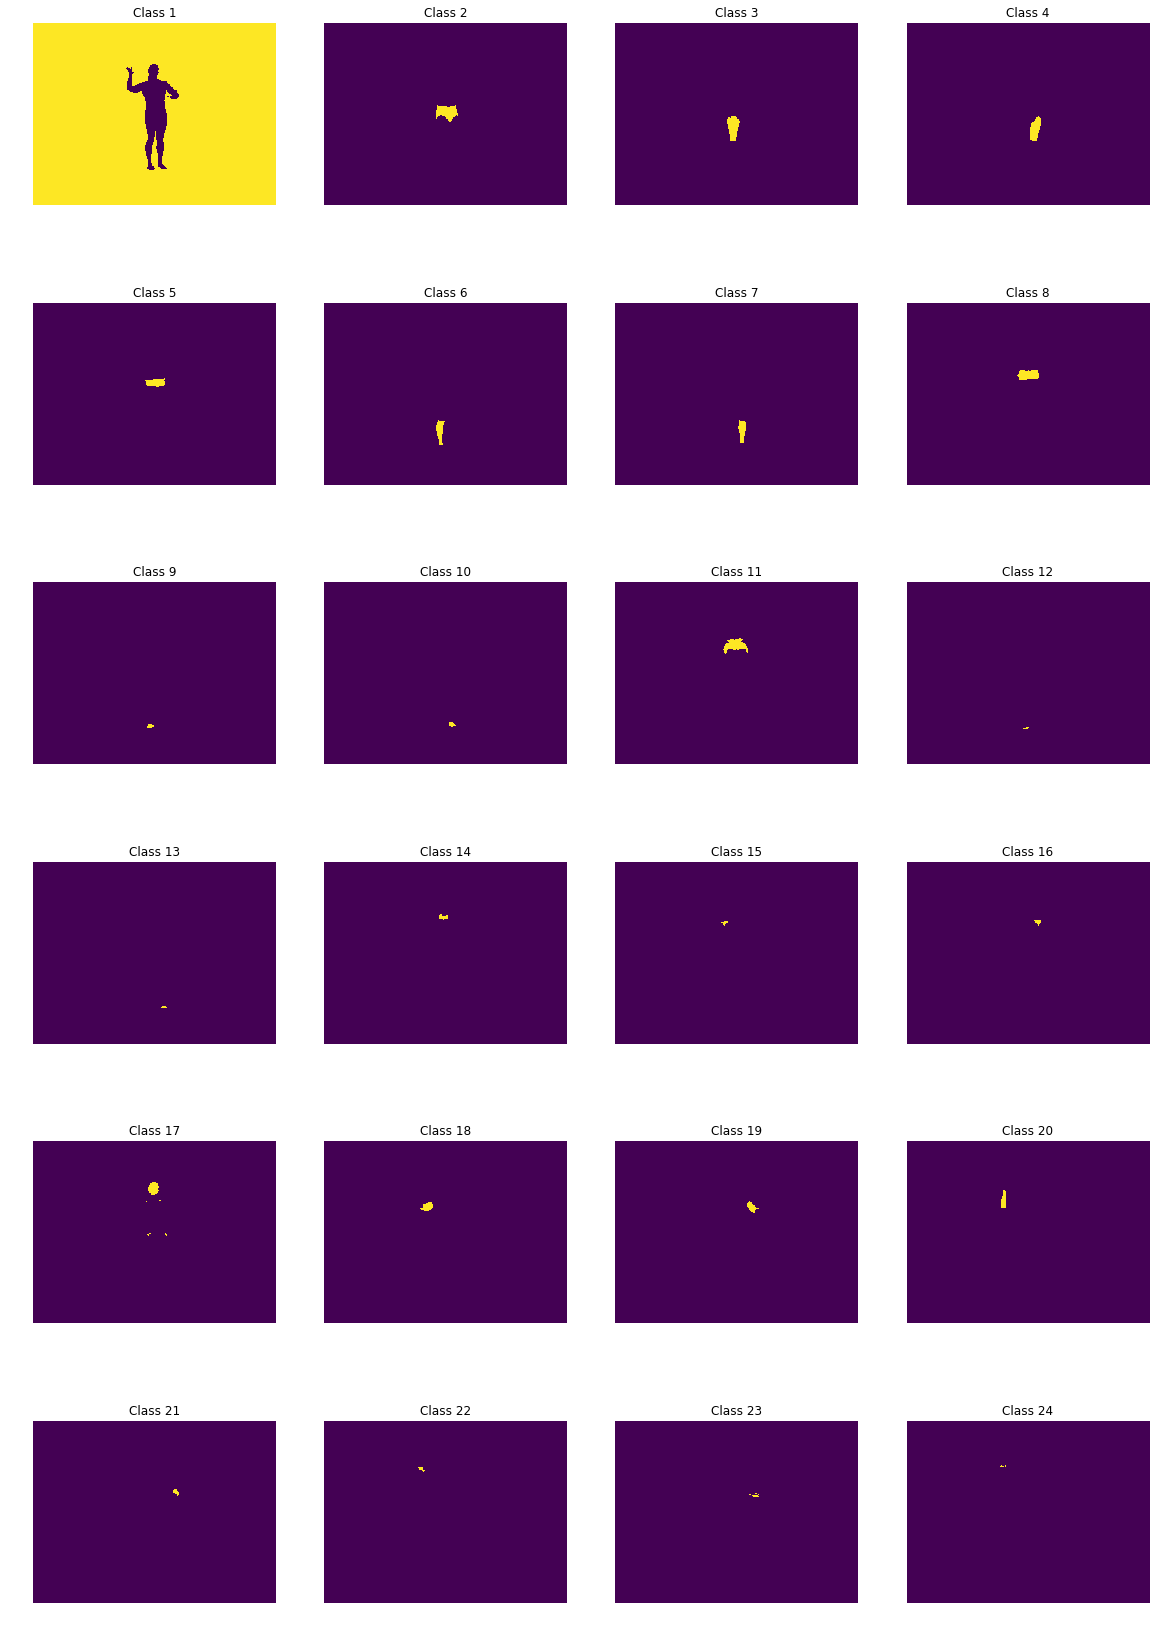

In [6]:
show_pics(demonstrate_classes, 4, 6)

## SITTING PEOPLE DATASET

In [3]:
sitting_dirr = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img'

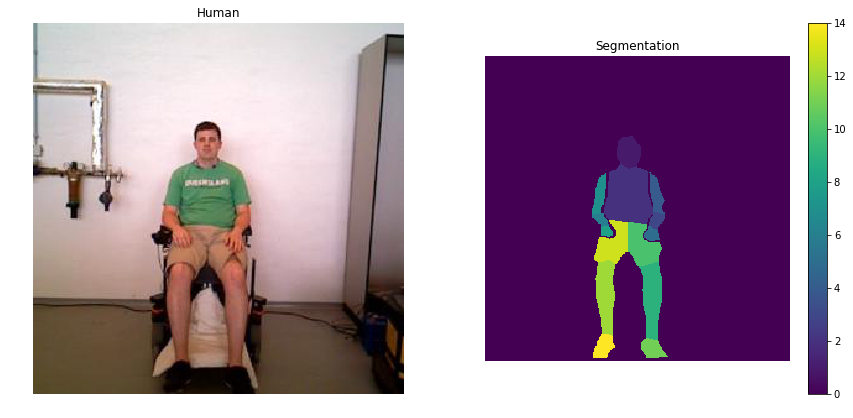

In [8]:
demonstrate_sit = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img/image90.jpg'
demonstrate_map_sit = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/masks/image90.mat')['M']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(demonstrate_sit))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_map_sit)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [9]:
demonstrate_classes_sit = binarize_classes(demonstrate_map_sit, 15)

### Re-structed segmentation maps

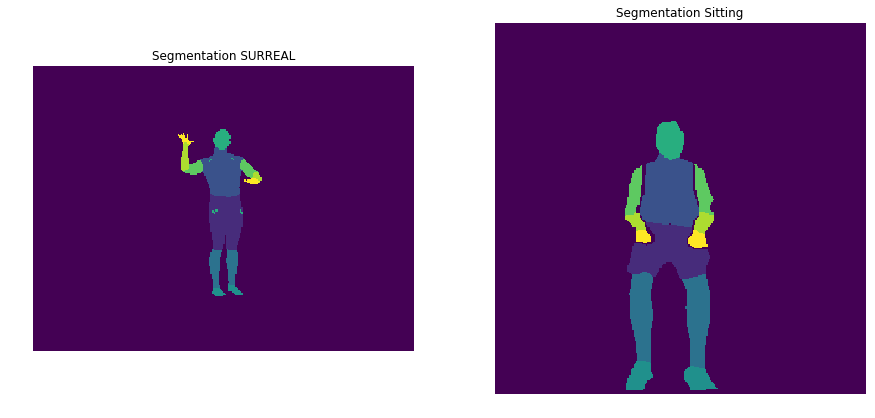

In [10]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow((demonstrate_classes[1] + demonstrate_classes[2] + demonstrate_classes[3]) +
          (demonstrate_classes[5] + demonstrate_classes[6])*3 +
          (demonstrate_classes[4] + demonstrate_classes[7] + demonstrate_classes[10] + demonstrate_classes[13] +demonstrate_classes[14] + demonstrate_classes[15])*2 +
          (demonstrate_classes[8] + demonstrate_classes[9] + demonstrate_classes[11] + demonstrate_classes[12])*4 +
           demonstrate_classes[16]*5 + (demonstrate_classes[17] + demonstrate_classes[18])*6 + 
          (demonstrate_classes[19] + demonstrate_classes[20])*7 +
          (demonstrate_classes[21] + demonstrate_classes[22] + demonstrate_classes[23] + demonstrate_classes[24])*8)

plt.title('Segmentation SURREAL')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_classes_sit[1]*5 + demonstrate_classes_sit[2]*2 + 
          (demonstrate_classes_sit[3] + demonstrate_classes_sit[6])*7 + 
          (demonstrate_classes_sit[4] + demonstrate_classes_sit[7])*6 +
          (demonstrate_classes_sit[5] + demonstrate_classes_sit[8])*8 +
          (demonstrate_classes_sit[9] + demonstrate_classes_sit[12])*3 + 
          (demonstrate_classes_sit[10] + demonstrate_classes_sit[13]) +
          (demonstrate_classes_sit[11] + demonstrate_classes_sit[14])*4)
plt.title('Segmentation Sitting')
plt.axis("off");

### SURREAL Dataset for pre-training.

In [54]:
transf = Compose([
    ToTensor()
])

dset_train = SURREALDataset(dirr_train, 9, transf, identifier='restructed', lengt=10000)
dset_test = SURREALDataset(dirr_test, 9, transf, identifier='restructed', lengt=10000)
dset_val = SURREALDataset(dirr_val, 9, transf, identifier='restructed', lengt=10000)

In [55]:
batch_sz = 4
train_loader = DataLoader(dset_train, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(dset_test, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=True)

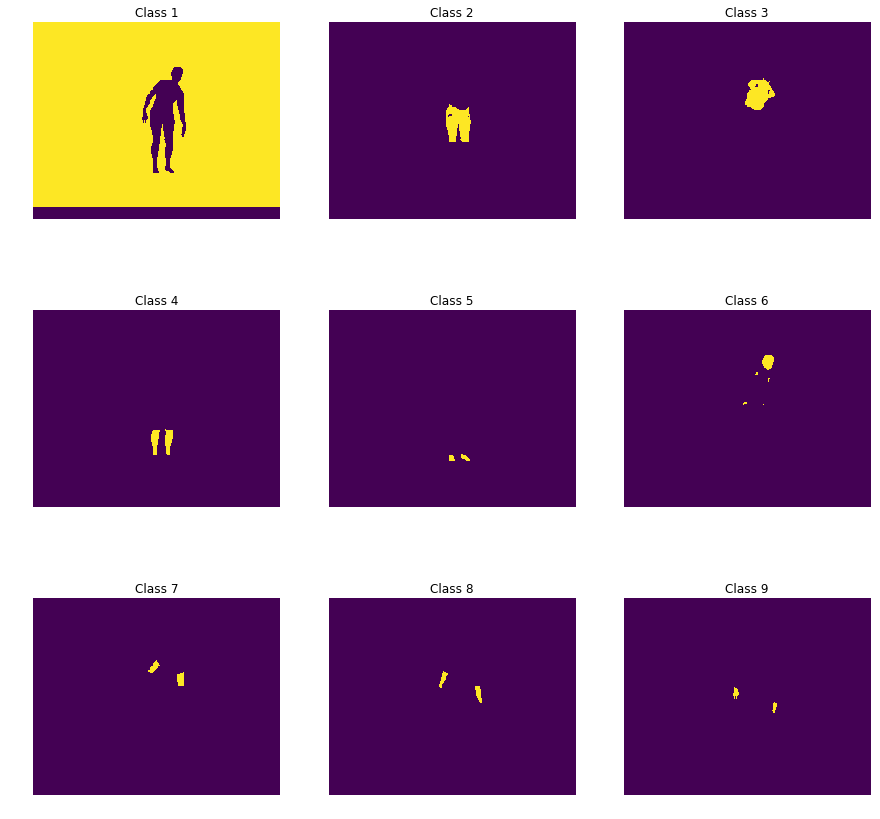

In [56]:
inputs_sur, classes_sur = next(iter(train_loader))
show_pics(classes_sur[0], 3, 3 )

### Sitting People Dataset.

In [57]:
dset_sitting = SittingDataset(sitting_dirr, 9, transf, identifier='restructed')
sitting_loader = DataLoader(dset_sitting, batch_size=batch_sz, shuffle=True)

In [58]:
inputs_sit, classes_sit = next(iter(sitting_loader))

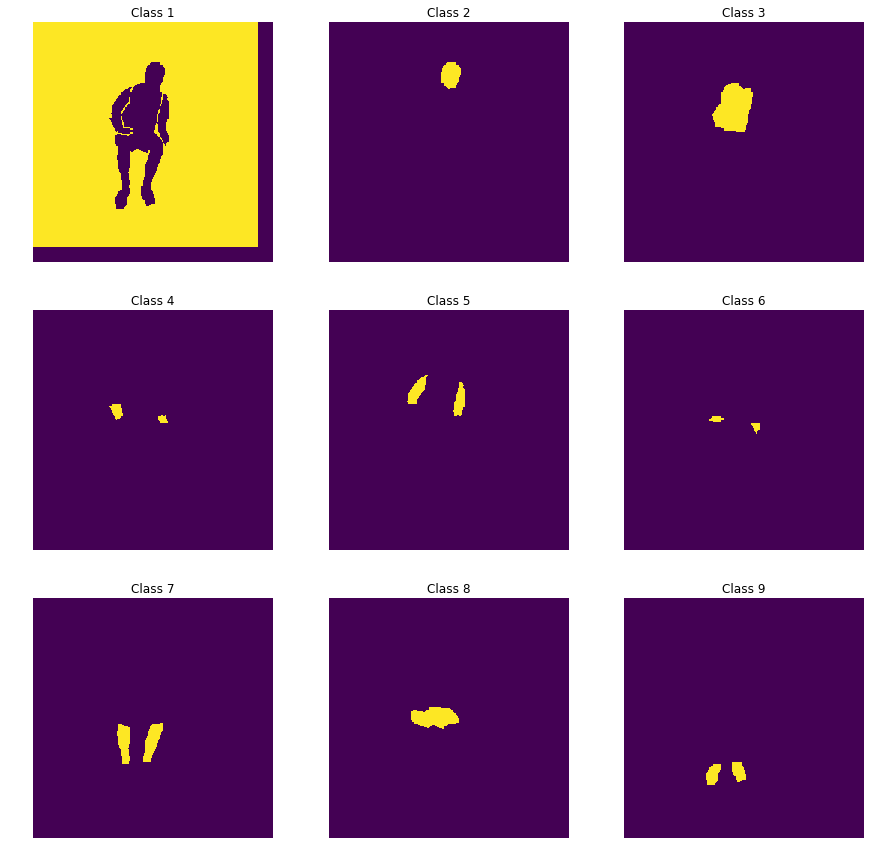

In [59]:
show_pics(classes_sit[0], 3, 3)

## TernausNet

In [5]:
num_classes = 9
num_epochs = 10
model = unet11(num_classes, 'carvana')

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.1
)

In [19]:
loss = Soft_dice_loss(smooth=1e-15)

In [20]:
train = Trainer(model, loss, train_loader, optimizer, num_epochs,
                save_dir='params/', save_freq=1, verbosity=2,
                gpu=torch.cuda.is_available(), identifier='ternaus', valid_data_loader=val_loader)

In [23]:
train.train()

Train Epoch: 1 [0/11952 (0%)] Loss: 0.109940355
Train Epoch: 1 [8/11952 (0%)] Loss: 0.109795146
Train Epoch: 1 [16/11952 (0%)] Loss: 0.108981182
Train Epoch: 1 [24/11952 (0%)] Loss: 0.109730842
Train Epoch: 1 [32/11952 (0%)] Loss: 0.110036795
Train Epoch: 1 [40/11952 (0%)] Loss: 0.110213661
Train Epoch: 1 [48/11952 (0%)] Loss: 0.110112209
Train Epoch: 1 [56/11952 (0%)] Loss: 0.110406440
Train Epoch: 1 [64/11952 (1%)] Loss: 0.110424173
Train Epoch: 1 [72/11952 (1%)] Loss: 0.109885518
Train Epoch: 1 [80/11952 (1%)] Loss: 0.109970011
Train Epoch: 1 [88/11952 (1%)] Loss: 0.108897637
Train Epoch: 1 [96/11952 (1%)] Loss: 0.110256317
Train Epoch: 1 [104/11952 (1%)] Loss: 0.109509245
Train Epoch: 1 [112/11952 (1%)] Loss: 0.109797066
Train Epoch: 1 [120/11952 (1%)] Loss: 0.109634666
Train Epoch: 1 [128/11952 (1%)] Loss: 0.110121899
Train Epoch: 1 [136/11952 (1%)] Loss: 0.109626738
Train Epoch: 1 [144/11952 (1%)] Loss: 0.109270589
Train Epoch: 1 [152/11952 (1%)] Loss: 0.109980261
Train Epoch: 1 

Train Epoch: 1 [1304/11952 (11%)] Loss: 0.094319166
Train Epoch: 1 [1312/11952 (11%)] Loss: 0.094179578
Train Epoch: 1 [1320/11952 (11%)] Loss: 0.092769390
Train Epoch: 1 [1328/11952 (11%)] Loss: 0.094584545
Train Epoch: 1 [1336/11952 (11%)] Loss: 0.093916325
Train Epoch: 1 [1344/11952 (11%)] Loss: 0.095033328
Train Epoch: 1 [1352/11952 (11%)] Loss: 0.094363455
Train Epoch: 1 [1360/11952 (11%)] Loss: 0.094347972
Train Epoch: 1 [1368/11952 (11%)] Loss: 0.092976812
Train Epoch: 1 [1376/11952 (12%)] Loss: 0.094000174
Train Epoch: 1 [1384/11952 (12%)] Loss: 0.095716753
Train Epoch: 1 [1392/11952 (12%)] Loss: 0.093523883
Train Epoch: 1 [1400/11952 (12%)] Loss: 0.095089783
Train Epoch: 1 [1408/11952 (12%)] Loss: 0.093971326
Train Epoch: 1 [1416/11952 (12%)] Loss: 0.094837277
Train Epoch: 1 [1424/11952 (12%)] Loss: 0.093393034
Train Epoch: 1 [1432/11952 (12%)] Loss: 0.093805902
Train Epoch: 1 [1440/11952 (12%)] Loss: 0.094558020
Train Epoch: 1 [1448/11952 (12%)] Loss: 0.096431323
Train Epoch:

Train Epoch: 1 [2568/11952 (21%)] Loss: 0.094252951
Train Epoch: 1 [2576/11952 (22%)] Loss: 0.095937269
Train Epoch: 1 [2584/11952 (22%)] Loss: 0.093332242
Train Epoch: 1 [2592/11952 (22%)] Loss: 0.095456905
Train Epoch: 1 [2600/11952 (22%)] Loss: 0.096631730
Train Epoch: 1 [2608/11952 (22%)] Loss: 0.095435311
Train Epoch: 1 [2616/11952 (22%)] Loss: 0.093630192
Train Epoch: 1 [2624/11952 (22%)] Loss: 0.095912659
Train Epoch: 1 [2632/11952 (22%)] Loss: 0.095622478
Train Epoch: 1 [2640/11952 (22%)] Loss: 0.094968155
Train Epoch: 1 [2648/11952 (22%)] Loss: 0.092879765
Train Epoch: 1 [2656/11952 (22%)] Loss: 0.093439458
Train Epoch: 1 [2664/11952 (22%)] Loss: 0.096893657
Train Epoch: 1 [2672/11952 (22%)] Loss: 0.094437071
Train Epoch: 1 [2680/11952 (22%)] Loss: 0.092758950
Train Epoch: 1 [2688/11952 (22%)] Loss: 0.095259965
Train Epoch: 1 [2696/11952 (23%)] Loss: 0.095398845
Train Epoch: 1 [2704/11952 (23%)] Loss: 0.095195999
Train Epoch: 1 [2712/11952 (23%)] Loss: 0.093814156
Train Epoch:

Train Epoch: 1 [3832/11952 (32%)] Loss: 0.088958562
Train Epoch: 1 [3840/11952 (32%)] Loss: 0.092567118
Train Epoch: 1 [3848/11952 (32%)] Loss: 0.091168039
Train Epoch: 1 [3856/11952 (32%)] Loss: 0.088741100
Train Epoch: 1 [3864/11952 (32%)] Loss: 0.090897102
Train Epoch: 1 [3872/11952 (32%)] Loss: 0.089070540
Train Epoch: 1 [3880/11952 (32%)] Loss: 0.089380706
Train Epoch: 1 [3888/11952 (33%)] Loss: 0.089204576
Train Epoch: 1 [3896/11952 (33%)] Loss: 0.089337745
Train Epoch: 1 [3904/11952 (33%)] Loss: 0.088580459
Train Epoch: 1 [3912/11952 (33%)] Loss: 0.086455481
Train Epoch: 1 [3920/11952 (33%)] Loss: 0.087246638
Train Epoch: 1 [3928/11952 (33%)] Loss: 0.089879205
Train Epoch: 1 [3936/11952 (33%)] Loss: 0.088904106
Train Epoch: 1 [3944/11952 (33%)] Loss: 0.087515037
Train Epoch: 1 [3952/11952 (33%)] Loss: 0.087653188
Train Epoch: 1 [3960/11952 (33%)] Loss: 0.087080339
Train Epoch: 1 [3968/11952 (33%)] Loss: 0.086577966
Train Epoch: 1 [3976/11952 (33%)] Loss: 0.086742936
Train Epoch:

Train Epoch: 1 [5096/11952 (43%)] Loss: 0.088297146
Train Epoch: 1 [5104/11952 (43%)] Loss: 0.088346927
Train Epoch: 1 [5112/11952 (43%)] Loss: 0.087275454
Train Epoch: 1 [5120/11952 (43%)] Loss: 0.087939365
Train Epoch: 1 [5128/11952 (43%)] Loss: 0.088771501
Train Epoch: 1 [5136/11952 (43%)] Loss: 0.089835924
Train Epoch: 1 [5144/11952 (43%)] Loss: 0.087192137
Train Epoch: 1 [5152/11952 (43%)] Loss: 0.088756080
Train Epoch: 1 [5160/11952 (43%)] Loss: 0.091500250
Train Epoch: 1 [5168/11952 (43%)] Loss: 0.089460465
Train Epoch: 1 [5176/11952 (43%)] Loss: 0.093472950
Train Epoch: 1 [5184/11952 (43%)] Loss: 0.091437230
Train Epoch: 1 [5192/11952 (43%)] Loss: 0.094226063
Train Epoch: 1 [5200/11952 (44%)] Loss: 0.091137209
Train Epoch: 1 [5208/11952 (44%)] Loss: 0.089099111
Train Epoch: 1 [5216/11952 (44%)] Loss: 0.091500816
Train Epoch: 1 [5224/11952 (44%)] Loss: 0.088910641
Train Epoch: 1 [5232/11952 (44%)] Loss: 0.088414718
Train Epoch: 1 [5240/11952 (44%)] Loss: 0.086593731
Train Epoch:

Train Epoch: 1 [6360/11952 (53%)] Loss: 0.080666938
Train Epoch: 1 [6368/11952 (53%)] Loss: 0.081556573
Train Epoch: 1 [6376/11952 (53%)] Loss: 0.079221729
Train Epoch: 1 [6384/11952 (53%)] Loss: 0.078551509
Train Epoch: 1 [6392/11952 (53%)] Loss: 0.082396225
Train Epoch: 1 [6400/11952 (54%)] Loss: 0.078891740
Train Epoch: 1 [6408/11952 (54%)] Loss: 0.081380919
Train Epoch: 1 [6416/11952 (54%)] Loss: 0.080492487
Train Epoch: 1 [6424/11952 (54%)] Loss: 0.079655875
Train Epoch: 1 [6432/11952 (54%)] Loss: 0.081770727
Train Epoch: 1 [6440/11952 (54%)] Loss: 0.079893779
Train Epoch: 1 [6448/11952 (54%)] Loss: 0.078737742
Train Epoch: 1 [6456/11952 (54%)] Loss: 0.081227585
Train Epoch: 1 [6464/11952 (54%)] Loss: 0.078237147
Train Epoch: 1 [6472/11952 (54%)] Loss: 0.077389323
Train Epoch: 1 [6480/11952 (54%)] Loss: 0.078275623
Train Epoch: 1 [6488/11952 (54%)] Loss: 0.080126177
Train Epoch: 1 [6496/11952 (54%)] Loss: 0.078522061
Train Epoch: 1 [6504/11952 (54%)] Loss: 0.079335277
Train Epoch:

Train Epoch: 1 [7624/11952 (64%)] Loss: 0.079547168
Train Epoch: 1 [7632/11952 (64%)] Loss: 0.075094393
Train Epoch: 1 [7640/11952 (64%)] Loss: 0.078201258
Train Epoch: 1 [7648/11952 (64%)] Loss: 0.079054887
Train Epoch: 1 [7656/11952 (64%)] Loss: 0.078134766
Train Epoch: 1 [7664/11952 (64%)] Loss: 0.075278195
Train Epoch: 1 [7672/11952 (64%)] Loss: 0.075454669
Train Epoch: 1 [7680/11952 (64%)] Loss: 0.075769834
Train Epoch: 1 [7688/11952 (64%)] Loss: 0.075918659
Train Epoch: 1 [7696/11952 (64%)] Loss: 0.073310491
Train Epoch: 1 [7704/11952 (64%)] Loss: 0.073919186
Train Epoch: 1 [7712/11952 (65%)] Loss: 0.076035039
Train Epoch: 1 [7720/11952 (65%)] Loss: 0.073855560
Train Epoch: 1 [7728/11952 (65%)] Loss: 0.073479806
Train Epoch: 1 [7736/11952 (65%)] Loss: 0.074092394
Train Epoch: 1 [7744/11952 (65%)] Loss: 0.075549535
Train Epoch: 1 [7752/11952 (65%)] Loss: 0.076398083
Train Epoch: 1 [7760/11952 (65%)] Loss: 0.073511211
Train Epoch: 1 [7768/11952 (65%)] Loss: 0.075352003
Train Epoch:

Train Epoch: 1 [8888/11952 (74%)] Loss: 0.074002009
Train Epoch: 1 [8896/11952 (74%)] Loss: 0.075270162
Train Epoch: 1 [8904/11952 (74%)] Loss: 0.077884397
Train Epoch: 1 [8912/11952 (75%)] Loss: 0.073762778
Train Epoch: 1 [8920/11952 (75%)] Loss: 0.072853645
Train Epoch: 1 [8928/11952 (75%)] Loss: 0.075095988
Train Epoch: 1 [8936/11952 (75%)] Loss: 0.076298891
Train Epoch: 1 [8944/11952 (75%)] Loss: 0.076495777
Train Epoch: 1 [8952/11952 (75%)] Loss: 0.075703627
Train Epoch: 1 [8960/11952 (75%)] Loss: 0.074952895
Train Epoch: 1 [8968/11952 (75%)] Loss: 0.072273526
Train Epoch: 1 [8976/11952 (75%)] Loss: 0.073304381
Train Epoch: 1 [8984/11952 (75%)] Loss: 0.072139829
Train Epoch: 1 [8992/11952 (75%)] Loss: 0.075092363
Train Epoch: 1 [9000/11952 (75%)] Loss: 0.074032422
Train Epoch: 1 [9008/11952 (75%)] Loss: 0.074716565
Train Epoch: 1 [9016/11952 (75%)] Loss: 0.072708861
Train Epoch: 1 [9024/11952 (76%)] Loss: 0.073384969
Train Epoch: 1 [9032/11952 (76%)] Loss: 0.077348519
Train Epoch:

Train Epoch: 1 [10152/11952 (85%)] Loss: 0.083884717
Train Epoch: 1 [10160/11952 (85%)] Loss: 0.076938557
Train Epoch: 1 [10168/11952 (85%)] Loss: 0.087997401
Train Epoch: 1 [10176/11952 (85%)] Loss: 0.085735068
Train Epoch: 1 [10184/11952 (85%)] Loss: 0.079873095
Train Epoch: 1 [10192/11952 (85%)] Loss: 0.078649943
Train Epoch: 1 [10200/11952 (85%)] Loss: 0.076345515
Train Epoch: 1 [10208/11952 (85%)] Loss: 0.075443741
Train Epoch: 1 [10216/11952 (85%)] Loss: 0.080531959
Train Epoch: 1 [10224/11952 (86%)] Loss: 0.079055860
Train Epoch: 1 [10232/11952 (86%)] Loss: 0.077069024
Train Epoch: 1 [10240/11952 (86%)] Loss: 0.083974596
Train Epoch: 1 [10248/11952 (86%)] Loss: 0.079457278
Train Epoch: 1 [10256/11952 (86%)] Loss: 0.078324647
Train Epoch: 1 [10264/11952 (86%)] Loss: 0.077664939
Train Epoch: 1 [10272/11952 (86%)] Loss: 0.080010819
Train Epoch: 1 [10280/11952 (86%)] Loss: 0.077278288
Train Epoch: 1 [10288/11952 (86%)] Loss: 0.083770222
Train Epoch: 1 [10296/11952 (86%)] Loss: 0.081

Train Epoch: 1 [11392/11952 (95%)] Loss: 0.080789161
Train Epoch: 1 [11400/11952 (95%)] Loss: 0.078205384
Train Epoch: 1 [11408/11952 (95%)] Loss: 0.077663796
Train Epoch: 1 [11416/11952 (96%)] Loss: 0.070911111
Train Epoch: 1 [11424/11952 (96%)] Loss: 0.074315669
Train Epoch: 1 [11432/11952 (96%)] Loss: 0.078957991
Train Epoch: 1 [11440/11952 (96%)] Loss: 0.075643505
Train Epoch: 1 [11448/11952 (96%)] Loss: 0.078045719
Train Epoch: 1 [11456/11952 (96%)] Loss: 0.074029495
Train Epoch: 1 [11464/11952 (96%)] Loss: 0.082035973
Train Epoch: 1 [11472/11952 (96%)] Loss: 0.078221835
Train Epoch: 1 [11480/11952 (96%)] Loss: 0.077064903
Train Epoch: 1 [11488/11952 (96%)] Loss: 0.074806608
Train Epoch: 1 [11496/11952 (96%)] Loss: 0.080158996
Train Epoch: 1 [11504/11952 (96%)] Loss: 0.077047962
Train Epoch: 1 [11512/11952 (96%)] Loss: 0.084592593
Train Epoch: 1 [11520/11952 (96%)] Loss: 0.079534598
Train Epoch: 1 [11528/11952 (96%)] Loss: 0.074150495
Train Epoch: 1 [11536/11952 (97%)] Loss: 0.079

Train Epoch: 2 [704/11952 (6%)] Loss: 0.080483679
Train Epoch: 2 [712/11952 (6%)] Loss: 0.075822001
Train Epoch: 2 [720/11952 (6%)] Loss: 0.077553534
Train Epoch: 2 [728/11952 (6%)] Loss: 0.073341153
Train Epoch: 2 [736/11952 (6%)] Loss: 0.073552809
Train Epoch: 2 [744/11952 (6%)] Loss: 0.078575280
Train Epoch: 2 [752/11952 (6%)] Loss: 0.073755652
Train Epoch: 2 [760/11952 (6%)] Loss: 0.073852431
Train Epoch: 2 [768/11952 (6%)] Loss: 0.077987449
Train Epoch: 2 [776/11952 (6%)] Loss: 0.075980047
Train Epoch: 2 [784/11952 (7%)] Loss: 0.075901097
Train Epoch: 2 [792/11952 (7%)] Loss: 0.073008729
Train Epoch: 2 [800/11952 (7%)] Loss: 0.073008796
Train Epoch: 2 [808/11952 (7%)] Loss: 0.074631468
Train Epoch: 2 [816/11952 (7%)] Loss: 0.075526892
Train Epoch: 2 [824/11952 (7%)] Loss: 0.074306097
Train Epoch: 2 [832/11952 (7%)] Loss: 0.077670731
Train Epoch: 2 [840/11952 (7%)] Loss: 0.075999234
Train Epoch: 2 [848/11952 (7%)] Loss: 0.073752772
Train Epoch: 2 [856/11952 (7%)] Loss: 0.073107019


Train Epoch: 2 [1984/11952 (17%)] Loss: 0.069821937
Train Epoch: 2 [1992/11952 (17%)] Loss: 0.067649638
Train Epoch: 2 [2000/11952 (17%)] Loss: 0.069713907
Train Epoch: 2 [2008/11952 (17%)] Loss: 0.069099020
Train Epoch: 2 [2016/11952 (17%)] Loss: 0.068421903
Train Epoch: 2 [2024/11952 (17%)] Loss: 0.067825432
Train Epoch: 2 [2032/11952 (17%)] Loss: 0.067656368
Train Epoch: 2 [2040/11952 (17%)] Loss: 0.068090148
Train Epoch: 2 [2048/11952 (17%)] Loss: 0.066970334
Train Epoch: 2 [2056/11952 (17%)] Loss: 0.067414591
Train Epoch: 2 [2064/11952 (17%)] Loss: 0.066687908
Train Epoch: 2 [2072/11952 (17%)] Loss: 0.068241607
Train Epoch: 2 [2080/11952 (17%)] Loss: 0.071129069
Train Epoch: 2 [2088/11952 (17%)] Loss: 0.067874667
Train Epoch: 2 [2096/11952 (18%)] Loss: 0.071414158
Train Epoch: 2 [2104/11952 (18%)] Loss: 0.068201852
Train Epoch: 2 [2112/11952 (18%)] Loss: 0.068223102
Train Epoch: 2 [2120/11952 (18%)] Loss: 0.067271488
Train Epoch: 2 [2128/11952 (18%)] Loss: 0.067601042
Train Epoch:

Train Epoch: 2 [3248/11952 (27%)] Loss: 0.075647387
Train Epoch: 2 [3256/11952 (27%)] Loss: 0.072402727
Train Epoch: 2 [3264/11952 (27%)] Loss: 0.075904757
Train Epoch: 2 [3272/11952 (27%)] Loss: 0.070590224
Train Epoch: 2 [3280/11952 (27%)] Loss: 0.079462828
Train Epoch: 2 [3288/11952 (28%)] Loss: 0.077976604
Train Epoch: 2 [3296/11952 (28%)] Loss: 0.073120165
Train Epoch: 2 [3304/11952 (28%)] Loss: 0.076362415
Train Epoch: 2 [3312/11952 (28%)] Loss: 0.070356937
Train Epoch: 2 [3320/11952 (28%)] Loss: 0.071882780
Train Epoch: 2 [3328/11952 (28%)] Loss: 0.074281703
Train Epoch: 2 [3336/11952 (28%)] Loss: 0.075164762
Train Epoch: 2 [3344/11952 (28%)] Loss: 0.071568887
Train Epoch: 2 [3352/11952 (28%)] Loss: 0.073385570
Train Epoch: 2 [3360/11952 (28%)] Loss: 0.072604740
Train Epoch: 2 [3368/11952 (28%)] Loss: 0.071633103
Train Epoch: 2 [3376/11952 (28%)] Loss: 0.070888097
Train Epoch: 2 [3384/11952 (28%)] Loss: 0.071897264
Train Epoch: 2 [3392/11952 (28%)] Loss: 0.071365397
Train Epoch:

Train Epoch: 2 [4512/11952 (38%)] Loss: 0.069741867
Train Epoch: 2 [4520/11952 (38%)] Loss: 0.068839128
Train Epoch: 2 [4528/11952 (38%)] Loss: 0.070052089
Train Epoch: 2 [4536/11952 (38%)] Loss: 0.070588498
Train Epoch: 2 [4544/11952 (38%)] Loss: 0.070240767
Train Epoch: 2 [4552/11952 (38%)] Loss: 0.071872105
Train Epoch: 2 [4560/11952 (38%)] Loss: 0.072154149
Train Epoch: 2 [4568/11952 (38%)] Loss: 0.072530015
Train Epoch: 2 [4576/11952 (38%)] Loss: 0.067257587
Train Epoch: 2 [4584/11952 (38%)] Loss: 0.068355254
Train Epoch: 2 [4592/11952 (38%)] Loss: 0.067477042
Train Epoch: 2 [4600/11952 (38%)] Loss: 0.069378503
Train Epoch: 2 [4608/11952 (39%)] Loss: 0.065899280
Train Epoch: 2 [4616/11952 (39%)] Loss: 0.065970800
Train Epoch: 2 [4624/11952 (39%)] Loss: 0.068512704
Train Epoch: 2 [4632/11952 (39%)] Loss: 0.065836848
Train Epoch: 2 [4640/11952 (39%)] Loss: 0.063612471
Train Epoch: 2 [4648/11952 (39%)] Loss: 0.064620795
Train Epoch: 2 [4656/11952 (39%)] Loss: 0.064019711
Train Epoch:

Train Epoch: 2 [5776/11952 (48%)] Loss: 0.066625705
Train Epoch: 2 [5784/11952 (48%)] Loss: 0.067272305
Train Epoch: 2 [5792/11952 (48%)] Loss: 0.065557124
Train Epoch: 2 [5800/11952 (49%)] Loss: 0.068190175
Train Epoch: 2 [5808/11952 (49%)] Loss: 0.070351308
Train Epoch: 2 [5816/11952 (49%)] Loss: 0.068095796
Train Epoch: 2 [5824/11952 (49%)] Loss: 0.066473844
Train Epoch: 2 [5832/11952 (49%)] Loss: 0.065818986
Train Epoch: 2 [5840/11952 (49%)] Loss: 0.064898216
Train Epoch: 2 [5848/11952 (49%)] Loss: 0.066393038
Train Epoch: 2 [5856/11952 (49%)] Loss: 0.065890023
Train Epoch: 2 [5864/11952 (49%)] Loss: 0.065856148
Train Epoch: 2 [5872/11952 (49%)] Loss: 0.065047353
Train Epoch: 2 [5880/11952 (49%)] Loss: 0.066652822
Train Epoch: 2 [5888/11952 (49%)] Loss: 0.074112447
Train Epoch: 2 [5896/11952 (49%)] Loss: 0.069347799
Train Epoch: 2 [5904/11952 (49%)] Loss: 0.069071332
Train Epoch: 2 [5912/11952 (49%)] Loss: 0.067140654
Train Epoch: 2 [5920/11952 (50%)] Loss: 0.068738966
Train Epoch:

Train Epoch: 2 [7040/11952 (59%)] Loss: 0.060967500
Train Epoch: 2 [7048/11952 (59%)] Loss: 0.061220084
Train Epoch: 2 [7056/11952 (59%)] Loss: 0.059680030
Train Epoch: 2 [7064/11952 (59%)] Loss: 0.060225095
Train Epoch: 2 [7072/11952 (59%)] Loss: 0.066922085
Train Epoch: 2 [7080/11952 (59%)] Loss: 0.069010803
Train Epoch: 2 [7088/11952 (59%)] Loss: 0.063541183
Train Epoch: 2 [7096/11952 (59%)] Loss: 0.063386502
Train Epoch: 2 [7104/11952 (59%)] Loss: 0.068569255
Train Epoch: 2 [7112/11952 (60%)] Loss: 0.059076118
Train Epoch: 2 [7120/11952 (60%)] Loss: 0.064488609
Train Epoch: 2 [7128/11952 (60%)] Loss: 0.064738673
Train Epoch: 2 [7136/11952 (60%)] Loss: 0.062739607
Train Epoch: 2 [7144/11952 (60%)] Loss: 0.069607993
Train Epoch: 2 [7152/11952 (60%)] Loss: 0.064931393
Train Epoch: 2 [7160/11952 (60%)] Loss: 0.066100953
Train Epoch: 2 [7168/11952 (60%)] Loss: 0.071879831
Train Epoch: 2 [7176/11952 (60%)] Loss: 0.063731448
Train Epoch: 2 [7184/11952 (60%)] Loss: 0.059670334
Train Epoch:

Train Epoch: 2 [8304/11952 (69%)] Loss: 0.060582126
Train Epoch: 2 [8312/11952 (70%)] Loss: 0.061959470
Train Epoch: 2 [8320/11952 (70%)] Loss: 0.061977121
Train Epoch: 2 [8328/11952 (70%)] Loss: 0.062413565
Train Epoch: 2 [8336/11952 (70%)] Loss: 0.061563401
Train Epoch: 2 [8344/11952 (70%)] Loss: 0.061500249
Train Epoch: 2 [8352/11952 (70%)] Loss: 0.059397033
Train Epoch: 2 [8360/11952 (70%)] Loss: 0.059135996
Train Epoch: 2 [8368/11952 (70%)] Loss: 0.064393290
Train Epoch: 2 [8376/11952 (70%)] Loss: 0.063625625
Train Epoch: 2 [8384/11952 (70%)] Loss: 0.063512420
Train Epoch: 2 [8392/11952 (70%)] Loss: 0.062731990
Train Epoch: 2 [8400/11952 (70%)] Loss: 0.063532309
Train Epoch: 2 [8408/11952 (70%)] Loss: 0.061580535
Train Epoch: 2 [8416/11952 (70%)] Loss: 0.061588273
Train Epoch: 2 [8424/11952 (70%)] Loss: 0.062356303
Train Epoch: 2 [8432/11952 (71%)] Loss: 0.059702915
Train Epoch: 2 [8440/11952 (71%)] Loss: 0.059505637
Train Epoch: 2 [8448/11952 (71%)] Loss: 0.061360075
Train Epoch:

Train Epoch: 2 [9568/11952 (80%)] Loss: 0.055624412
Train Epoch: 2 [9576/11952 (80%)] Loss: 0.060536653
Train Epoch: 2 [9584/11952 (80%)] Loss: 0.057273503
Train Epoch: 2 [9592/11952 (80%)] Loss: 0.058042119
Train Epoch: 2 [9600/11952 (80%)] Loss: 0.056075042
Train Epoch: 2 [9608/11952 (80%)] Loss: 0.057286904
Train Epoch: 2 [9616/11952 (80%)] Loss: 0.055532144
Train Epoch: 2 [9624/11952 (81%)] Loss: 0.055916986
Train Epoch: 2 [9632/11952 (81%)] Loss: 0.059001172
Train Epoch: 2 [9640/11952 (81%)] Loss: 0.058079015
Train Epoch: 2 [9648/11952 (81%)] Loss: 0.057471554
Train Epoch: 2 [9656/11952 (81%)] Loss: 0.058744736
Train Epoch: 2 [9664/11952 (81%)] Loss: 0.058041825
Train Epoch: 2 [9672/11952 (81%)] Loss: 0.056083753
Train Epoch: 2 [9680/11952 (81%)] Loss: 0.065764587
Train Epoch: 2 [9688/11952 (81%)] Loss: 0.058965203
Train Epoch: 2 [9696/11952 (81%)] Loss: 0.059529701
Train Epoch: 2 [9704/11952 (81%)] Loss: 0.057371644
Train Epoch: 2 [9712/11952 (81%)] Loss: 0.057969265
Train Epoch:

Train Epoch: 2 [10816/11952 (90%)] Loss: 0.066800634
Train Epoch: 2 [10824/11952 (91%)] Loss: 0.070331001
Train Epoch: 2 [10832/11952 (91%)] Loss: 0.074795747
Train Epoch: 2 [10840/11952 (91%)] Loss: 0.088798184
Train Epoch: 2 [10848/11952 (91%)] Loss: 0.072209551
Train Epoch: 2 [10856/11952 (91%)] Loss: 0.069096415
Train Epoch: 2 [10864/11952 (91%)] Loss: 0.073291034
Train Epoch: 2 [10872/11952 (91%)] Loss: 0.075277201
Train Epoch: 2 [10880/11952 (91%)] Loss: 0.074788140
Train Epoch: 2 [10888/11952 (91%)] Loss: 0.078219688
Train Epoch: 2 [10896/11952 (91%)] Loss: 0.067945345
Train Epoch: 2 [10904/11952 (91%)] Loss: 0.065583123
Train Epoch: 2 [10912/11952 (91%)] Loss: 0.062366009
Train Epoch: 2 [10920/11952 (91%)] Loss: 0.072838780
Train Epoch: 2 [10928/11952 (91%)] Loss: 0.074219566
Train Epoch: 2 [10936/11952 (91%)] Loss: 0.068172546
Train Epoch: 2 [10944/11952 (92%)] Loss: 0.071207605
Train Epoch: 2 [10952/11952 (92%)] Loss: 0.061231361
Train Epoch: 2 [10960/11952 (92%)] Loss: 0.065

Train Epoch: 3 [88/11952 (1%)] Loss: 0.052759040
Train Epoch: 3 [96/11952 (1%)] Loss: 0.052662382
Train Epoch: 3 [104/11952 (1%)] Loss: 0.052391439
Train Epoch: 3 [112/11952 (1%)] Loss: 0.055319496
Train Epoch: 3 [120/11952 (1%)] Loss: 0.052088293
Train Epoch: 3 [128/11952 (1%)] Loss: 0.056701314
Train Epoch: 3 [136/11952 (1%)] Loss: 0.052650436
Train Epoch: 3 [144/11952 (1%)] Loss: 0.052961389
Train Epoch: 3 [152/11952 (1%)] Loss: 0.054865085
Train Epoch: 3 [160/11952 (1%)] Loss: 0.055067780
Train Epoch: 3 [168/11952 (1%)] Loss: 0.053021644
Train Epoch: 3 [176/11952 (1%)] Loss: 0.053324029
Train Epoch: 3 [184/11952 (2%)] Loss: 0.055703801
Train Epoch: 3 [192/11952 (2%)] Loss: 0.052858621
Train Epoch: 3 [200/11952 (2%)] Loss: 0.054865892
Train Epoch: 3 [208/11952 (2%)] Loss: 0.051277333
Train Epoch: 3 [216/11952 (2%)] Loss: 0.052695971
Train Epoch: 3 [224/11952 (2%)] Loss: 0.052533494
Train Epoch: 3 [232/11952 (2%)] Loss: 0.053743138
Train Epoch: 3 [240/11952 (2%)] Loss: 0.054978852
Tr

Train Epoch: 3 [1392/11952 (12%)] Loss: 0.052500948
Train Epoch: 3 [1400/11952 (12%)] Loss: 0.053039702
Train Epoch: 3 [1408/11952 (12%)] Loss: 0.052103276
Train Epoch: 3 [1416/11952 (12%)] Loss: 0.053093455
Train Epoch: 3 [1424/11952 (12%)] Loss: 0.054034122
Train Epoch: 3 [1432/11952 (12%)] Loss: 0.053575691
Train Epoch: 3 [1440/11952 (12%)] Loss: 0.054959482
Train Epoch: 3 [1448/11952 (12%)] Loss: 0.053006863
Train Epoch: 3 [1456/11952 (12%)] Loss: 0.052322436
Train Epoch: 3 [1464/11952 (12%)] Loss: 0.052960619
Train Epoch: 3 [1472/11952 (12%)] Loss: 0.053044317
Train Epoch: 3 [1480/11952 (12%)] Loss: 0.051879229
Train Epoch: 3 [1488/11952 (12%)] Loss: 0.052306563
Train Epoch: 3 [1496/11952 (13%)] Loss: 0.050659885
Train Epoch: 3 [1504/11952 (13%)] Loss: 0.052247832
Train Epoch: 3 [1512/11952 (13%)] Loss: 0.053767390
Train Epoch: 3 [1520/11952 (13%)] Loss: 0.052635603
Train Epoch: 3 [1528/11952 (13%)] Loss: 0.055269341
Train Epoch: 3 [1536/11952 (13%)] Loss: 0.053098547
Train Epoch:

Train Epoch: 3 [2656/11952 (22%)] Loss: 0.060470178
Train Epoch: 3 [2664/11952 (22%)] Loss: 0.062545793
Train Epoch: 3 [2672/11952 (22%)] Loss: 0.057704308
Train Epoch: 3 [2680/11952 (22%)] Loss: 0.053720250
Train Epoch: 3 [2688/11952 (22%)] Loss: 0.059597088
Train Epoch: 3 [2696/11952 (23%)] Loss: 0.058948247
Train Epoch: 3 [2704/11952 (23%)] Loss: 0.062845834
Train Epoch: 3 [2712/11952 (23%)] Loss: 0.058572053
Train Epoch: 3 [2720/11952 (23%)] Loss: 0.064563718
Train Epoch: 3 [2728/11952 (23%)] Loss: 0.066583004
Train Epoch: 3 [2736/11952 (23%)] Loss: 0.057886958
Train Epoch: 3 [2744/11952 (23%)] Loss: 0.070774382
Train Epoch: 3 [2752/11952 (23%)] Loss: 0.056776099
Train Epoch: 3 [2760/11952 (23%)] Loss: 0.066646263
Train Epoch: 3 [2768/11952 (23%)] Loss: 0.055059723
Train Epoch: 3 [2776/11952 (23%)] Loss: 0.058807749
Train Epoch: 3 [2784/11952 (23%)] Loss: 0.052085571
Train Epoch: 3 [2792/11952 (23%)] Loss: 0.055864344
Train Epoch: 3 [2800/11952 (23%)] Loss: 0.057567623
Train Epoch:

Train Epoch: 3 [3920/11952 (33%)] Loss: 0.048634631
Train Epoch: 3 [3928/11952 (33%)] Loss: 0.051576772
Train Epoch: 3 [3936/11952 (33%)] Loss: 0.045984435
Train Epoch: 3 [3944/11952 (33%)] Loss: 0.049688443
Train Epoch: 3 [3952/11952 (33%)] Loss: 0.048753294
Train Epoch: 3 [3960/11952 (33%)] Loss: 0.049295559
Train Epoch: 3 [3968/11952 (33%)] Loss: 0.048346317
Train Epoch: 3 [3976/11952 (33%)] Loss: 0.050518515
Train Epoch: 3 [3984/11952 (33%)] Loss: 0.050419686
Train Epoch: 3 [3992/11952 (33%)] Loss: 0.049356374
Train Epoch: 3 [4000/11952 (33%)] Loss: 0.046493889
Train Epoch: 3 [4008/11952 (34%)] Loss: 0.047411890
Train Epoch: 3 [4016/11952 (34%)] Loss: 0.047467783
Train Epoch: 3 [4024/11952 (34%)] Loss: 0.047652817
Train Epoch: 3 [4032/11952 (34%)] Loss: 0.047244853
Train Epoch: 3 [4040/11952 (34%)] Loss: 0.046110748
Train Epoch: 3 [4048/11952 (34%)] Loss: 0.047847023
Train Epoch: 3 [4056/11952 (34%)] Loss: 0.047705960
Train Epoch: 3 [4064/11952 (34%)] Loss: 0.045012024
Train Epoch:

Train Epoch: 3 [5184/11952 (43%)] Loss: 0.062318075
Train Epoch: 3 [5192/11952 (43%)] Loss: 0.058833633
Train Epoch: 3 [5200/11952 (44%)] Loss: 0.049615768
Train Epoch: 3 [5208/11952 (44%)] Loss: 0.055193854
Train Epoch: 3 [5216/11952 (44%)] Loss: 0.048953171
Train Epoch: 3 [5224/11952 (44%)] Loss: 0.053417470
Train Epoch: 3 [5232/11952 (44%)] Loss: 0.054382917
Train Epoch: 3 [5240/11952 (44%)] Loss: 0.047161001
Train Epoch: 3 [5248/11952 (44%)] Loss: 0.045310023
Train Epoch: 3 [5256/11952 (44%)] Loss: 0.060022333
Train Epoch: 3 [5264/11952 (44%)] Loss: 0.048479421
Train Epoch: 3 [5272/11952 (44%)] Loss: 0.060936287
Train Epoch: 3 [5280/11952 (44%)] Loss: 0.054984849
Train Epoch: 3 [5288/11952 (44%)] Loss: 0.055136815
Train Epoch: 3 [5296/11952 (44%)] Loss: 0.052591214
Train Epoch: 3 [5304/11952 (44%)] Loss: 0.060159711
Train Epoch: 3 [5312/11952 (44%)] Loss: 0.057276204
Train Epoch: 3 [5320/11952 (45%)] Loss: 0.057495167
Train Epoch: 3 [5328/11952 (45%)] Loss: 0.044856614
Train Epoch:

Train Epoch: 3 [6448/11952 (54%)] Loss: 0.040172481
Train Epoch: 3 [6456/11952 (54%)] Loss: 0.041585333
Train Epoch: 3 [6464/11952 (54%)] Loss: 0.042011695
Train Epoch: 3 [6472/11952 (54%)] Loss: 0.041280722
Train Epoch: 3 [6480/11952 (54%)] Loss: 0.043561565
Train Epoch: 3 [6488/11952 (54%)] Loss: 0.042461049
Train Epoch: 3 [6496/11952 (54%)] Loss: 0.037912552
Train Epoch: 3 [6504/11952 (54%)] Loss: 0.041362897
Train Epoch: 3 [6512/11952 (54%)] Loss: 0.046459004
Train Epoch: 3 [6520/11952 (55%)] Loss: 0.049798347
Train Epoch: 3 [6528/11952 (55%)] Loss: 0.039388993
Train Epoch: 3 [6536/11952 (55%)] Loss: 0.038682995
Train Epoch: 3 [6544/11952 (55%)] Loss: 0.044045930
Train Epoch: 3 [6552/11952 (55%)] Loss: 0.042606857
Train Epoch: 3 [6560/11952 (55%)] Loss: 0.048823871
Train Epoch: 3 [6568/11952 (55%)] Loss: 0.040166228
Train Epoch: 3 [6576/11952 (55%)] Loss: 0.043538905
Train Epoch: 3 [6584/11952 (55%)] Loss: 0.040908708
Train Epoch: 3 [6592/11952 (55%)] Loss: 0.039635116
Train Epoch:

Train Epoch: 3 [7712/11952 (65%)] Loss: 0.038095914
Train Epoch: 3 [7720/11952 (65%)] Loss: 0.039686133
Train Epoch: 3 [7728/11952 (65%)] Loss: 0.038828359
Train Epoch: 3 [7736/11952 (65%)] Loss: 0.035303837
Train Epoch: 3 [7744/11952 (65%)] Loss: 0.037952901
Train Epoch: 3 [7752/11952 (65%)] Loss: 0.041962590
Train Epoch: 3 [7760/11952 (65%)] Loss: 0.035162238
Train Epoch: 3 [7768/11952 (65%)] Loss: 0.041768647
Train Epoch: 3 [7776/11952 (65%)] Loss: 0.041476422
Train Epoch: 3 [7784/11952 (65%)] Loss: 0.036924622
Train Epoch: 3 [7792/11952 (65%)] Loss: 0.039059471
Train Epoch: 3 [7800/11952 (65%)] Loss: 0.037107585
Train Epoch: 3 [7808/11952 (65%)] Loss: 0.037605104
Train Epoch: 3 [7816/11952 (65%)] Loss: 0.038029426
Train Epoch: 3 [7824/11952 (65%)] Loss: 0.035839094
Train Epoch: 3 [7832/11952 (66%)] Loss: 0.038101530
Train Epoch: 3 [7840/11952 (66%)] Loss: 0.035896032
Train Epoch: 3 [7848/11952 (66%)] Loss: 0.035792130
Train Epoch: 3 [7856/11952 (66%)] Loss: 0.041949260
Train Epoch:

Train Epoch: 3 [8976/11952 (75%)] Loss: 0.032096619
Train Epoch: 3 [8984/11952 (75%)] Loss: 0.032125295
Train Epoch: 3 [8992/11952 (75%)] Loss: 0.036642181
Train Epoch: 3 [9000/11952 (75%)] Loss: 0.036407386
Train Epoch: 3 [9008/11952 (75%)] Loss: 0.040992262
Train Epoch: 3 [9016/11952 (75%)] Loss: 0.033655002
Train Epoch: 3 [9024/11952 (76%)] Loss: 0.034695216
Train Epoch: 3 [9032/11952 (76%)] Loss: 0.040674264
Train Epoch: 3 [9040/11952 (76%)] Loss: 0.040793132
Train Epoch: 3 [9048/11952 (76%)] Loss: 0.038460368
Train Epoch: 3 [9056/11952 (76%)] Loss: 0.033950168
Train Epoch: 3 [9064/11952 (76%)] Loss: 0.036368968
Train Epoch: 3 [9072/11952 (76%)] Loss: 0.035201560
Train Epoch: 3 [9080/11952 (76%)] Loss: 0.036799192
Train Epoch: 3 [9088/11952 (76%)] Loss: 0.036984920
Train Epoch: 3 [9096/11952 (76%)] Loss: 0.035580558
Train Epoch: 3 [9104/11952 (76%)] Loss: 0.031839481
Train Epoch: 3 [9112/11952 (76%)] Loss: 0.035224183
Train Epoch: 3 [9120/11952 (76%)] Loss: 0.035530197
Train Epoch:

Train Epoch: 3 [10232/11952 (86%)] Loss: 0.050898380
Train Epoch: 3 [10240/11952 (86%)] Loss: 0.057108492
Train Epoch: 3 [10248/11952 (86%)] Loss: 0.046941727
Train Epoch: 3 [10256/11952 (86%)] Loss: 0.041850250
Train Epoch: 3 [10264/11952 (86%)] Loss: 0.049853198
Train Epoch: 3 [10272/11952 (86%)] Loss: 0.055380163
Train Epoch: 3 [10280/11952 (86%)] Loss: 0.051370517
Train Epoch: 3 [10288/11952 (86%)] Loss: 0.053546975
Train Epoch: 3 [10296/11952 (86%)] Loss: 0.061333066
Train Epoch: 3 [10304/11952 (86%)] Loss: 0.041253405
Train Epoch: 3 [10312/11952 (86%)] Loss: 0.045069781
Train Epoch: 3 [10320/11952 (86%)] Loss: 0.055479864
Train Epoch: 3 [10328/11952 (86%)] Loss: 0.052164276
Train Epoch: 3 [10336/11952 (86%)] Loss: 0.053675413
Train Epoch: 3 [10344/11952 (87%)] Loss: 0.053604794
Train Epoch: 3 [10352/11952 (87%)] Loss: 0.040655014
Train Epoch: 3 [10360/11952 (87%)] Loss: 0.043747496
Train Epoch: 3 [10368/11952 (87%)] Loss: 0.050614915
Train Epoch: 3 [10376/11952 (87%)] Loss: 0.046

Train Epoch: 3 [11472/11952 (96%)] Loss: 0.047248953
Train Epoch: 3 [11480/11952 (96%)] Loss: 0.047099910
Train Epoch: 3 [11488/11952 (96%)] Loss: 0.043747265
Train Epoch: 3 [11496/11952 (96%)] Loss: 0.050283923
Train Epoch: 3 [11504/11952 (96%)] Loss: 0.044929863
Train Epoch: 3 [11512/11952 (96%)] Loss: 0.058911722
Train Epoch: 3 [11520/11952 (96%)] Loss: 0.057445118
Train Epoch: 3 [11528/11952 (96%)] Loss: 0.035936555
Train Epoch: 3 [11536/11952 (97%)] Loss: 0.060514523
Train Epoch: 3 [11544/11952 (97%)] Loss: 0.047854398
Train Epoch: 3 [11552/11952 (97%)] Loss: 0.044971118
Train Epoch: 3 [11560/11952 (97%)] Loss: 0.052982986
Train Epoch: 3 [11568/11952 (97%)] Loss: 0.063276794
Train Epoch: 3 [11576/11952 (97%)] Loss: 0.045797505
Train Epoch: 3 [11584/11952 (97%)] Loss: 0.049721904
Train Epoch: 3 [11592/11952 (97%)] Loss: 0.047593792
Train Epoch: 3 [11600/11952 (97%)] Loss: 0.049357158
Train Epoch: 3 [11608/11952 (97%)] Loss: 0.055509511
Train Epoch: 3 [11616/11952 (97%)] Loss: 0.046

Train Epoch: 4 [784/11952 (7%)] Loss: 0.041882103
Train Epoch: 4 [792/11952 (7%)] Loss: 0.034385348
Train Epoch: 4 [800/11952 (7%)] Loss: 0.040153849
Train Epoch: 4 [808/11952 (7%)] Loss: 0.043138900
Train Epoch: 4 [816/11952 (7%)] Loss: 0.046141149
Train Epoch: 4 [824/11952 (7%)] Loss: 0.042025027
Train Epoch: 4 [832/11952 (7%)] Loss: 0.046163580
Train Epoch: 4 [840/11952 (7%)] Loss: 0.034914817
Train Epoch: 4 [848/11952 (7%)] Loss: 0.039342795
Train Epoch: 4 [856/11952 (7%)] Loss: 0.032982797
Train Epoch: 4 [864/11952 (7%)] Loss: 0.033878664
Train Epoch: 4 [872/11952 (7%)] Loss: 0.032646286
Train Epoch: 4 [880/11952 (7%)] Loss: 0.035861363
Train Epoch: 4 [888/11952 (7%)] Loss: 0.035020135
Train Epoch: 4 [896/11952 (7%)] Loss: 0.033591751
Train Epoch: 4 [904/11952 (8%)] Loss: 0.034367893
Train Epoch: 4 [912/11952 (8%)] Loss: 0.032891155
Train Epoch: 4 [920/11952 (8%)] Loss: 0.032439773
Train Epoch: 4 [928/11952 (8%)] Loss: 0.033392696
Train Epoch: 4 [936/11952 (8%)] Loss: 0.029549748


Train Epoch: 4 [2056/11952 (17%)] Loss: 0.027371645
Train Epoch: 4 [2064/11952 (17%)] Loss: 0.031514790
Train Epoch: 4 [2072/11952 (17%)] Loss: 0.027666080
Train Epoch: 4 [2080/11952 (17%)] Loss: 0.028408614
Train Epoch: 4 [2088/11952 (17%)] Loss: 0.026393601
Train Epoch: 4 [2096/11952 (18%)] Loss: 0.031674533
Train Epoch: 4 [2104/11952 (18%)] Loss: 0.029476481
Train Epoch: 4 [2112/11952 (18%)] Loss: 0.030014898
Train Epoch: 4 [2120/11952 (18%)] Loss: 0.029212199
Train Epoch: 4 [2128/11952 (18%)] Loss: 0.030825590
Train Epoch: 4 [2136/11952 (18%)] Loss: 0.027454141
Train Epoch: 4 [2144/11952 (18%)] Loss: 0.028633266
Train Epoch: 4 [2152/11952 (18%)] Loss: 0.029082150
Train Epoch: 4 [2160/11952 (18%)] Loss: 0.027536023
Train Epoch: 4 [2168/11952 (18%)] Loss: 0.030683760
Train Epoch: 4 [2176/11952 (18%)] Loss: 0.028666560
Train Epoch: 4 [2184/11952 (18%)] Loss: 0.028591779
Train Epoch: 4 [2192/11952 (18%)] Loss: 0.027969610
Train Epoch: 4 [2200/11952 (18%)] Loss: 0.026804869
Train Epoch:

Train Epoch: 4 [3320/11952 (28%)] Loss: 0.035982002
Train Epoch: 4 [3328/11952 (28%)] Loss: 0.040876033
Train Epoch: 4 [3336/11952 (28%)] Loss: 0.041243653
Train Epoch: 4 [3344/11952 (28%)] Loss: 0.036482028
Train Epoch: 4 [3352/11952 (28%)] Loss: 0.041774228
Train Epoch: 4 [3360/11952 (28%)] Loss: 0.037820545
Train Epoch: 4 [3368/11952 (28%)] Loss: 0.034679528
Train Epoch: 4 [3376/11952 (28%)] Loss: 0.037056100
Train Epoch: 4 [3384/11952 (28%)] Loss: 0.034211365
Train Epoch: 4 [3392/11952 (28%)] Loss: 0.038759653
Train Epoch: 4 [3400/11952 (28%)] Loss: 0.041193578
Train Epoch: 4 [3408/11952 (29%)] Loss: 0.042548974
Train Epoch: 4 [3416/11952 (29%)] Loss: 0.039340531
Train Epoch: 4 [3424/11952 (29%)] Loss: 0.037379122
Train Epoch: 4 [3432/11952 (29%)] Loss: 0.038503405
Train Epoch: 4 [3440/11952 (29%)] Loss: 0.040372866
Train Epoch: 4 [3448/11952 (29%)] Loss: 0.039158237
Train Epoch: 4 [3456/11952 (29%)] Loss: 0.037721682
Train Epoch: 4 [3464/11952 (29%)] Loss: 0.037900635
Train Epoch:

Train Epoch: 4 [4584/11952 (38%)] Loss: 0.033417141
Train Epoch: 4 [4592/11952 (38%)] Loss: 0.034455474
Train Epoch: 4 [4600/11952 (38%)] Loss: 0.035677420
Train Epoch: 4 [4608/11952 (39%)] Loss: 0.033956218
Train Epoch: 4 [4616/11952 (39%)] Loss: 0.034912089
Train Epoch: 4 [4624/11952 (39%)] Loss: 0.033663076
Train Epoch: 4 [4632/11952 (39%)] Loss: 0.036326446
Train Epoch: 4 [4640/11952 (39%)] Loss: 0.033171824
Train Epoch: 4 [4648/11952 (39%)] Loss: 0.032848569
Train Epoch: 4 [4656/11952 (39%)] Loss: 0.031455632
Train Epoch: 4 [4664/11952 (39%)] Loss: 0.031259897
Train Epoch: 4 [4672/11952 (39%)] Loss: 0.032511536
Train Epoch: 4 [4680/11952 (39%)] Loss: 0.036208270
Train Epoch: 4 [4688/11952 (39%)] Loss: 0.033123035
Train Epoch: 4 [4696/11952 (39%)] Loss: 0.034004700
Train Epoch: 4 [4704/11952 (39%)] Loss: 0.032224812
Train Epoch: 4 [4712/11952 (39%)] Loss: 0.031750299
Train Epoch: 4 [4720/11952 (39%)] Loss: 0.031478916
Train Epoch: 4 [4728/11952 (40%)] Loss: 0.034447826
Train Epoch:

Train Epoch: 4 [5848/11952 (49%)] Loss: 0.044112207
Train Epoch: 4 [5856/11952 (49%)] Loss: 0.034437968
Train Epoch: 4 [5864/11952 (49%)] Loss: 0.038521756
Train Epoch: 4 [5872/11952 (49%)] Loss: 0.034616257
Train Epoch: 4 [5880/11952 (49%)] Loss: 0.039285308
Train Epoch: 4 [5888/11952 (49%)] Loss: 0.046785728
Train Epoch: 4 [5896/11952 (49%)] Loss: 0.041006580
Train Epoch: 4 [5904/11952 (49%)] Loss: 0.041802970
Train Epoch: 4 [5912/11952 (49%)] Loss: 0.033892953
Train Epoch: 4 [5920/11952 (50%)] Loss: 0.038549463
Train Epoch: 4 [5928/11952 (50%)] Loss: 0.031017002
Train Epoch: 4 [5936/11952 (50%)] Loss: 0.038043987
Train Epoch: 4 [5944/11952 (50%)] Loss: 0.035173798
Train Epoch: 4 [5952/11952 (50%)] Loss: 0.037026689
Train Epoch: 4 [5960/11952 (50%)] Loss: 0.034868823
Train Epoch: 4 [5968/11952 (50%)] Loss: 0.036767768
Train Epoch: 4 [5976/11952 (50%)] Loss: 0.035761228
Train Epoch: 4 [5984/11952 (50%)] Loss: 0.038191294
Train Epoch: 4 [5992/11952 (50%)] Loss: 0.033521724
Train Epoch:

Train Epoch: 4 [7112/11952 (60%)] Loss: 0.030141085
Train Epoch: 4 [7120/11952 (60%)] Loss: 0.037538680
Train Epoch: 4 [7128/11952 (60%)] Loss: 0.038227854
Train Epoch: 4 [7136/11952 (60%)] Loss: 0.035385627
Train Epoch: 4 [7144/11952 (60%)] Loss: 0.047526842
Train Epoch: 4 [7152/11952 (60%)] Loss: 0.037949807
Train Epoch: 4 [7160/11952 (60%)] Loss: 0.037856358
Train Epoch: 4 [7168/11952 (60%)] Loss: 0.050658516
Train Epoch: 4 [7176/11952 (60%)] Loss: 0.035740731
Train Epoch: 4 [7184/11952 (60%)] Loss: 0.029111073
Train Epoch: 4 [7192/11952 (60%)] Loss: 0.039680665
Train Epoch: 4 [7200/11952 (60%)] Loss: 0.029393025
Train Epoch: 4 [7208/11952 (60%)] Loss: 0.034256018
Train Epoch: 4 [7216/11952 (60%)] Loss: 0.037260698
Train Epoch: 4 [7224/11952 (60%)] Loss: 0.044262278
Train Epoch: 4 [7232/11952 (61%)] Loss: 0.038066342
Train Epoch: 4 [7240/11952 (61%)] Loss: 0.039519899
Train Epoch: 4 [7248/11952 (61%)] Loss: 0.038525969
Train Epoch: 4 [7256/11952 (61%)] Loss: 0.030890837
Train Epoch:

Train Epoch: 4 [8376/11952 (70%)] Loss: 0.037160470
Train Epoch: 4 [8384/11952 (70%)] Loss: 0.032886916
Train Epoch: 4 [8392/11952 (70%)] Loss: 0.035051814
Train Epoch: 4 [8400/11952 (70%)] Loss: 0.036590344
Train Epoch: 4 [8408/11952 (70%)] Loss: 0.034790107
Train Epoch: 4 [8416/11952 (70%)] Loss: 0.032325761
Train Epoch: 4 [8424/11952 (70%)] Loss: 0.035098704
Train Epoch: 4 [8432/11952 (71%)] Loss: 0.036106302
Train Epoch: 4 [8440/11952 (71%)] Loss: 0.034396901
Train Epoch: 4 [8448/11952 (71%)] Loss: 0.038186574
Train Epoch: 4 [8456/11952 (71%)] Loss: 0.031272371
Train Epoch: 4 [8464/11952 (71%)] Loss: 0.034871757
Train Epoch: 4 [8472/11952 (71%)] Loss: 0.032441828
Train Epoch: 4 [8480/11952 (71%)] Loss: 0.032295222
Train Epoch: 4 [8488/11952 (71%)] Loss: 0.038790128
Train Epoch: 4 [8496/11952 (71%)] Loss: 0.032312287
Train Epoch: 4 [8504/11952 (71%)] Loss: 0.033706302
Train Epoch: 4 [8512/11952 (71%)] Loss: 0.034891015
Train Epoch: 4 [8520/11952 (71%)] Loss: 0.031170060
Train Epoch:

Train Epoch: 4 [9640/11952 (81%)] Loss: 0.029752804
Train Epoch: 4 [9648/11952 (81%)] Loss: 0.027387052
Train Epoch: 4 [9656/11952 (81%)] Loss: 0.031946549
Train Epoch: 4 [9664/11952 (81%)] Loss: 0.030846491
Train Epoch: 4 [9672/11952 (81%)] Loss: 0.026711269
Train Epoch: 4 [9680/11952 (81%)] Loss: 0.031239016
Train Epoch: 4 [9688/11952 (81%)] Loss: 0.028435104
Train Epoch: 4 [9696/11952 (81%)] Loss: 0.031473028
Train Epoch: 4 [9704/11952 (81%)] Loss: 0.028179906
Train Epoch: 4 [9712/11952 (81%)] Loss: 0.030725308
Train Epoch: 4 [9720/11952 (81%)] Loss: 0.028700496
Train Epoch: 4 [9728/11952 (81%)] Loss: 0.027685870
Train Epoch: 4 [9736/11952 (81%)] Loss: 0.029405738
Train Epoch: 4 [9744/11952 (82%)] Loss: 0.029277111
Train Epoch: 4 [9752/11952 (82%)] Loss: 0.029874654
Train Epoch: 4 [9760/11952 (82%)] Loss: 0.030582603
Train Epoch: 4 [9768/11952 (82%)] Loss: 0.027551177
Train Epoch: 4 [9776/11952 (82%)] Loss: 0.030506477
Train Epoch: 4 [9784/11952 (82%)] Loss: 0.026272884
Train Epoch:

Train Epoch: 4 [10888/11952 (91%)] Loss: 0.068895465
Train Epoch: 4 [10896/11952 (91%)] Loss: 0.050212155
Train Epoch: 4 [10904/11952 (91%)] Loss: 0.042881654
Train Epoch: 4 [10912/11952 (91%)] Loss: 0.043577682
Train Epoch: 4 [10920/11952 (91%)] Loss: 0.053989204
Train Epoch: 4 [10928/11952 (91%)] Loss: 0.054269308
Train Epoch: 4 [10936/11952 (91%)] Loss: 0.046502064
Train Epoch: 4 [10944/11952 (92%)] Loss: 0.048915037
Train Epoch: 4 [10952/11952 (92%)] Loss: 0.037716918
Train Epoch: 4 [10960/11952 (92%)] Loss: 0.046398088
Train Epoch: 4 [10968/11952 (92%)] Loss: 0.045212627
Train Epoch: 4 [10976/11952 (92%)] Loss: 0.041195324
Train Epoch: 4 [10984/11952 (92%)] Loss: 0.039013233
Train Epoch: 4 [10992/11952 (92%)] Loss: 0.038569657
Train Epoch: 4 [11000/11952 (92%)] Loss: 0.055761283
Train Epoch: 4 [11008/11952 (92%)] Loss: 0.061456017
Train Epoch: 4 [11016/11952 (92%)] Loss: 0.044692490
Train Epoch: 4 [11024/11952 (92%)] Loss: 0.048838175
Train Epoch: 4 [11032/11952 (92%)] Loss: 0.051

Train Epoch: 5 [168/11952 (1%)] Loss: 0.027348355
Train Epoch: 5 [176/11952 (1%)] Loss: 0.025902079
Train Epoch: 5 [184/11952 (2%)] Loss: 0.034222583
Train Epoch: 5 [192/11952 (2%)] Loss: 0.028944790
Train Epoch: 5 [200/11952 (2%)] Loss: 0.034374366
Train Epoch: 5 [208/11952 (2%)] Loss: 0.026686423
Train Epoch: 5 [216/11952 (2%)] Loss: 0.028731364
Train Epoch: 5 [224/11952 (2%)] Loss: 0.028652178
Train Epoch: 5 [232/11952 (2%)] Loss: 0.030179818
Train Epoch: 5 [240/11952 (2%)] Loss: 0.031212471
Train Epoch: 5 [248/11952 (2%)] Loss: 0.032055525
Train Epoch: 5 [256/11952 (2%)] Loss: 0.027511292
Train Epoch: 5 [264/11952 (2%)] Loss: 0.028135347
Train Epoch: 5 [272/11952 (2%)] Loss: 0.026489875
Train Epoch: 5 [280/11952 (2%)] Loss: 0.026880730
Train Epoch: 5 [288/11952 (2%)] Loss: 0.025593190
Train Epoch: 5 [296/11952 (2%)] Loss: 0.029117127
Train Epoch: 5 [304/11952 (3%)] Loss: 0.029277711
Train Epoch: 5 [312/11952 (3%)] Loss: 0.028699201
Train Epoch: 5 [320/11952 (3%)] Loss: 0.026616658


Train Epoch: 5 [1464/11952 (12%)] Loss: 0.029789352
Train Epoch: 5 [1472/11952 (12%)] Loss: 0.028138420
Train Epoch: 5 [1480/11952 (12%)] Loss: 0.026667190
Train Epoch: 5 [1488/11952 (12%)] Loss: 0.027526616
Train Epoch: 5 [1496/11952 (13%)] Loss: 0.026619349
Train Epoch: 5 [1504/11952 (13%)] Loss: 0.027976829
Train Epoch: 5 [1512/11952 (13%)] Loss: 0.028935491
Train Epoch: 5 [1520/11952 (13%)] Loss: 0.027551158
Train Epoch: 5 [1528/11952 (13%)] Loss: 0.031167202
Train Epoch: 5 [1536/11952 (13%)] Loss: 0.029367883
Train Epoch: 5 [1544/11952 (13%)] Loss: 0.030372916
Train Epoch: 5 [1552/11952 (13%)] Loss: 0.026699781
Train Epoch: 5 [1560/11952 (13%)] Loss: 0.026346550
Train Epoch: 5 [1568/11952 (13%)] Loss: 0.029068720
Train Epoch: 5 [1576/11952 (13%)] Loss: 0.028871002
Train Epoch: 5 [1584/11952 (13%)] Loss: 0.027242330
Train Epoch: 5 [1592/11952 (13%)] Loss: 0.028511511
Train Epoch: 5 [1600/11952 (13%)] Loss: 0.028702141
Train Epoch: 5 [1608/11952 (13%)] Loss: 0.027748314
Train Epoch:

Train Epoch: 5 [2728/11952 (23%)] Loss: 0.052789255
Train Epoch: 5 [2736/11952 (23%)] Loss: 0.041325860
Train Epoch: 5 [2744/11952 (23%)] Loss: 0.061513251
Train Epoch: 5 [2752/11952 (23%)] Loss: 0.041488523
Train Epoch: 5 [2760/11952 (23%)] Loss: 0.052385200
Train Epoch: 5 [2768/11952 (23%)] Loss: 0.037498394
Train Epoch: 5 [2776/11952 (23%)] Loss: 0.044494202
Train Epoch: 5 [2784/11952 (23%)] Loss: 0.035561057
Train Epoch: 5 [2792/11952 (23%)] Loss: 0.036999200
Train Epoch: 5 [2800/11952 (23%)] Loss: 0.043132772
Train Epoch: 5 [2808/11952 (23%)] Loss: 0.037714361
Train Epoch: 5 [2816/11952 (24%)] Loss: 0.037559946
Train Epoch: 5 [2824/11952 (24%)] Loss: 0.043676667
Train Epoch: 5 [2832/11952 (24%)] Loss: 0.044246380
Train Epoch: 5 [2840/11952 (24%)] Loss: 0.035142516
Train Epoch: 5 [2848/11952 (24%)] Loss: 0.043082831
Train Epoch: 5 [2856/11952 (24%)] Loss: 0.041930497
Train Epoch: 5 [2864/11952 (24%)] Loss: 0.037779131
Train Epoch: 5 [2872/11952 (24%)] Loss: 0.055346656
Train Epoch:

Train Epoch: 5 [3992/11952 (33%)] Loss: 0.028922975
Train Epoch: 5 [4000/11952 (33%)] Loss: 0.027519338
Train Epoch: 5 [4008/11952 (34%)] Loss: 0.028207062
Train Epoch: 5 [4016/11952 (34%)] Loss: 0.027560352
Train Epoch: 5 [4024/11952 (34%)] Loss: 0.027870476
Train Epoch: 5 [4032/11952 (34%)] Loss: 0.026379366
Train Epoch: 5 [4040/11952 (34%)] Loss: 0.027029247
Train Epoch: 5 [4048/11952 (34%)] Loss: 0.028137300
Train Epoch: 5 [4056/11952 (34%)] Loss: 0.028170289
Train Epoch: 5 [4064/11952 (34%)] Loss: 0.025615272
Train Epoch: 5 [4072/11952 (34%)] Loss: 0.026425042
Train Epoch: 5 [4080/11952 (34%)] Loss: 0.026073100
Train Epoch: 5 [4088/11952 (34%)] Loss: 0.028006743
Train Epoch: 5 [4096/11952 (34%)] Loss: 0.028092103
Train Epoch: 5 [4104/11952 (34%)] Loss: 0.028214471
Train Epoch: 5 [4112/11952 (34%)] Loss: 0.026843364
Train Epoch: 5 [4120/11952 (34%)] Loss: 0.026697736
Train Epoch: 5 [4128/11952 (35%)] Loss: 0.026672854
Train Epoch: 5 [4136/11952 (35%)] Loss: 0.027003937
Train Epoch:

Train Epoch: 5 [5256/11952 (44%)] Loss: 0.043474803
Train Epoch: 5 [5264/11952 (44%)] Loss: 0.034751619
Train Epoch: 5 [5272/11952 (44%)] Loss: 0.038779790
Train Epoch: 5 [5280/11952 (44%)] Loss: 0.038948965
Train Epoch: 5 [5288/11952 (44%)] Loss: 0.033705792
Train Epoch: 5 [5296/11952 (44%)] Loss: 0.042432574
Train Epoch: 5 [5304/11952 (44%)] Loss: 0.043775288
Train Epoch: 5 [5312/11952 (44%)] Loss: 0.034571098
Train Epoch: 5 [5320/11952 (45%)] Loss: 0.043727486
Train Epoch: 5 [5328/11952 (45%)] Loss: 0.031445965
Train Epoch: 5 [5336/11952 (45%)] Loss: 0.032670406
Train Epoch: 5 [5344/11952 (45%)] Loss: 0.034715756
Train Epoch: 5 [5352/11952 (45%)] Loss: 0.033087627
Train Epoch: 5 [5360/11952 (45%)] Loss: 0.033154625
Train Epoch: 5 [5368/11952 (45%)] Loss: 0.033341137
Train Epoch: 5 [5376/11952 (45%)] Loss: 0.032621482
Train Epoch: 5 [5384/11952 (45%)] Loss: 0.035299853
Train Epoch: 5 [5392/11952 (45%)] Loss: 0.032840718
Train Epoch: 5 [5400/11952 (45%)] Loss: 0.033802230
Train Epoch:

Train Epoch: 5 [6520/11952 (55%)] Loss: 0.042675095
Train Epoch: 5 [6528/11952 (55%)] Loss: 0.032172712
Train Epoch: 5 [6536/11952 (55%)] Loss: 0.031045071
Train Epoch: 5 [6544/11952 (55%)] Loss: 0.035472467
Train Epoch: 5 [6552/11952 (55%)] Loss: 0.033816038
Train Epoch: 5 [6560/11952 (55%)] Loss: 0.037455768
Train Epoch: 5 [6568/11952 (55%)] Loss: 0.032660363
Train Epoch: 5 [6576/11952 (55%)] Loss: 0.036430460
Train Epoch: 5 [6584/11952 (55%)] Loss: 0.033307427
Train Epoch: 5 [6592/11952 (55%)] Loss: 0.032020353
Train Epoch: 5 [6600/11952 (55%)] Loss: 0.038159612
Train Epoch: 5 [6608/11952 (55%)] Loss: 0.032247992
Train Epoch: 5 [6616/11952 (55%)] Loss: 0.030634154
Train Epoch: 5 [6624/11952 (55%)] Loss: 0.042894161
Train Epoch: 5 [6632/11952 (55%)] Loss: 0.034957762
Train Epoch: 5 [6640/11952 (56%)] Loss: 0.029320497
Train Epoch: 5 [6648/11952 (56%)] Loss: 0.029143466
Train Epoch: 5 [6656/11952 (56%)] Loss: 0.032642293
Train Epoch: 5 [6664/11952 (56%)] Loss: 0.034513441
Train Epoch:

Train Epoch: 5 [7784/11952 (65%)] Loss: 0.031509860
Train Epoch: 5 [7792/11952 (65%)] Loss: 0.029593655
Train Epoch: 5 [7800/11952 (65%)] Loss: 0.028780249
Train Epoch: 5 [7808/11952 (65%)] Loss: 0.030404330
Train Epoch: 5 [7816/11952 (65%)] Loss: 0.032011359
Train Epoch: 5 [7824/11952 (65%)] Loss: 0.030461900
Train Epoch: 5 [7832/11952 (66%)] Loss: 0.028548954
Train Epoch: 5 [7840/11952 (66%)] Loss: 0.028977788
Train Epoch: 5 [7848/11952 (66%)] Loss: 0.030552827
Train Epoch: 5 [7856/11952 (66%)] Loss: 0.032418996
Train Epoch: 5 [7864/11952 (66%)] Loss: 0.033991195
Train Epoch: 5 [7872/11952 (66%)] Loss: 0.029084795
Train Epoch: 5 [7880/11952 (66%)] Loss: 0.027722899
Train Epoch: 5 [7888/11952 (66%)] Loss: 0.030961242
Train Epoch: 5 [7896/11952 (66%)] Loss: 0.029085181
Train Epoch: 5 [7904/11952 (66%)] Loss: 0.029974194
Train Epoch: 5 [7912/11952 (66%)] Loss: 0.029581762
Train Epoch: 5 [7920/11952 (66%)] Loss: 0.031137191
Train Epoch: 5 [7928/11952 (66%)] Loss: 0.027048136
Train Epoch:

Train Epoch: 5 [9048/11952 (76%)] Loss: 0.028217625
Train Epoch: 5 [9056/11952 (76%)] Loss: 0.028988985
Train Epoch: 5 [9064/11952 (76%)] Loss: 0.029780098
Train Epoch: 5 [9072/11952 (76%)] Loss: 0.029086759
Train Epoch: 5 [9080/11952 (76%)] Loss: 0.030791532
Train Epoch: 5 [9088/11952 (76%)] Loss: 0.027406653
Train Epoch: 5 [9096/11952 (76%)] Loss: 0.030827843
Train Epoch: 5 [9104/11952 (76%)] Loss: 0.026592337
Train Epoch: 5 [9112/11952 (76%)] Loss: 0.030170460
Train Epoch: 5 [9120/11952 (76%)] Loss: 0.028158002
Train Epoch: 5 [9128/11952 (76%)] Loss: 0.026643082
Train Epoch: 5 [9136/11952 (76%)] Loss: 0.028853246
Train Epoch: 5 [9144/11952 (77%)] Loss: 0.028110644
Train Epoch: 5 [9152/11952 (77%)] Loss: 0.027297618
Train Epoch: 5 [9160/11952 (77%)] Loss: 0.031364843
Train Epoch: 5 [9168/11952 (77%)] Loss: 0.030738170
Train Epoch: 5 [9176/11952 (77%)] Loss: 0.031897587
Train Epoch: 5 [9184/11952 (77%)] Loss: 0.025703716
Train Epoch: 5 [9192/11952 (77%)] Loss: 0.030755437
Train Epoch:

Train Epoch: 5 [10304/11952 (86%)] Loss: 0.038279407
Train Epoch: 5 [10312/11952 (86%)] Loss: 0.043336106
Train Epoch: 5 [10320/11952 (86%)] Loss: 0.048081482
Train Epoch: 5 [10328/11952 (86%)] Loss: 0.051040326
Train Epoch: 5 [10336/11952 (86%)] Loss: 0.049165837
Train Epoch: 5 [10344/11952 (87%)] Loss: 0.046853605
Train Epoch: 5 [10352/11952 (87%)] Loss: 0.036741300
Train Epoch: 5 [10360/11952 (87%)] Loss: 0.039114689
Train Epoch: 5 [10368/11952 (87%)] Loss: 0.047771283
Train Epoch: 5 [10376/11952 (87%)] Loss: 0.042903462
Train Epoch: 5 [10384/11952 (87%)] Loss: 0.045187305
Train Epoch: 5 [10392/11952 (87%)] Loss: 0.050069405
Train Epoch: 5 [10400/11952 (87%)] Loss: 0.037667920
Train Epoch: 5 [10408/11952 (87%)] Loss: 0.037463083
Train Epoch: 5 [10416/11952 (87%)] Loss: 0.042889867
Train Epoch: 5 [10424/11952 (87%)] Loss: 0.055713097
Train Epoch: 5 [10432/11952 (87%)] Loss: 0.042150692
Train Epoch: 5 [10440/11952 (87%)] Loss: 0.048319732
Train Epoch: 5 [10448/11952 (87%)] Loss: 0.046

Train Epoch: 5 [11544/11952 (97%)] Loss: 0.044257275
Train Epoch: 5 [11552/11952 (97%)] Loss: 0.044350863
Train Epoch: 5 [11560/11952 (97%)] Loss: 0.049719497
Train Epoch: 5 [11568/11952 (97%)] Loss: 0.063156684
Train Epoch: 5 [11576/11952 (97%)] Loss: 0.043023041
Train Epoch: 5 [11584/11952 (97%)] Loss: 0.047592105
Train Epoch: 5 [11592/11952 (97%)] Loss: 0.046384071
Train Epoch: 5 [11600/11952 (97%)] Loss: 0.044913379
Train Epoch: 5 [11608/11952 (97%)] Loss: 0.046046624
Train Epoch: 5 [11616/11952 (97%)] Loss: 0.040016989
Train Epoch: 5 [11624/11952 (97%)] Loss: 0.053169087
Train Epoch: 5 [11632/11952 (97%)] Loss: 0.042381959
Train Epoch: 5 [11640/11952 (97%)] Loss: 0.061407452
Train Epoch: 5 [11648/11952 (97%)] Loss: 0.045025206
Train Epoch: 5 [11656/11952 (98%)] Loss: 0.045251470
Train Epoch: 5 [11664/11952 (98%)] Loss: 0.052891513
Train Epoch: 5 [11672/11952 (98%)] Loss: 0.045561615
Train Epoch: 5 [11680/11952 (98%)] Loss: 0.047047029
Train Epoch: 5 [11688/11952 (98%)] Loss: 0.051

Train Epoch: 6 [864/11952 (7%)] Loss: 0.028837041
Train Epoch: 6 [872/11952 (7%)] Loss: 0.027367290
Train Epoch: 6 [880/11952 (7%)] Loss: 0.030300230
Train Epoch: 6 [888/11952 (7%)] Loss: 0.029827500
Train Epoch: 6 [896/11952 (7%)] Loss: 0.029854260
Train Epoch: 6 [904/11952 (8%)] Loss: 0.027984720
Train Epoch: 6 [912/11952 (8%)] Loss: 0.028080889
Train Epoch: 6 [920/11952 (8%)] Loss: 0.029366167
Train Epoch: 6 [928/11952 (8%)] Loss: 0.028062600
Train Epoch: 6 [936/11952 (8%)] Loss: 0.027176160
Train Epoch: 6 [944/11952 (8%)] Loss: 0.027714709
Train Epoch: 6 [952/11952 (8%)] Loss: 0.031205542
Train Epoch: 6 [960/11952 (8%)] Loss: 0.028006185
Train Epoch: 6 [968/11952 (8%)] Loss: 0.028702298
Train Epoch: 6 [976/11952 (8%)] Loss: 0.026126624
Train Epoch: 6 [984/11952 (8%)] Loss: 0.028149026
Train Epoch: 6 [992/11952 (8%)] Loss: 0.030081972
Train Epoch: 6 [1000/11952 (8%)] Loss: 0.028451142
Train Epoch: 6 [1008/11952 (8%)] Loss: 0.029482414
Train Epoch: 6 [1016/11952 (9%)] Loss: 0.0277258

Train Epoch: 6 [2136/11952 (18%)] Loss: 0.024609737
Train Epoch: 6 [2144/11952 (18%)] Loss: 0.025341375
Train Epoch: 6 [2152/11952 (18%)] Loss: 0.025111481
Train Epoch: 6 [2160/11952 (18%)] Loss: 0.025276726
Train Epoch: 6 [2168/11952 (18%)] Loss: 0.027252185
Train Epoch: 6 [2176/11952 (18%)] Loss: 0.026140605
Train Epoch: 6 [2184/11952 (18%)] Loss: 0.025536119
Train Epoch: 6 [2192/11952 (18%)] Loss: 0.025181584
Train Epoch: 6 [2200/11952 (18%)] Loss: 0.024201847
Train Epoch: 6 [2208/11952 (18%)] Loss: 0.027036547
Train Epoch: 6 [2216/11952 (19%)] Loss: 0.027149031
Train Epoch: 6 [2224/11952 (19%)] Loss: 0.026234380
Train Epoch: 6 [2232/11952 (19%)] Loss: 0.026885277
Train Epoch: 6 [2240/11952 (19%)] Loss: 0.026981671
Train Epoch: 6 [2248/11952 (19%)] Loss: 0.024533596
Train Epoch: 6 [2256/11952 (19%)] Loss: 0.024831145
Train Epoch: 6 [2264/11952 (19%)] Loss: 0.027260510
Train Epoch: 6 [2272/11952 (19%)] Loss: 0.027134656
Train Epoch: 6 [2280/11952 (19%)] Loss: 0.025615038
Train Epoch:

Train Epoch: 6 [3400/11952 (28%)] Loss: 0.032253751
Train Epoch: 6 [3408/11952 (29%)] Loss: 0.037126335
Train Epoch: 6 [3416/11952 (29%)] Loss: 0.034545057
Train Epoch: 6 [3424/11952 (29%)] Loss: 0.031708572
Train Epoch: 6 [3432/11952 (29%)] Loss: 0.032924377
Train Epoch: 6 [3440/11952 (29%)] Loss: 0.034035894
Train Epoch: 6 [3448/11952 (29%)] Loss: 0.031451660
Train Epoch: 6 [3456/11952 (29%)] Loss: 0.033360548
Train Epoch: 6 [3464/11952 (29%)] Loss: 0.032846641
Train Epoch: 6 [3472/11952 (29%)] Loss: 0.032333481
Train Epoch: 6 [3480/11952 (29%)] Loss: 0.029580095
Train Epoch: 6 [3488/11952 (29%)] Loss: 0.033838143
Train Epoch: 6 [3496/11952 (29%)] Loss: 0.028962271
Train Epoch: 6 [3504/11952 (29%)] Loss: 0.032411963
Train Epoch: 6 [3512/11952 (29%)] Loss: 0.031256695
Train Epoch: 6 [3520/11952 (29%)] Loss: 0.031809628
Train Epoch: 6 [3528/11952 (30%)] Loss: 0.031959955
Train Epoch: 6 [3536/11952 (30%)] Loss: 0.031868474
Train Epoch: 6 [3544/11952 (30%)] Loss: 0.032310289
Train Epoch:

Train Epoch: 6 [4664/11952 (39%)] Loss: 0.028797093
Train Epoch: 6 [4672/11952 (39%)] Loss: 0.030549257
Train Epoch: 6 [4680/11952 (39%)] Loss: 0.033066474
Train Epoch: 6 [4688/11952 (39%)] Loss: 0.030862410
Train Epoch: 6 [4696/11952 (39%)] Loss: 0.030234405
Train Epoch: 6 [4704/11952 (39%)] Loss: 0.029784425
Train Epoch: 6 [4712/11952 (39%)] Loss: 0.028806156
Train Epoch: 6 [4720/11952 (39%)] Loss: 0.028630484
Train Epoch: 6 [4728/11952 (40%)] Loss: 0.031366353
Train Epoch: 6 [4736/11952 (40%)] Loss: 0.033903156
Train Epoch: 6 [4744/11952 (40%)] Loss: 0.031141934
Train Epoch: 6 [4752/11952 (40%)] Loss: 0.033476086
Train Epoch: 6 [4760/11952 (40%)] Loss: 0.028129016
Train Epoch: 6 [4768/11952 (40%)] Loss: 0.028698738
Train Epoch: 6 [4776/11952 (40%)] Loss: 0.033147589
Train Epoch: 6 [4784/11952 (40%)] Loss: 0.029944213
Train Epoch: 6 [4792/11952 (40%)] Loss: 0.028463924
Train Epoch: 6 [4800/11952 (40%)] Loss: 0.030904588
Train Epoch: 6 [4808/11952 (40%)] Loss: 0.028228938
Train Epoch:

Train Epoch: 6 [5928/11952 (50%)] Loss: 0.029014902
Train Epoch: 6 [5936/11952 (50%)] Loss: 0.032113412
Train Epoch: 6 [5944/11952 (50%)] Loss: 0.031605817
Train Epoch: 6 [5952/11952 (50%)] Loss: 0.032499621
Train Epoch: 6 [5960/11952 (50%)] Loss: 0.030914512
Train Epoch: 6 [5968/11952 (50%)] Loss: 0.032098353
Train Epoch: 6 [5976/11952 (50%)] Loss: 0.032712557
Train Epoch: 6 [5984/11952 (50%)] Loss: 0.034425437
Train Epoch: 6 [5992/11952 (50%)] Loss: 0.030169885
Train Epoch: 6 [6000/11952 (50%)] Loss: 0.031734708
Train Epoch: 6 [6008/11952 (50%)] Loss: 0.027895614
Train Epoch: 6 [6016/11952 (50%)] Loss: 0.032208590
Train Epoch: 6 [6024/11952 (50%)] Loss: 0.034115108
Train Epoch: 6 [6032/11952 (50%)] Loss: 0.028175898
Train Epoch: 6 [6040/11952 (51%)] Loss: 0.030691217
Train Epoch: 6 [6048/11952 (51%)] Loss: 0.032239380
Train Epoch: 6 [6056/11952 (51%)] Loss: 0.036232982
Train Epoch: 6 [6064/11952 (51%)] Loss: 0.031124656
Train Epoch: 6 [6072/11952 (51%)] Loss: 0.030087450
Train Epoch:

Train Epoch: 6 [7192/11952 (60%)] Loss: 0.037379464
Train Epoch: 6 [7200/11952 (60%)] Loss: 0.027088594
Train Epoch: 6 [7208/11952 (60%)] Loss: 0.033331789
Train Epoch: 6 [7216/11952 (60%)] Loss: 0.034875128
Train Epoch: 6 [7224/11952 (60%)] Loss: 0.035478884
Train Epoch: 6 [7232/11952 (61%)] Loss: 0.030943260
Train Epoch: 6 [7240/11952 (61%)] Loss: 0.033934133
Train Epoch: 6 [7248/11952 (61%)] Loss: 0.031392151
Train Epoch: 6 [7256/11952 (61%)] Loss: 0.027716070
Train Epoch: 6 [7264/11952 (61%)] Loss: 0.030804115
Train Epoch: 6 [7272/11952 (61%)] Loss: 0.028659840
Train Epoch: 6 [7280/11952 (61%)] Loss: 0.030170946
Train Epoch: 6 [7288/11952 (61%)] Loss: 0.031867693
Train Epoch: 6 [7296/11952 (61%)] Loss: 0.031809556
Train Epoch: 6 [7304/11952 (61%)] Loss: 0.029028730
Train Epoch: 6 [7312/11952 (61%)] Loss: 0.028798244
Train Epoch: 6 [7320/11952 (61%)] Loss: 0.032948178
Train Epoch: 6 [7328/11952 (61%)] Loss: 0.030021483
Train Epoch: 6 [7336/11952 (61%)] Loss: 0.030824316
Train Epoch:

Train Epoch: 6 [8456/11952 (71%)] Loss: 0.028888511
Train Epoch: 6 [8464/11952 (71%)] Loss: 0.031561855
Train Epoch: 6 [8472/11952 (71%)] Loss: 0.029960919
Train Epoch: 6 [8480/11952 (71%)] Loss: 0.030122807
Train Epoch: 6 [8488/11952 (71%)] Loss: 0.035507773
Train Epoch: 6 [8496/11952 (71%)] Loss: 0.030612713
Train Epoch: 6 [8504/11952 (71%)] Loss: 0.031759672
Train Epoch: 6 [8512/11952 (71%)] Loss: 0.034014854
Train Epoch: 6 [8520/11952 (71%)] Loss: 0.030143998
Train Epoch: 6 [8528/11952 (71%)] Loss: 0.029598029
Train Epoch: 6 [8536/11952 (71%)] Loss: 0.033587888
Train Epoch: 6 [8544/11952 (71%)] Loss: 0.031275161
Train Epoch: 6 [8552/11952 (72%)] Loss: 0.031699249
Train Epoch: 6 [8560/11952 (72%)] Loss: 0.029285577
Train Epoch: 6 [8568/11952 (72%)] Loss: 0.027640131
Train Epoch: 6 [8576/11952 (72%)] Loss: 0.033294739
Train Epoch: 6 [8584/11952 (72%)] Loss: 0.032670471
Train Epoch: 6 [8592/11952 (72%)] Loss: 0.031671705
Train Epoch: 6 [8600/11952 (72%)] Loss: 0.028714212
Train Epoch:

Train Epoch: 6 [9720/11952 (81%)] Loss: 0.026126700
Train Epoch: 6 [9728/11952 (81%)] Loss: 0.026122298
Train Epoch: 6 [9736/11952 (81%)] Loss: 0.026306978
Train Epoch: 6 [9744/11952 (82%)] Loss: 0.027066026
Train Epoch: 6 [9752/11952 (82%)] Loss: 0.027490967
Train Epoch: 6 [9760/11952 (82%)] Loss: 0.028783159
Train Epoch: 6 [9768/11952 (82%)] Loss: 0.025257783
Train Epoch: 6 [9776/11952 (82%)] Loss: 0.028976386
Train Epoch: 6 [9784/11952 (82%)] Loss: 0.024303059
Train Epoch: 6 [9792/11952 (82%)] Loss: 0.027638668
Train Epoch: 6 [9800/11952 (82%)] Loss: 0.026133630
Train Epoch: 6 [9808/11952 (82%)] Loss: 0.031380350
Train Epoch: 6 [9816/11952 (82%)] Loss: 0.024696181
Train Epoch: 6 [9824/11952 (82%)] Loss: 0.027077531
Train Epoch: 6 [9832/11952 (82%)] Loss: 0.028292608
Train Epoch: 6 [9840/11952 (82%)] Loss: 0.025428023
Train Epoch: 6 [9848/11952 (82%)] Loss: 0.028660867
Train Epoch: 6 [9856/11952 (82%)] Loss: 0.026951207
Train Epoch: 6 [9864/11952 (83%)] Loss: 0.025783440
Train Epoch:

Train Epoch: 6 [10968/11952 (92%)] Loss: 0.042655880
Train Epoch: 6 [10976/11952 (92%)] Loss: 0.037732308
Train Epoch: 6 [10984/11952 (92%)] Loss: 0.038964603
Train Epoch: 6 [10992/11952 (92%)] Loss: 0.036644770
Train Epoch: 6 [11000/11952 (92%)] Loss: 0.049350719
Train Epoch: 6 [11008/11952 (92%)] Loss: 0.054668897
Train Epoch: 6 [11016/11952 (92%)] Loss: 0.039699718
Train Epoch: 6 [11024/11952 (92%)] Loss: 0.042685801
Train Epoch: 6 [11032/11952 (92%)] Loss: 0.048277194
Train Epoch: 6 [11040/11952 (92%)] Loss: 0.033597643
Train Epoch: 6 [11048/11952 (92%)] Loss: 0.044237986
Train Epoch: 6 [11056/11952 (93%)] Loss: 0.041314193
Train Epoch: 6 [11064/11952 (93%)] Loss: 0.037318331
Train Epoch: 6 [11072/11952 (93%)] Loss: 0.040737014
Train Epoch: 6 [11080/11952 (93%)] Loss: 0.040674258
Train Epoch: 6 [11088/11952 (93%)] Loss: 0.046625420
Train Epoch: 6 [11096/11952 (93%)] Loss: 0.059792556
Train Epoch: 6 [11104/11952 (93%)] Loss: 0.036084457
Train Epoch: 6 [11112/11952 (93%)] Loss: 0.053

Train Epoch: 7 [248/11952 (2%)] Loss: 0.030929309
Train Epoch: 7 [256/11952 (2%)] Loss: 0.025557430
Train Epoch: 7 [264/11952 (2%)] Loss: 0.026759148
Train Epoch: 7 [272/11952 (2%)] Loss: 0.024556818
Train Epoch: 7 [280/11952 (2%)] Loss: 0.026105162
Train Epoch: 7 [288/11952 (2%)] Loss: 0.023979094
Train Epoch: 7 [296/11952 (2%)] Loss: 0.027182672
Train Epoch: 7 [304/11952 (3%)] Loss: 0.027047363
Train Epoch: 7 [312/11952 (3%)] Loss: 0.027340715
Train Epoch: 7 [320/11952 (3%)] Loss: 0.024271995
Train Epoch: 7 [328/11952 (3%)] Loss: 0.024592984
Train Epoch: 7 [336/11952 (3%)] Loss: 0.026095222
Train Epoch: 7 [344/11952 (3%)] Loss: 0.026520380
Train Epoch: 7 [352/11952 (3%)] Loss: 0.027382150
Train Epoch: 7 [360/11952 (3%)] Loss: 0.025825813
Train Epoch: 7 [368/11952 (3%)] Loss: 0.029083742
Train Epoch: 7 [376/11952 (3%)] Loss: 0.032114985
Train Epoch: 7 [384/11952 (3%)] Loss: 0.030152910
Train Epoch: 7 [392/11952 (3%)] Loss: 0.032611493
Train Epoch: 7 [400/11952 (3%)] Loss: 0.035997059


Train Epoch: 7 [1544/11952 (13%)] Loss: 0.028618174
Train Epoch: 7 [1552/11952 (13%)] Loss: 0.024936806
Train Epoch: 7 [1560/11952 (13%)] Loss: 0.024886784
Train Epoch: 7 [1568/11952 (13%)] Loss: 0.027029101
Train Epoch: 7 [1576/11952 (13%)] Loss: 0.027846168
Train Epoch: 7 [1584/11952 (13%)] Loss: 0.024847584
Train Epoch: 7 [1592/11952 (13%)] Loss: 0.026952382
Train Epoch: 7 [1600/11952 (13%)] Loss: 0.026679045
Train Epoch: 7 [1608/11952 (13%)] Loss: 0.025926686
Train Epoch: 7 [1616/11952 (14%)] Loss: 0.026246228
Train Epoch: 7 [1624/11952 (14%)] Loss: 0.027090990
Train Epoch: 7 [1632/11952 (14%)] Loss: 0.026598287
Train Epoch: 7 [1640/11952 (14%)] Loss: 0.025667649
Train Epoch: 7 [1648/11952 (14%)] Loss: 0.025865022
Train Epoch: 7 [1656/11952 (14%)] Loss: 0.026158359
Train Epoch: 7 [1664/11952 (14%)] Loss: 0.027343629
Train Epoch: 7 [1672/11952 (14%)] Loss: 0.026174340
Train Epoch: 7 [1680/11952 (14%)] Loss: 0.026181852
Train Epoch: 7 [1688/11952 (14%)] Loss: 0.024026530
Train Epoch:

Train Epoch: 7 [2808/11952 (23%)] Loss: 0.035716011
Train Epoch: 7 [2816/11952 (24%)] Loss: 0.034862384
Train Epoch: 7 [2824/11952 (24%)] Loss: 0.042182957
Train Epoch: 7 [2832/11952 (24%)] Loss: 0.043183477
Train Epoch: 7 [2840/11952 (24%)] Loss: 0.033425190
Train Epoch: 7 [2848/11952 (24%)] Loss: 0.040093365
Train Epoch: 7 [2856/11952 (24%)] Loss: 0.039134209
Train Epoch: 7 [2864/11952 (24%)] Loss: 0.035833836
Train Epoch: 7 [2872/11952 (24%)] Loss: 0.050657845
Train Epoch: 7 [2880/11952 (24%)] Loss: 0.043943139
Train Epoch: 7 [2888/11952 (24%)] Loss: 0.045011423
Train Epoch: 7 [2896/11952 (24%)] Loss: 0.045741351
Train Epoch: 7 [2904/11952 (24%)] Loss: 0.042203925
Train Epoch: 7 [2912/11952 (24%)] Loss: 0.038324346
Train Epoch: 7 [2920/11952 (24%)] Loss: 0.066046141
Train Epoch: 7 [2928/11952 (24%)] Loss: 0.047321023
Train Epoch: 7 [2936/11952 (25%)] Loss: 0.049759604
Train Epoch: 7 [2944/11952 (25%)] Loss: 0.037809958
Train Epoch: 7 [2952/11952 (25%)] Loss: 0.045378276
Train Epoch:

Train Epoch: 7 [4072/11952 (34%)] Loss: 0.024775283
Train Epoch: 7 [4080/11952 (34%)] Loss: 0.025278548
Train Epoch: 7 [4088/11952 (34%)] Loss: 0.025510509
Train Epoch: 7 [4096/11952 (34%)] Loss: 0.026385540
Train Epoch: 7 [4104/11952 (34%)] Loss: 0.026329252
Train Epoch: 7 [4112/11952 (34%)] Loss: 0.024882970
Train Epoch: 7 [4120/11952 (34%)] Loss: 0.025865126
Train Epoch: 7 [4128/11952 (35%)] Loss: 0.025148190
Train Epoch: 7 [4136/11952 (35%)] Loss: 0.025334926
Train Epoch: 7 [4144/11952 (35%)] Loss: 0.025212141
Train Epoch: 7 [4152/11952 (35%)] Loss: 0.024503685
Train Epoch: 7 [4160/11952 (35%)] Loss: 0.025625124
Train Epoch: 7 [4168/11952 (35%)] Loss: 0.025234565
Train Epoch: 7 [4176/11952 (35%)] Loss: 0.024637798
Train Epoch: 7 [4184/11952 (35%)] Loss: 0.025449425
Train Epoch: 7 [4192/11952 (35%)] Loss: 0.025265772
Train Epoch: 7 [4200/11952 (35%)] Loss: 0.025789258
Train Epoch: 7 [4208/11952 (35%)] Loss: 0.025381182
Train Epoch: 7 [4216/11952 (35%)] Loss: 0.024987596
Train Epoch:

Train Epoch: 7 [5336/11952 (45%)] Loss: 0.030793558
Train Epoch: 7 [5344/11952 (45%)] Loss: 0.031554637
Train Epoch: 7 [5352/11952 (45%)] Loss: 0.030927355
Train Epoch: 7 [5360/11952 (45%)] Loss: 0.032212502
Train Epoch: 7 [5368/11952 (45%)] Loss: 0.031084925
Train Epoch: 7 [5376/11952 (45%)] Loss: 0.030533134
Train Epoch: 7 [5384/11952 (45%)] Loss: 0.031616788
Train Epoch: 7 [5392/11952 (45%)] Loss: 0.030837903
Train Epoch: 7 [5400/11952 (45%)] Loss: 0.031101196
Train Epoch: 7 [5408/11952 (45%)] Loss: 0.033955309
Train Epoch: 7 [5416/11952 (45%)] Loss: 0.034398704
Train Epoch: 7 [5424/11952 (45%)] Loss: 0.035464457
Train Epoch: 7 [5432/11952 (45%)] Loss: 0.040994517
Train Epoch: 7 [5440/11952 (46%)] Loss: 0.028625639
Train Epoch: 7 [5448/11952 (46%)] Loss: 0.028659465
Train Epoch: 7 [5456/11952 (46%)] Loss: 0.033362343
Train Epoch: 7 [5464/11952 (46%)] Loss: 0.028467520
Train Epoch: 7 [5472/11952 (46%)] Loss: 0.029695870
Train Epoch: 7 [5480/11952 (46%)] Loss: 0.032980142
Train Epoch:

Train Epoch: 7 [6600/11952 (55%)] Loss: 0.035429050
Train Epoch: 7 [6608/11952 (55%)] Loss: 0.029255253
Train Epoch: 7 [6616/11952 (55%)] Loss: 0.028979390
Train Epoch: 7 [6624/11952 (55%)] Loss: 0.039877685
Train Epoch: 7 [6632/11952 (55%)] Loss: 0.033510153
Train Epoch: 7 [6640/11952 (56%)] Loss: 0.027397482
Train Epoch: 7 [6648/11952 (56%)] Loss: 0.027303288
Train Epoch: 7 [6656/11952 (56%)] Loss: 0.030856037
Train Epoch: 7 [6664/11952 (56%)] Loss: 0.031896808
Train Epoch: 7 [6672/11952 (56%)] Loss: 0.030582381
Train Epoch: 7 [6680/11952 (56%)] Loss: 0.039799079
Train Epoch: 7 [6688/11952 (56%)] Loss: 0.027667147
Train Epoch: 7 [6696/11952 (56%)] Loss: 0.028571982
Train Epoch: 7 [6704/11952 (56%)] Loss: 0.030375267
Train Epoch: 7 [6712/11952 (56%)] Loss: 0.034070861
Train Epoch: 7 [6720/11952 (56%)] Loss: 0.030967692
Train Epoch: 7 [6728/11952 (56%)] Loss: 0.035520795
Train Epoch: 7 [6736/11952 (56%)] Loss: 0.033409300
Train Epoch: 7 [6744/11952 (56%)] Loss: 0.028164717
Train Epoch:

Train Epoch: 7 [7864/11952 (66%)] Loss: 0.030499741
Train Epoch: 7 [7872/11952 (66%)] Loss: 0.026899419
Train Epoch: 7 [7880/11952 (66%)] Loss: 0.026213931
Train Epoch: 7 [7888/11952 (66%)] Loss: 0.029202140
Train Epoch: 7 [7896/11952 (66%)] Loss: 0.027475890
Train Epoch: 7 [7904/11952 (66%)] Loss: 0.027673238
Train Epoch: 7 [7912/11952 (66%)] Loss: 0.028311040
Train Epoch: 7 [7920/11952 (66%)] Loss: 0.029403925
Train Epoch: 7 [7928/11952 (66%)] Loss: 0.025413772
Train Epoch: 7 [7936/11952 (66%)] Loss: 0.026962288
Train Epoch: 7 [7944/11952 (66%)] Loss: 0.026722162
Train Epoch: 7 [7952/11952 (67%)] Loss: 0.026523233
Train Epoch: 7 [7960/11952 (67%)] Loss: 0.027600068
Train Epoch: 7 [7968/11952 (67%)] Loss: 0.033191962
Train Epoch: 7 [7976/11952 (67%)] Loss: 0.032360336
Train Epoch: 7 [7984/11952 (67%)] Loss: 0.033035086
Train Epoch: 7 [7992/11952 (67%)] Loss: 0.030682996
Train Epoch: 7 [8000/11952 (67%)] Loss: 0.033397115
Train Epoch: 7 [8008/11952 (67%)] Loss: 0.028134096
Train Epoch:

Train Epoch: 7 [9128/11952 (76%)] Loss: 0.026422275
Train Epoch: 7 [9136/11952 (76%)] Loss: 0.027549473
Train Epoch: 7 [9144/11952 (77%)] Loss: 0.026695725
Train Epoch: 7 [9152/11952 (77%)] Loss: 0.025266032
Train Epoch: 7 [9160/11952 (77%)] Loss: 0.028725340
Train Epoch: 7 [9168/11952 (77%)] Loss: 0.028885154
Train Epoch: 7 [9176/11952 (77%)] Loss: 0.029426404
Train Epoch: 7 [9184/11952 (77%)] Loss: 0.024289229
Train Epoch: 7 [9192/11952 (77%)] Loss: 0.026234698
Train Epoch: 7 [9200/11952 (77%)] Loss: 0.028225102
Train Epoch: 7 [9208/11952 (77%)] Loss: 0.026456016
Train Epoch: 7 [9216/11952 (77%)] Loss: 0.027505510
Train Epoch: 7 [9224/11952 (77%)] Loss: 0.027784251
Train Epoch: 7 [9232/11952 (77%)] Loss: 0.027001136
Train Epoch: 7 [9240/11952 (77%)] Loss: 0.026085769
Train Epoch: 7 [9248/11952 (77%)] Loss: 0.032670796
Train Epoch: 7 [9256/11952 (77%)] Loss: 0.026048775
Train Epoch: 7 [9264/11952 (78%)] Loss: 0.026467545
Train Epoch: 7 [9272/11952 (78%)] Loss: 0.027368430
Train Epoch:

Train Epoch: 7 [10384/11952 (87%)] Loss: 0.041545799
Train Epoch: 7 [10392/11952 (87%)] Loss: 0.046492245
Train Epoch: 7 [10400/11952 (87%)] Loss: 0.036558666
Train Epoch: 7 [10408/11952 (87%)] Loss: 0.035501617
Train Epoch: 7 [10416/11952 (87%)] Loss: 0.039711918
Train Epoch: 7 [10424/11952 (87%)] Loss: 0.049413015
Train Epoch: 7 [10432/11952 (87%)] Loss: 0.037892841
Train Epoch: 7 [10440/11952 (87%)] Loss: 0.043316257
Train Epoch: 7 [10448/11952 (87%)] Loss: 0.043729059
Train Epoch: 7 [10456/11952 (87%)] Loss: 0.037125671
Train Epoch: 7 [10464/11952 (88%)] Loss: 0.057514825
Train Epoch: 7 [10472/11952 (88%)] Loss: 0.033240688
Train Epoch: 7 [10480/11952 (88%)] Loss: 0.043829294
Train Epoch: 7 [10488/11952 (88%)] Loss: 0.042964824
Train Epoch: 7 [10496/11952 (88%)] Loss: 0.050748877
Train Epoch: 7 [10504/11952 (88%)] Loss: 0.046288960
Train Epoch: 7 [10512/11952 (88%)] Loss: 0.054671947
Train Epoch: 7 [10520/11952 (88%)] Loss: 0.055186532
Train Epoch: 7 [10528/11952 (88%)] Loss: 0.041

Train Epoch: 7 [11624/11952 (97%)] Loss: 0.048791655
Train Epoch: 7 [11632/11952 (97%)] Loss: 0.036623378
Train Epoch: 7 [11640/11952 (97%)] Loss: 0.060648142
Train Epoch: 7 [11648/11952 (97%)] Loss: 0.043062961
Train Epoch: 7 [11656/11952 (98%)] Loss: 0.042873473
Train Epoch: 7 [11664/11952 (98%)] Loss: 0.049975514
Train Epoch: 7 [11672/11952 (98%)] Loss: 0.039411207
Train Epoch: 7 [11680/11952 (98%)] Loss: 0.042742790
Train Epoch: 7 [11688/11952 (98%)] Loss: 0.048930876
Train Epoch: 7 [11696/11952 (98%)] Loss: 0.039403936
Train Epoch: 7 [11704/11952 (98%)] Loss: 0.034468909
Train Epoch: 7 [11712/11952 (98%)] Loss: 0.036870484
Train Epoch: 7 [11720/11952 (98%)] Loss: 0.037486499
Train Epoch: 7 [11728/11952 (98%)] Loss: 0.046349786
Train Epoch: 7 [11736/11952 (98%)] Loss: 0.045072736
Train Epoch: 7 [11744/11952 (98%)] Loss: 0.042448590
Train Epoch: 7 [11752/11952 (98%)] Loss: 0.047784181
Train Epoch: 7 [11760/11952 (98%)] Loss: 0.035784680
Train Epoch: 7 [11768/11952 (98%)] Loss: 0.051

Train Epoch: 8 [944/11952 (8%)] Loss: 0.026579492
Train Epoch: 8 [952/11952 (8%)] Loss: 0.029499627
Train Epoch: 8 [960/11952 (8%)] Loss: 0.026109004
Train Epoch: 8 [968/11952 (8%)] Loss: 0.026156400
Train Epoch: 8 [976/11952 (8%)] Loss: 0.024005252
Train Epoch: 8 [984/11952 (8%)] Loss: 0.026653808
Train Epoch: 8 [992/11952 (8%)] Loss: 0.028067205
Train Epoch: 8 [1000/11952 (8%)] Loss: 0.026227159
Train Epoch: 8 [1008/11952 (8%)] Loss: 0.027155907
Train Epoch: 8 [1016/11952 (9%)] Loss: 0.025666415
Train Epoch: 8 [1024/11952 (9%)] Loss: 0.026431823
Train Epoch: 8 [1032/11952 (9%)] Loss: 0.025326735
Train Epoch: 8 [1040/11952 (9%)] Loss: 0.031190800
Train Epoch: 8 [1048/11952 (9%)] Loss: 0.025892421
Train Epoch: 8 [1056/11952 (9%)] Loss: 0.026137636
Train Epoch: 8 [1064/11952 (9%)] Loss: 0.026802764
Train Epoch: 8 [1072/11952 (9%)] Loss: 0.029269689
Train Epoch: 8 [1080/11952 (9%)] Loss: 0.026859056
Train Epoch: 8 [1088/11952 (9%)] Loss: 0.025325320
Train Epoch: 8 [1096/11952 (9%)] Loss:

Train Epoch: 8 [2216/11952 (19%)] Loss: 0.025743711
Train Epoch: 8 [2224/11952 (19%)] Loss: 0.024700580
Train Epoch: 8 [2232/11952 (19%)] Loss: 0.025721940
Train Epoch: 8 [2240/11952 (19%)] Loss: 0.027064656
Train Epoch: 8 [2248/11952 (19%)] Loss: 0.023855051
Train Epoch: 8 [2256/11952 (19%)] Loss: 0.023449824
Train Epoch: 8 [2264/11952 (19%)] Loss: 0.025791392
Train Epoch: 8 [2272/11952 (19%)] Loss: 0.026113930
Train Epoch: 8 [2280/11952 (19%)] Loss: 0.024780663
Train Epoch: 8 [2288/11952 (19%)] Loss: 0.024023325
Train Epoch: 8 [2296/11952 (19%)] Loss: 0.024124748
Train Epoch: 8 [2304/11952 (19%)] Loss: 0.025589032
Train Epoch: 8 [2312/11952 (19%)] Loss: 0.025308305
Train Epoch: 8 [2320/11952 (19%)] Loss: 0.024531437
Train Epoch: 8 [2328/11952 (19%)] Loss: 0.024522267
Train Epoch: 8 [2336/11952 (20%)] Loss: 0.025707955
Train Epoch: 8 [2344/11952 (20%)] Loss: 0.024128282
Train Epoch: 8 [2352/11952 (20%)] Loss: 0.023474540
Train Epoch: 8 [2360/11952 (20%)] Loss: 0.026501609
Train Epoch:

Train Epoch: 8 [3480/11952 (29%)] Loss: 0.028361828
Train Epoch: 8 [3488/11952 (29%)] Loss: 0.031118460
Train Epoch: 8 [3496/11952 (29%)] Loss: 0.027511749
Train Epoch: 8 [3504/11952 (29%)] Loss: 0.030786632
Train Epoch: 8 [3512/11952 (29%)] Loss: 0.030406926
Train Epoch: 8 [3520/11952 (29%)] Loss: 0.029117685
Train Epoch: 8 [3528/11952 (30%)] Loss: 0.029678958
Train Epoch: 8 [3536/11952 (30%)] Loss: 0.031243722
Train Epoch: 8 [3544/11952 (30%)] Loss: 0.030173238
Train Epoch: 8 [3552/11952 (30%)] Loss: 0.028664426
Train Epoch: 8 [3560/11952 (30%)] Loss: 0.029193423
Train Epoch: 8 [3568/11952 (30%)] Loss: 0.032117231
Train Epoch: 8 [3576/11952 (30%)] Loss: 0.038439285
Train Epoch: 8 [3584/11952 (30%)] Loss: 0.030417456
Train Epoch: 8 [3592/11952 (30%)] Loss: 0.033076208
Train Epoch: 8 [3600/11952 (30%)] Loss: 0.027201151
Train Epoch: 8 [3608/11952 (30%)] Loss: 0.031602642
Train Epoch: 8 [3616/11952 (30%)] Loss: 0.032095462
Train Epoch: 8 [3624/11952 (30%)] Loss: 0.027201193
Train Epoch:

Train Epoch: 8 [4744/11952 (40%)] Loss: 0.029639446
Train Epoch: 8 [4752/11952 (40%)] Loss: 0.030570473
Train Epoch: 8 [4760/11952 (40%)] Loss: 0.028529553
Train Epoch: 8 [4768/11952 (40%)] Loss: 0.027189435
Train Epoch: 8 [4776/11952 (40%)] Loss: 0.030431513
Train Epoch: 8 [4784/11952 (40%)] Loss: 0.028001910
Train Epoch: 8 [4792/11952 (40%)] Loss: 0.027396609
Train Epoch: 8 [4800/11952 (40%)] Loss: 0.030387061
Train Epoch: 8 [4808/11952 (40%)] Loss: 0.026906704
Train Epoch: 8 [4816/11952 (40%)] Loss: 0.029386810
Train Epoch: 8 [4824/11952 (40%)] Loss: 0.033547577
Train Epoch: 8 [4832/11952 (40%)] Loss: 0.028288217
Train Epoch: 8 [4840/11952 (40%)] Loss: 0.028587182
Train Epoch: 8 [4848/11952 (41%)] Loss: 0.027095331
Train Epoch: 8 [4856/11952 (41%)] Loss: 0.028146852
Train Epoch: 8 [4864/11952 (41%)] Loss: 0.030102837
Train Epoch: 8 [4872/11952 (41%)] Loss: 0.030012897
Train Epoch: 8 [4880/11952 (41%)] Loss: 0.031026460
Train Epoch: 8 [4888/11952 (41%)] Loss: 0.029330925
Train Epoch:

Train Epoch: 8 [6008/11952 (50%)] Loss: 0.026781726
Train Epoch: 8 [6016/11952 (50%)] Loss: 0.029505575
Train Epoch: 8 [6024/11952 (50%)] Loss: 0.032670439
Train Epoch: 8 [6032/11952 (50%)] Loss: 0.026868729
Train Epoch: 8 [6040/11952 (51%)] Loss: 0.029543654
Train Epoch: 8 [6048/11952 (51%)] Loss: 0.029000842
Train Epoch: 8 [6056/11952 (51%)] Loss: 0.034677834
Train Epoch: 8 [6064/11952 (51%)] Loss: 0.029943714
Train Epoch: 8 [6072/11952 (51%)] Loss: 0.029368533
Train Epoch: 8 [6080/11952 (51%)] Loss: 0.031046382
Train Epoch: 8 [6088/11952 (51%)] Loss: 0.034298129
Train Epoch: 8 [6096/11952 (51%)] Loss: 0.030194149
Train Epoch: 8 [6104/11952 (51%)] Loss: 0.032612372
Train Epoch: 8 [6112/11952 (51%)] Loss: 0.031217444
Train Epoch: 8 [6120/11952 (51%)] Loss: 0.036404298
Train Epoch: 8 [6128/11952 (51%)] Loss: 0.026895653
Train Epoch: 8 [6136/11952 (51%)] Loss: 0.032073829
Train Epoch: 8 [6144/11952 (51%)] Loss: 0.029087817
Train Epoch: 8 [6152/11952 (51%)] Loss: 0.031741767
Train Epoch:

Train Epoch: 8 [7272/11952 (61%)] Loss: 0.027387105
Train Epoch: 8 [7280/11952 (61%)] Loss: 0.028435375
Train Epoch: 8 [7288/11952 (61%)] Loss: 0.029932360
Train Epoch: 8 [7296/11952 (61%)] Loss: 0.031300917
Train Epoch: 8 [7304/11952 (61%)] Loss: 0.027235420
Train Epoch: 8 [7312/11952 (61%)] Loss: 0.026791103
Train Epoch: 8 [7320/11952 (61%)] Loss: 0.029594526
Train Epoch: 8 [7328/11952 (61%)] Loss: 0.027398045
Train Epoch: 8 [7336/11952 (61%)] Loss: 0.029075178
Train Epoch: 8 [7344/11952 (61%)] Loss: 0.028076095
Train Epoch: 8 [7352/11952 (62%)] Loss: 0.025866079
Train Epoch: 8 [7360/11952 (62%)] Loss: 0.026920497
Train Epoch: 8 [7368/11952 (62%)] Loss: 0.031190055
Train Epoch: 8 [7376/11952 (62%)] Loss: 0.029218900
Train Epoch: 8 [7384/11952 (62%)] Loss: 0.025221915
Train Epoch: 8 [7392/11952 (62%)] Loss: 0.025858521
Train Epoch: 8 [7400/11952 (62%)] Loss: 0.025680578
Train Epoch: 8 [7408/11952 (62%)] Loss: 0.027766086
Train Epoch: 8 [7416/11952 (62%)] Loss: 0.027116148
Train Epoch:

Train Epoch: 8 [8536/11952 (71%)] Loss: 0.031654124
Train Epoch: 8 [8544/11952 (71%)] Loss: 0.030132781
Train Epoch: 8 [8552/11952 (72%)] Loss: 0.029916150
Train Epoch: 8 [8560/11952 (72%)] Loss: 0.028738791
Train Epoch: 8 [8568/11952 (72%)] Loss: 0.026991888
Train Epoch: 8 [8576/11952 (72%)] Loss: 0.031805123
Train Epoch: 8 [8584/11952 (72%)] Loss: 0.032220452
Train Epoch: 8 [8592/11952 (72%)] Loss: 0.030908583
Train Epoch: 8 [8600/11952 (72%)] Loss: 0.027990127
Train Epoch: 8 [8608/11952 (72%)] Loss: 0.032110012
Train Epoch: 8 [8616/11952 (72%)] Loss: 0.030085845
Train Epoch: 8 [8624/11952 (72%)] Loss: 0.028670767
Train Epoch: 8 [8632/11952 (72%)] Loss: 0.029308037
Train Epoch: 8 [8640/11952 (72%)] Loss: 0.029930358
Train Epoch: 8 [8648/11952 (72%)] Loss: 0.031526774
Train Epoch: 8 [8656/11952 (72%)] Loss: 0.034705928
Train Epoch: 8 [8664/11952 (72%)] Loss: 0.026601141
Train Epoch: 8 [8672/11952 (73%)] Loss: 0.026666686
Train Epoch: 8 [8680/11952 (73%)] Loss: 0.027451299
Train Epoch:

Train Epoch: 8 [9800/11952 (82%)] Loss: 0.024661531
Train Epoch: 8 [9808/11952 (82%)] Loss: 0.029335876
Train Epoch: 8 [9816/11952 (82%)] Loss: 0.023684812
Train Epoch: 8 [9824/11952 (82%)] Loss: 0.025977142
Train Epoch: 8 [9832/11952 (82%)] Loss: 0.026346954
Train Epoch: 8 [9840/11952 (82%)] Loss: 0.024730637
Train Epoch: 8 [9848/11952 (82%)] Loss: 0.027555957
Train Epoch: 8 [9856/11952 (82%)] Loss: 0.026647233
Train Epoch: 8 [9864/11952 (83%)] Loss: 0.024445454
Train Epoch: 8 [9872/11952 (83%)] Loss: 0.027763096
Train Epoch: 8 [9880/11952 (83%)] Loss: 0.025862849
Train Epoch: 8 [9888/11952 (83%)] Loss: 0.022402484
Train Epoch: 8 [9896/11952 (83%)] Loss: 0.027554570
Train Epoch: 8 [9904/11952 (83%)] Loss: 0.026554627
Train Epoch: 8 [9912/11952 (83%)] Loss: 0.025620159
Train Epoch: 8 [9920/11952 (83%)] Loss: 0.026638324
Train Epoch: 8 [9928/11952 (83%)] Loss: 0.024817498
Train Epoch: 8 [9936/11952 (83%)] Loss: 0.023814858
Train Epoch: 8 [9944/11952 (83%)] Loss: 0.029099837
Train Epoch:

Train Epoch: 8 [11048/11952 (92%)] Loss: 0.040651926
Train Epoch: 8 [11056/11952 (93%)] Loss: 0.037525640
Train Epoch: 8 [11064/11952 (93%)] Loss: 0.035780960
Train Epoch: 8 [11072/11952 (93%)] Loss: 0.037139133
Train Epoch: 8 [11080/11952 (93%)] Loss: 0.037143105
Train Epoch: 8 [11088/11952 (93%)] Loss: 0.045233153
Train Epoch: 8 [11096/11952 (93%)] Loss: 0.055666866
Train Epoch: 8 [11104/11952 (93%)] Loss: 0.035070747
Train Epoch: 8 [11112/11952 (93%)] Loss: 0.051838646
Train Epoch: 8 [11120/11952 (93%)] Loss: 0.037118918
Train Epoch: 8 [11128/11952 (93%)] Loss: 0.038598039
Train Epoch: 8 [11136/11952 (93%)] Loss: 0.036975067
Train Epoch: 8 [11144/11952 (93%)] Loss: 0.044119195
Train Epoch: 8 [11152/11952 (93%)] Loss: 0.039778305
Train Epoch: 8 [11160/11952 (93%)] Loss: 0.047724228
Train Epoch: 8 [11168/11952 (93%)] Loss: 0.042408662
Train Epoch: 8 [11176/11952 (94%)] Loss: 0.045102134
Train Epoch: 8 [11184/11952 (94%)] Loss: 0.041724637
Train Epoch: 8 [11192/11952 (94%)] Loss: 0.047

Train Epoch: 9 [336/11952 (3%)] Loss: 0.024839558
Train Epoch: 9 [344/11952 (3%)] Loss: 0.025468981
Train Epoch: 9 [352/11952 (3%)] Loss: 0.026663072
Train Epoch: 9 [360/11952 (3%)] Loss: 0.025021055
Train Epoch: 9 [368/11952 (3%)] Loss: 0.027850744
Train Epoch: 9 [376/11952 (3%)] Loss: 0.030816152
Train Epoch: 9 [384/11952 (3%)] Loss: 0.028074019
Train Epoch: 9 [392/11952 (3%)] Loss: 0.031925040
Train Epoch: 9 [400/11952 (3%)] Loss: 0.032928049
Train Epoch: 9 [408/11952 (3%)] Loss: 0.034036662
Train Epoch: 9 [416/11952 (3%)] Loss: 0.026963542
Train Epoch: 9 [424/11952 (4%)] Loss: 0.029130099
Train Epoch: 9 [432/11952 (4%)] Loss: 0.024818618
Train Epoch: 9 [440/11952 (4%)] Loss: 0.026159908
Train Epoch: 9 [448/11952 (4%)] Loss: 0.028460842
Train Epoch: 9 [456/11952 (4%)] Loss: 0.031217884
Train Epoch: 9 [464/11952 (4%)] Loss: 0.029549868
Train Epoch: 9 [472/11952 (4%)] Loss: 0.029125116
Train Epoch: 9 [480/11952 (4%)] Loss: 0.028211065
Train Epoch: 9 [488/11952 (4%)] Loss: 0.026727993


Train Epoch: 9 [1632/11952 (14%)] Loss: 0.025528867
Train Epoch: 9 [1640/11952 (14%)] Loss: 0.025564379
Train Epoch: 9 [1648/11952 (14%)] Loss: 0.024585952
Train Epoch: 9 [1656/11952 (14%)] Loss: 0.025520278
Train Epoch: 9 [1664/11952 (14%)] Loss: 0.026286412
Train Epoch: 9 [1672/11952 (14%)] Loss: 0.025887945
Train Epoch: 9 [1680/11952 (14%)] Loss: 0.025407798
Train Epoch: 9 [1688/11952 (14%)] Loss: 0.022671896
Train Epoch: 9 [1696/11952 (14%)] Loss: 0.026262243
Train Epoch: 9 [1704/11952 (14%)] Loss: 0.023973724
Train Epoch: 9 [1712/11952 (14%)] Loss: 0.025704955
Train Epoch: 9 [1720/11952 (14%)] Loss: 0.026678061
Train Epoch: 9 [1728/11952 (14%)] Loss: 0.024179768
Train Epoch: 9 [1736/11952 (15%)] Loss: 0.023894083
Train Epoch: 9 [1744/11952 (15%)] Loss: 0.025476252
Train Epoch: 9 [1752/11952 (15%)] Loss: 0.024149308
Train Epoch: 9 [1760/11952 (15%)] Loss: 0.026301051
Train Epoch: 9 [1768/11952 (15%)] Loss: 0.025706131
Train Epoch: 9 [1776/11952 (15%)] Loss: 0.023967656
Train Epoch:

Train Epoch: 9 [2896/11952 (24%)] Loss: 0.040241818
Train Epoch: 9 [2904/11952 (24%)] Loss: 0.040559087
Train Epoch: 9 [2912/11952 (24%)] Loss: 0.036176760
Train Epoch: 9 [2920/11952 (24%)] Loss: 0.050585268
Train Epoch: 9 [2928/11952 (24%)] Loss: 0.043383104
Train Epoch: 9 [2936/11952 (25%)] Loss: 0.045673447
Train Epoch: 9 [2944/11952 (25%)] Loss: 0.034392785
Train Epoch: 9 [2952/11952 (25%)] Loss: 0.042604556
Train Epoch: 9 [2960/11952 (25%)] Loss: 0.034730594
Train Epoch: 9 [2968/11952 (25%)] Loss: 0.035196565
Train Epoch: 9 [2976/11952 (25%)] Loss: 0.041908096
Train Epoch: 9 [2984/11952 (25%)] Loss: 0.037181644
Train Epoch: 9 [2992/11952 (25%)] Loss: 0.035906461
Train Epoch: 9 [3000/11952 (25%)] Loss: 0.037162962
Train Epoch: 9 [3008/11952 (25%)] Loss: 0.058757205
Train Epoch: 9 [3016/11952 (25%)] Loss: 0.049464927
Train Epoch: 9 [3024/11952 (25%)] Loss: 0.035496115
Train Epoch: 9 [3032/11952 (25%)] Loss: 0.033048138
Train Epoch: 9 [3040/11952 (25%)] Loss: 0.044651102
Train Epoch:

Train Epoch: 9 [4160/11952 (35%)] Loss: 0.025222148
Train Epoch: 9 [4168/11952 (35%)] Loss: 0.024203531
Train Epoch: 9 [4176/11952 (35%)] Loss: 0.023997085
Train Epoch: 9 [4184/11952 (35%)] Loss: 0.024771636
Train Epoch: 9 [4192/11952 (35%)] Loss: 0.025155078
Train Epoch: 9 [4200/11952 (35%)] Loss: 0.024875598
Train Epoch: 9 [4208/11952 (35%)] Loss: 0.024254215
Train Epoch: 9 [4216/11952 (35%)] Loss: 0.024728958
Train Epoch: 9 [4224/11952 (35%)] Loss: 0.024353260
Train Epoch: 9 [4232/11952 (35%)] Loss: 0.024415321
Train Epoch: 9 [4240/11952 (35%)] Loss: 0.024186699
Train Epoch: 9 [4248/11952 (36%)] Loss: 0.023558330
Train Epoch: 9 [4256/11952 (36%)] Loss: 0.024480594
Train Epoch: 9 [4264/11952 (36%)] Loss: 0.024283744
Train Epoch: 9 [4272/11952 (36%)] Loss: 0.023938909
Train Epoch: 9 [4280/11952 (36%)] Loss: 0.024515936
Train Epoch: 9 [4288/11952 (36%)] Loss: 0.025189671
Train Epoch: 9 [4296/11952 (36%)] Loss: 0.023857981
Train Epoch: 9 [4304/11952 (36%)] Loss: 0.023735634
Train Epoch:

Train Epoch: 9 [5424/11952 (45%)] Loss: 0.031272954
Train Epoch: 9 [5432/11952 (45%)] Loss: 0.035813119
Train Epoch: 9 [5440/11952 (46%)] Loss: 0.026736802
Train Epoch: 9 [5448/11952 (46%)] Loss: 0.027186283
Train Epoch: 9 [5456/11952 (46%)] Loss: 0.032745356
Train Epoch: 9 [5464/11952 (46%)] Loss: 0.027347370
Train Epoch: 9 [5472/11952 (46%)] Loss: 0.028034174
Train Epoch: 9 [5480/11952 (46%)] Loss: 0.031937900
Train Epoch: 9 [5488/11952 (46%)] Loss: 0.030116844
Train Epoch: 9 [5496/11952 (46%)] Loss: 0.029011079
Train Epoch: 9 [5504/11952 (46%)] Loss: 0.032456829
Train Epoch: 9 [5512/11952 (46%)] Loss: 0.028881609
Train Epoch: 9 [5520/11952 (46%)] Loss: 0.028879249
Train Epoch: 9 [5528/11952 (46%)] Loss: 0.034749998
Train Epoch: 9 [5536/11952 (46%)] Loss: 0.029084755
Train Epoch: 9 [5544/11952 (46%)] Loss: 0.032021287
Train Epoch: 9 [5552/11952 (46%)] Loss: 0.032329204
Train Epoch: 9 [5560/11952 (47%)] Loss: 0.032686481
Train Epoch: 9 [5568/11952 (47%)] Loss: 0.030865087
Train Epoch:

Train Epoch: 9 [6688/11952 (56%)] Loss: 0.026520003
Train Epoch: 9 [6696/11952 (56%)] Loss: 0.027088903
Train Epoch: 9 [6704/11952 (56%)] Loss: 0.028388221
Train Epoch: 9 [6712/11952 (56%)] Loss: 0.032202079
Train Epoch: 9 [6720/11952 (56%)] Loss: 0.029822829
Train Epoch: 9 [6728/11952 (56%)] Loss: 0.033639340
Train Epoch: 9 [6736/11952 (56%)] Loss: 0.031748954
Train Epoch: 9 [6744/11952 (56%)] Loss: 0.027267234
Train Epoch: 9 [6752/11952 (56%)] Loss: 0.031048189
Train Epoch: 9 [6760/11952 (57%)] Loss: 0.028240808
Train Epoch: 9 [6768/11952 (57%)] Loss: 0.031651564
Train Epoch: 9 [6776/11952 (57%)] Loss: 0.027075306
Train Epoch: 9 [6784/11952 (57%)] Loss: 0.027023883
Train Epoch: 9 [6792/11952 (57%)] Loss: 0.031841900
Train Epoch: 9 [6800/11952 (57%)] Loss: 0.029963138
Train Epoch: 9 [6808/11952 (57%)] Loss: 0.037555890
Train Epoch: 9 [6816/11952 (57%)] Loss: 0.027518959
Train Epoch: 9 [6824/11952 (57%)] Loss: 0.030029055
Train Epoch: 9 [6832/11952 (57%)] Loss: 0.028150574
Train Epoch:

Train Epoch: 9 [7952/11952 (67%)] Loss: 0.025845456
Train Epoch: 9 [7960/11952 (67%)] Loss: 0.025616440
Train Epoch: 9 [7968/11952 (67%)] Loss: 0.030731713
Train Epoch: 9 [7976/11952 (67%)] Loss: 0.030147172
Train Epoch: 9 [7984/11952 (67%)] Loss: 0.029473716
Train Epoch: 9 [7992/11952 (67%)] Loss: 0.029525639
Train Epoch: 9 [8000/11952 (67%)] Loss: 0.032929554
Train Epoch: 9 [8008/11952 (67%)] Loss: 0.027576816
Train Epoch: 9 [8016/11952 (67%)] Loss: 0.032574919
Train Epoch: 9 [8024/11952 (67%)] Loss: 0.028798541
Train Epoch: 9 [8032/11952 (67%)] Loss: 0.029734673
Train Epoch: 9 [8040/11952 (67%)] Loss: 0.029306016
Train Epoch: 9 [8048/11952 (67%)] Loss: 0.028842118
Train Epoch: 9 [8056/11952 (67%)] Loss: 0.029892902
Train Epoch: 9 [8064/11952 (67%)] Loss: 0.027759808
Train Epoch: 9 [8072/11952 (68%)] Loss: 0.033311156
Train Epoch: 9 [8080/11952 (68%)] Loss: 0.031257866
Train Epoch: 9 [8088/11952 (68%)] Loss: 0.029566033
Train Epoch: 9 [8096/11952 (68%)] Loss: 0.029643627
Train Epoch:

Train Epoch: 9 [9216/11952 (77%)] Loss: 0.026101930
Train Epoch: 9 [9224/11952 (77%)] Loss: 0.026678790
Train Epoch: 9 [9232/11952 (77%)] Loss: 0.025762882
Train Epoch: 9 [9240/11952 (77%)] Loss: 0.025242203
Train Epoch: 9 [9248/11952 (77%)] Loss: 0.030552841
Train Epoch: 9 [9256/11952 (77%)] Loss: 0.025484939
Train Epoch: 9 [9264/11952 (78%)] Loss: 0.025741804
Train Epoch: 9 [9272/11952 (78%)] Loss: 0.027231682
Train Epoch: 9 [9280/11952 (78%)] Loss: 0.026195717
Train Epoch: 9 [9288/11952 (78%)] Loss: 0.023723695
Train Epoch: 9 [9296/11952 (78%)] Loss: 0.025843457
Train Epoch: 9 [9304/11952 (78%)] Loss: 0.031077794
Train Epoch: 9 [9312/11952 (78%)] Loss: 0.028047061
Train Epoch: 9 [9320/11952 (78%)] Loss: 0.026250860
Train Epoch: 9 [9328/11952 (78%)] Loss: 0.026102529
Train Epoch: 9 [9336/11952 (78%)] Loss: 0.025698467
Train Epoch: 9 [9344/11952 (78%)] Loss: 0.024812217
Train Epoch: 9 [9352/11952 (78%)] Loss: 0.026192529
Train Epoch: 9 [9360/11952 (78%)] Loss: 0.025472392
Train Epoch:

Train Epoch: 9 [10472/11952 (88%)] Loss: 0.032886923
Train Epoch: 9 [10480/11952 (88%)] Loss: 0.039287754
Train Epoch: 9 [10488/11952 (88%)] Loss: 0.041382619
Train Epoch: 9 [10496/11952 (88%)] Loss: 0.048325792
Train Epoch: 9 [10504/11952 (88%)] Loss: 0.042019562
Train Epoch: 9 [10512/11952 (88%)] Loss: 0.051136893
Train Epoch: 9 [10520/11952 (88%)] Loss: 0.052764250
Train Epoch: 9 [10528/11952 (88%)] Loss: 0.041236025
Train Epoch: 9 [10536/11952 (88%)] Loss: 0.044309560
Train Epoch: 9 [10544/11952 (88%)] Loss: 0.044348617
Train Epoch: 9 [10552/11952 (88%)] Loss: 0.035497939
Train Epoch: 9 [10560/11952 (88%)] Loss: 0.051552576
Train Epoch: 9 [10568/11952 (88%)] Loss: 0.042992762
Train Epoch: 9 [10576/11952 (88%)] Loss: 0.039323629
Train Epoch: 9 [10584/11952 (89%)] Loss: 0.052411527
Train Epoch: 9 [10592/11952 (89%)] Loss: 0.037251228
Train Epoch: 9 [10600/11952 (89%)] Loss: 0.039735477
Train Epoch: 9 [10608/11952 (89%)] Loss: 0.035487377
Train Epoch: 9 [10616/11952 (89%)] Loss: 0.040

Train Epoch: 9 [11712/11952 (98%)] Loss: 0.034459376
Train Epoch: 9 [11720/11952 (98%)] Loss: 0.036319487
Train Epoch: 9 [11728/11952 (98%)] Loss: 0.044338790
Train Epoch: 9 [11736/11952 (98%)] Loss: 0.043704968
Train Epoch: 9 [11744/11952 (98%)] Loss: 0.041516819
Train Epoch: 9 [11752/11952 (98%)] Loss: 0.046618736
Train Epoch: 9 [11760/11952 (98%)] Loss: 0.033097767
Train Epoch: 9 [11768/11952 (98%)] Loss: 0.048415856
Train Epoch: 9 [11776/11952 (99%)] Loss: 0.040764666
Train Epoch: 9 [11784/11952 (99%)] Loss: 0.052310050
Train Epoch: 9 [11792/11952 (99%)] Loss: 0.034657974
Train Epoch: 9 [11800/11952 (99%)] Loss: 0.047867748
Train Epoch: 9 [11808/11952 (99%)] Loss: 0.044157312
Train Epoch: 9 [11816/11952 (99%)] Loss: 0.048114164
Train Epoch: 9 [11824/11952 (99%)] Loss: 0.036773031
Train Epoch: 9 [11832/11952 (99%)] Loss: 0.037185775
Train Epoch: 9 [11840/11952 (99%)] Loss: 0.039698318
Train Epoch: 9 [11848/11952 (99%)] Loss: 0.056444651
Train Epoch: 9 [11856/11952 (99%)] Loss: 0.043

Train Epoch: 10 [1016/11952 (9%)] Loss: 0.024465860
Train Epoch: 10 [1024/11952 (9%)] Loss: 0.025435202
Train Epoch: 10 [1032/11952 (9%)] Loss: 0.024198761
Train Epoch: 10 [1040/11952 (9%)] Loss: 0.029570998
Train Epoch: 10 [1048/11952 (9%)] Loss: 0.025886439
Train Epoch: 10 [1056/11952 (9%)] Loss: 0.025557320
Train Epoch: 10 [1064/11952 (9%)] Loss: 0.024915126
Train Epoch: 10 [1072/11952 (9%)] Loss: 0.028683004
Train Epoch: 10 [1080/11952 (9%)] Loss: 0.025462112
Train Epoch: 10 [1088/11952 (9%)] Loss: 0.024551511
Train Epoch: 10 [1096/11952 (9%)] Loss: 0.025289334
Train Epoch: 10 [1104/11952 (9%)] Loss: 0.024988415
Train Epoch: 10 [1112/11952 (9%)] Loss: 0.024956000
Train Epoch: 10 [1120/11952 (9%)] Loss: 0.024719516
Train Epoch: 10 [1128/11952 (9%)] Loss: 0.026594827
Train Epoch: 10 [1136/11952 (10%)] Loss: 0.025549850
Train Epoch: 10 [1144/11952 (10%)] Loss: 0.025459912
Train Epoch: 10 [1152/11952 (10%)] Loss: 0.024488140
Train Epoch: 10 [1160/11952 (10%)] Loss: 0.024417006
Train Ep

Train Epoch: 10 [2256/11952 (19%)] Loss: 0.022688178
Train Epoch: 10 [2264/11952 (19%)] Loss: 0.024930138
Train Epoch: 10 [2272/11952 (19%)] Loss: 0.025859192
Train Epoch: 10 [2280/11952 (19%)] Loss: 0.024343699
Train Epoch: 10 [2288/11952 (19%)] Loss: 0.023244734
Train Epoch: 10 [2296/11952 (19%)] Loss: 0.023380100
Train Epoch: 10 [2304/11952 (19%)] Loss: 0.024289216
Train Epoch: 10 [2312/11952 (19%)] Loss: 0.024767388
Train Epoch: 10 [2320/11952 (19%)] Loss: 0.023564508
Train Epoch: 10 [2328/11952 (19%)] Loss: 0.023924411
Train Epoch: 10 [2336/11952 (20%)] Loss: 0.025582410
Train Epoch: 10 [2344/11952 (20%)] Loss: 0.023635245
Train Epoch: 10 [2352/11952 (20%)] Loss: 0.022428949
Train Epoch: 10 [2360/11952 (20%)] Loss: 0.025384908
Train Epoch: 10 [2368/11952 (20%)] Loss: 0.022484970
Train Epoch: 10 [2376/11952 (20%)] Loss: 0.025201973
Train Epoch: 10 [2384/11952 (20%)] Loss: 0.023122646
Train Epoch: 10 [2392/11952 (20%)] Loss: 0.022370888
Train Epoch: 10 [2400/11952 (20%)] Loss: 0.023

Train Epoch: 10 [3496/11952 (29%)] Loss: 0.026795810
Train Epoch: 10 [3504/11952 (29%)] Loss: 0.029525101
Train Epoch: 10 [3512/11952 (29%)] Loss: 0.028873618
Train Epoch: 10 [3520/11952 (29%)] Loss: 0.027960531
Train Epoch: 10 [3528/11952 (30%)] Loss: 0.029054564
Train Epoch: 10 [3536/11952 (30%)] Loss: 0.029995748
Train Epoch: 10 [3544/11952 (30%)] Loss: 0.028347411
Train Epoch: 10 [3552/11952 (30%)] Loss: 0.027671933
Train Epoch: 10 [3560/11952 (30%)] Loss: 0.028124354
Train Epoch: 10 [3568/11952 (30%)] Loss: 0.031230662
Train Epoch: 10 [3576/11952 (30%)] Loss: 0.036311754
Train Epoch: 10 [3584/11952 (30%)] Loss: 0.029954727
Train Epoch: 10 [3592/11952 (30%)] Loss: 0.032054395
Train Epoch: 10 [3600/11952 (30%)] Loss: 0.026823716
Train Epoch: 10 [3608/11952 (30%)] Loss: 0.030323539
Train Epoch: 10 [3616/11952 (30%)] Loss: 0.030403563
Train Epoch: 10 [3624/11952 (30%)] Loss: 0.026334664
Train Epoch: 10 [3632/11952 (30%)] Loss: 0.028530208
Train Epoch: 10 [3640/11952 (30%)] Loss: 0.027

Train Epoch: 10 [4736/11952 (40%)] Loss: 0.030012151
Train Epoch: 10 [4744/11952 (40%)] Loss: 0.028789914
Train Epoch: 10 [4752/11952 (40%)] Loss: 0.028702955
Train Epoch: 10 [4760/11952 (40%)] Loss: 0.025802489
Train Epoch: 10 [4768/11952 (40%)] Loss: 0.026033357
Train Epoch: 10 [4776/11952 (40%)] Loss: 0.029088007
Train Epoch: 10 [4784/11952 (40%)] Loss: 0.026550719
Train Epoch: 10 [4792/11952 (40%)] Loss: 0.026555991
Train Epoch: 10 [4800/11952 (40%)] Loss: 0.028399406
Train Epoch: 10 [4808/11952 (40%)] Loss: 0.026271013
Train Epoch: 10 [4816/11952 (40%)] Loss: 0.028070674
Train Epoch: 10 [4824/11952 (40%)] Loss: 0.031874736
Train Epoch: 10 [4832/11952 (40%)] Loss: 0.027428739
Train Epoch: 10 [4840/11952 (40%)] Loss: 0.027830129
Train Epoch: 10 [4848/11952 (41%)] Loss: 0.026292015
Train Epoch: 10 [4856/11952 (41%)] Loss: 0.027173805
Train Epoch: 10 [4864/11952 (41%)] Loss: 0.028267069
Train Epoch: 10 [4872/11952 (41%)] Loss: 0.029922081
Train Epoch: 10 [4880/11952 (41%)] Loss: 0.028

Train Epoch: 10 [5976/11952 (50%)] Loss: 0.029900825
Train Epoch: 10 [5984/11952 (50%)] Loss: 0.031002840
Train Epoch: 10 [5992/11952 (50%)] Loss: 0.028320155
Train Epoch: 10 [6000/11952 (50%)] Loss: 0.029089557
Train Epoch: 10 [6008/11952 (50%)] Loss: 0.026081070
Train Epoch: 10 [6016/11952 (50%)] Loss: 0.028409750
Train Epoch: 10 [6024/11952 (50%)] Loss: 0.030399456
Train Epoch: 10 [6032/11952 (50%)] Loss: 0.026108639
Train Epoch: 10 [6040/11952 (51%)] Loss: 0.028844209
Train Epoch: 10 [6048/11952 (51%)] Loss: 0.028888637
Train Epoch: 10 [6056/11952 (51%)] Loss: 0.032790022
Train Epoch: 10 [6064/11952 (51%)] Loss: 0.030052445
Train Epoch: 10 [6072/11952 (51%)] Loss: 0.028492099
Train Epoch: 10 [6080/11952 (51%)] Loss: 0.029950088
Train Epoch: 10 [6088/11952 (51%)] Loss: 0.032417011
Train Epoch: 10 [6096/11952 (51%)] Loss: 0.029458913
Train Epoch: 10 [6104/11952 (51%)] Loss: 0.030527620
Train Epoch: 10 [6112/11952 (51%)] Loss: 0.030592450
Train Epoch: 10 [6120/11952 (51%)] Loss: 0.035

Train Epoch: 10 [7216/11952 (60%)] Loss: 0.029422444
Train Epoch: 10 [7224/11952 (60%)] Loss: 0.029275810
Train Epoch: 10 [7232/11952 (61%)] Loss: 0.025575191
Train Epoch: 10 [7240/11952 (61%)] Loss: 0.031244368
Train Epoch: 10 [7248/11952 (61%)] Loss: 0.027842383
Train Epoch: 10 [7256/11952 (61%)] Loss: 0.025484173
Train Epoch: 10 [7264/11952 (61%)] Loss: 0.027383675
Train Epoch: 10 [7272/11952 (61%)] Loss: 0.026428447
Train Epoch: 10 [7280/11952 (61%)] Loss: 0.026863499
Train Epoch: 10 [7288/11952 (61%)] Loss: 0.027916223
Train Epoch: 10 [7296/11952 (61%)] Loss: 0.029569869
Train Epoch: 10 [7304/11952 (61%)] Loss: 0.026907267
Train Epoch: 10 [7312/11952 (61%)] Loss: 0.025455779
Train Epoch: 10 [7320/11952 (61%)] Loss: 0.029765122
Train Epoch: 10 [7328/11952 (61%)] Loss: 0.026391896
Train Epoch: 10 [7336/11952 (61%)] Loss: 0.028138488
Train Epoch: 10 [7344/11952 (61%)] Loss: 0.027902241
Train Epoch: 10 [7352/11952 (62%)] Loss: 0.025090387
Train Epoch: 10 [7360/11952 (62%)] Loss: 0.026

Train Epoch: 10 [8456/11952 (71%)] Loss: 0.026597483
Train Epoch: 10 [8464/11952 (71%)] Loss: 0.029754151
Train Epoch: 10 [8472/11952 (71%)] Loss: 0.027878155
Train Epoch: 10 [8480/11952 (71%)] Loss: 0.028375410
Train Epoch: 10 [8488/11952 (71%)] Loss: 0.032398649
Train Epoch: 10 [8496/11952 (71%)] Loss: 0.028785837
Train Epoch: 10 [8504/11952 (71%)] Loss: 0.030012116
Train Epoch: 10 [8512/11952 (71%)] Loss: 0.031704209
Train Epoch: 10 [8520/11952 (71%)] Loss: 0.026848187
Train Epoch: 10 [8528/11952 (71%)] Loss: 0.028095450
Train Epoch: 10 [8536/11952 (71%)] Loss: 0.030181680
Train Epoch: 10 [8544/11952 (71%)] Loss: 0.029529255
Train Epoch: 10 [8552/11952 (72%)] Loss: 0.028528252
Train Epoch: 10 [8560/11952 (72%)] Loss: 0.028040556
Train Epoch: 10 [8568/11952 (72%)] Loss: 0.026226513
Train Epoch: 10 [8576/11952 (72%)] Loss: 0.030340496
Train Epoch: 10 [8584/11952 (72%)] Loss: 0.031593749
Train Epoch: 10 [8592/11952 (72%)] Loss: 0.030853662
Train Epoch: 10 [8600/11952 (72%)] Loss: 0.026

Train Epoch: 10 [9696/11952 (81%)] Loss: 0.026071839
Train Epoch: 10 [9704/11952 (81%)] Loss: 0.025576927
Train Epoch: 10 [9712/11952 (81%)] Loss: 0.025529793
Train Epoch: 10 [9720/11952 (81%)] Loss: 0.024428421
Train Epoch: 10 [9728/11952 (81%)] Loss: 0.023553504
Train Epoch: 10 [9736/11952 (81%)] Loss: 0.026126416
Train Epoch: 10 [9744/11952 (82%)] Loss: 0.025280938
Train Epoch: 10 [9752/11952 (82%)] Loss: 0.025568913
Train Epoch: 10 [9760/11952 (82%)] Loss: 0.026617102
Train Epoch: 10 [9768/11952 (82%)] Loss: 0.023870131
Train Epoch: 10 [9776/11952 (82%)] Loss: 0.026916663
Train Epoch: 10 [9784/11952 (82%)] Loss: 0.023214841
Train Epoch: 10 [9792/11952 (82%)] Loss: 0.025606728
Train Epoch: 10 [9800/11952 (82%)] Loss: 0.024568332
Train Epoch: 10 [9808/11952 (82%)] Loss: 0.028915021
Train Epoch: 10 [9816/11952 (82%)] Loss: 0.023599213
Train Epoch: 10 [9824/11952 (82%)] Loss: 0.025580211
Train Epoch: 10 [9832/11952 (82%)] Loss: 0.025766702
Train Epoch: 10 [9840/11952 (82%)] Loss: 0.023

Train Epoch: 10 [10920/11952 (91%)] Loss: 0.044586722
Train Epoch: 10 [10928/11952 (91%)] Loss: 0.046984655
Train Epoch: 10 [10936/11952 (91%)] Loss: 0.042828385
Train Epoch: 10 [10944/11952 (92%)] Loss: 0.040200772
Train Epoch: 10 [10952/11952 (92%)] Loss: 0.033667534
Train Epoch: 10 [10960/11952 (92%)] Loss: 0.035352560
Train Epoch: 10 [10968/11952 (92%)] Loss: 0.040320336
Train Epoch: 10 [10976/11952 (92%)] Loss: 0.034847085
Train Epoch: 10 [10984/11952 (92%)] Loss: 0.034019996
Train Epoch: 10 [10992/11952 (92%)] Loss: 0.034248615
Train Epoch: 10 [11000/11952 (92%)] Loss: 0.046507762
Train Epoch: 10 [11008/11952 (92%)] Loss: 0.050160778
Train Epoch: 10 [11016/11952 (92%)] Loss: 0.035985258
Train Epoch: 10 [11024/11952 (92%)] Loss: 0.037232805
Train Epoch: 10 [11032/11952 (92%)] Loss: 0.044410965
Train Epoch: 10 [11040/11952 (92%)] Loss: 0.030744593
Train Epoch: 10 [11048/11952 (92%)] Loss: 0.038281310
Train Epoch: 10 [11056/11952 (93%)] Loss: 0.036684679
Train Epoch: 10 [11064/11952

## Check the results

In [21]:
checkpoint = torch.load('params/ternauscheckpoint_epoch10_loss_9.92570.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

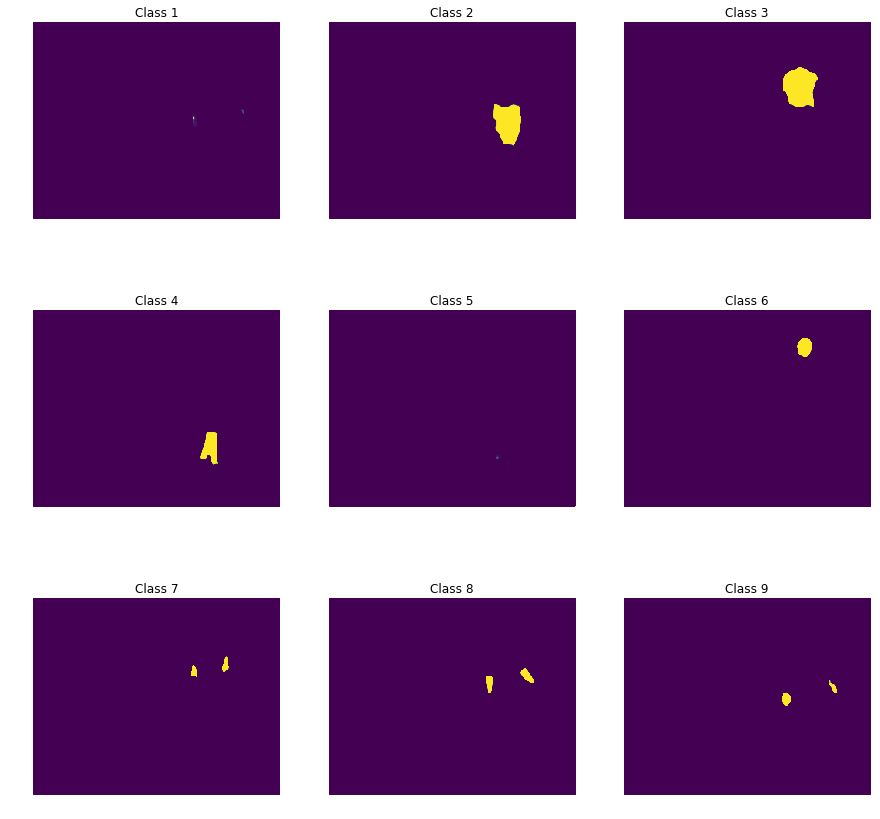

In [28]:
inputs, classes = next(iter(test_loader))
input_img = torch.unsqueeze(Variable(inputs.cuda(async=True)), dim=0)[0]
model.cuda()
model.eval()
output = model(input_img).data.cpu().numpy()

show_pics(output[3], 3, 3)

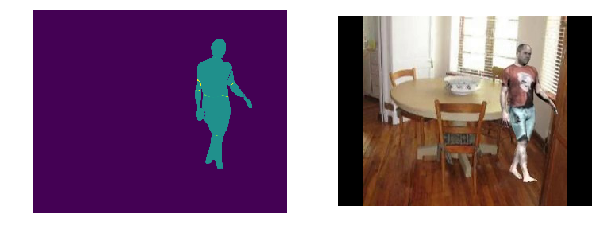

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.sum(output[3], axis=0))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(test_loader.dataset.get_curr_pic()))
plt.axis('off');

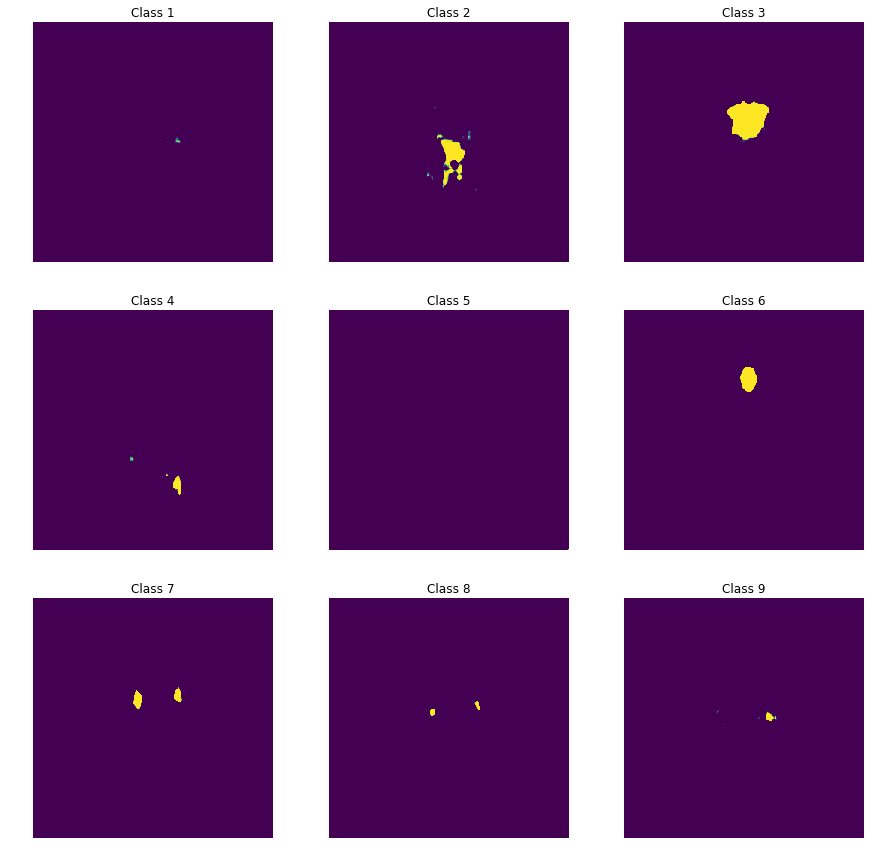

In [34]:
inputs_sit, classes_sit = next(iter(sitting_loader))
input_img_sit = torch.unsqueeze(Variable(inputs_sit.cuda(async=True)), dim=0)[0]
model.cuda()
model.eval()
output_sit = model(input_img_sit).data.cpu().numpy()

show_pics(output_sit[3], 3, 3)

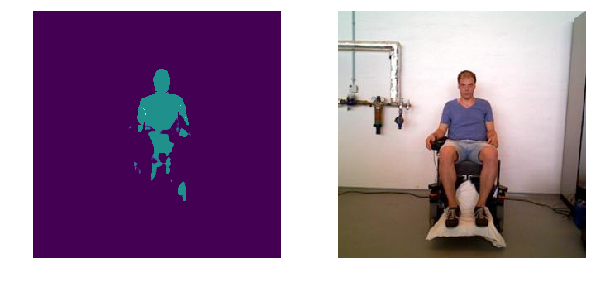

In [35]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.sum(output_sit[3], axis=0))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(sitting_loader.dataset.get_curr_pic()))
plt.axis('off');

## Loss story:

In [81]:
loss_tr = np.zeros((num_epochs))
for j in [k for k in os.listdir('params/') if 'ternaus' in k ]:
    loss_tr[int(j.split('_')[1][-2:])-1] = (torch.load('params/'+j)['min_loss'])

Text(0.5,0,'Number of epoch')

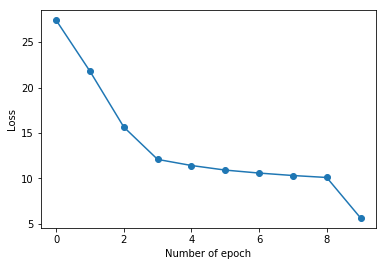

In [84]:
plt.plot(np.arange(0, num_epochs), loss_tr, '-o')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')

**Not normalized loss :(**

## Domain Adaptation Theory

$X$ - input space, $Y = {0, 1, \dots, L-1}$ - set of possible labels.<br>
*Source domain* $D_{S}$ and *target domain* $D_{T}$ are two *different* distributions over $X\times Y$.

An *unsupervised domain adaptation* learning algorithm is then provided with a *labeled source sample* $S$ drawn $i.i.d.$ from $D_{S}$, and *unlabeled target sample* $T$ drawn $i.i.d.$ from $D_{T}^{X}$ - *marginal distribution* of $D_{T}$ over X,

* $\quad S = \{(x_i, y_i)\}_{i=1}^{n} \sim (D_{S})^{n}, \quad T = \{x_{i}\}_{n+1}^{N} \sim (D_{T}^{X})^{n'}$,

with $N = n + n'$ being the total number of samples. The goal of learning algotithm is to build a classifier $\eta : X \rightarrow Y$ with a low **target risk**

* $ \quad R_{D_{T}}(\eta) = Pr_{(x, y) \sim D_{T}}(\eta(x) \neq y)$,

while having no information about labels of $D_{T}$.

(In definition 1 below the hypothesis class $ \mathscr{H}$ is (discrete or continuous) set of binary classifiers $\eta : X \rightarrow \{0, 1\}$. However Ben-David mentions that same analysis holds for multiclass settings. However, to obtain the same results when $|Y| \gt 2$, one should assume that \mathscr{H} is a symmetrical hypothesis class. That is, for all $h \in \mathscr{H}$ and any permutation of labels $c : Y \rightarrow Y$ we have $c(h) \in \mathscr{H}$.)

### Theorem (Ben-David et al., 2006):

Let $\large \mathscr{H}$ be a *hypothessis class* of Vapnik–Chervonenkis(VC) dimension d. With probability $1 - \delta$ over the choice of samples $S \sim (D_{s})^{n}$ and $T \sim (D_{T}^{X})^{n}$ for every $\eta \in \large \mathscr{H}$: 

* $ \quad R_{D_{T}}(\eta) \leq R_{S}(\eta) + \sqrt{\frac{4}{n} (d \log{\frac{2en}{d}} + log{\frac{4}{\delta}})} + \hat{d}_{\mathscr{H}}(S, T) +  4\sqrt{\frac{1}{n} (d \log{\frac{2n}{d}} + log{\frac{4}{\delta}})}  + \beta$, 

with $\beta \geq \inf\limits_{\substack \eta^{*}\in\mathscr{H}} [R_{D_{T}}(\eta^*) + R_{D_{S}}(\eta)]$, and

*  $ \quad R_{S}(\eta) = \frac{1}{n} \sum\limits_{i=1}^{m} I[\eta(x_i) \neq y_i]$

is the *empirical source risk*.


* $R_{D_{T}}(\eta)$ can be low *only* when the $\beta$ term is low, *i.e.*, only when there *exist a classifier that can achieve a low risk on both distributions*. Also this theorem tells us to find a classifier with small $R_{D_{T}}(\eta)$ in a give class of fixed VC dimension, the learning algorithm should minimize (in that class) a trade-off between **the source risk** $R_{S}(\eta)$ and the **empirical $\large \mathscr{H}-$divergence** $\hat{d}_{\mathscr{H}}(S, T)$.

# *In progress*

In [ ]:
num_classes = 21
model_res = Res_Deeplab(num_classes)

In [145]:
path_model = 'http://vllab1.ucmerced.edu/~whung/adv-semi-seg/AdvSemiSegVOC0.125-8d75b3f1.pth'

In [146]:
saved_state_dict = model_zoo.load_url(path_model)

In [147]:
model_res.load_state_dict(saved_state_dict)

In [194]:
img, classes = next(iter(test_loader))

In [195]:
img.shape

torch.Size([4, 3, 256, 320])

In [199]:
model_res.eval()
input_img = torch.unsqueeze(Variable(img[1].view(1, 3, 256, 320)), dim=0)[0]
output = model_res(input_img)
interp = torch.nn.Upsample(size=(256, 320), mode='bilinear')
output = interp(output).cpu().data[0].numpy()
out_ = output.transpose(1,2,0)
#out_ = torch.nn.functional.softmax(interp(output), dim=0).data.cpu().numpy()
out_ = np.asarray(np.argmax(out_, axis=2), dtype=np.int)

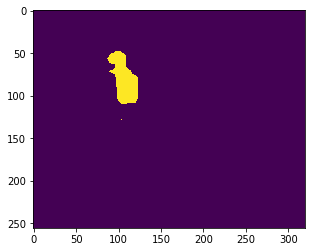

In [201]:
plt.imshow(out_)

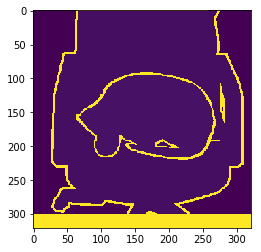

In [118]:
plt.imshow(label[2])

In [4]:
from resnet_da import Res_Deeplab, FCDiscriminator
from torch.utils import data, model_zoo
import torch.backends.cudnn as cudnn
cudnn.enabled = True
cudnn.benchmark = True

In [17]:
num_classes = 9
num_epochs = 3
batch_sz = 4
lr = 1e-4

gpu=torch.cuda.is_available()
# Segmentation NN - ResNet-101 Deeplab
model = Res_Deeplab(num_classes)
model.train()
model.cuda()
#Discriminator NN
model_D = FCDiscriminator(num_classes)
model_D.train()
model_D.cuda()


transf = Compose([
    ToTensor()
])

dset_train = SURREALDataset(dirr_train, 9, transf, identifier='restructed', lengt=10000)
dset_test = SURREALDataset(dirr_test, 9, transf, identifier='restructed', lengt=10000)
dset_val = SURREALDataset(dirr_val, 9, transf, identifier='restructed', lengt=10000)
dset_sitting = SittingDataset(sitting_dirr, 9, transf, identifier='restructed')

source_tr_loader = DataLoader(dset_train, batch_size=batch_sz, shuffle=False)
source_ts_loader = DataLoader(dset_test, batch_size=batch_sz, shuffle=True)
source_val_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=True)
targer_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=False)

In [18]:
from dataset_voc.voc_dataset import VOCDataSet, VOCGTDataSet

train_gt_dataset = VOCGTDataSet('./dataset_voc/VOC2012', './dataset_voc/voc_list/train_aug.txt', crop_size=(321, 321), 
                                mean=np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32))

trainloader_gt = data.DataLoader(train_gt_dataset, batch_size=batch_sz, shuffle=True)

*  $L_{total}(I_s,I_t)=L_{seg}(I_s)+\lambda_{adv}\dot L_{adv}(I_t)$
where $L_{seg}$ is the *cross-entropy loss* using ground truth annotations in the source domain, and $L_{adv}$ is the *adversarial loss* that adapts predicted segmentations of target images to the distribution of source predictions. $\lambda_{adv}$ is the weight used to balance the two losses. 

In [19]:
inputs_sur, classes_sur = next(iter(source_tr_loader))
input_size = inputs_sur.shape

In [20]:
inputs_sit, classes_sit = next(iter(targer_loader))
input_size_target = inputs_sit.shape

In [21]:
# optimizer for segmentation network
optimizer = optim.SGD(model.optim_parameters(lr), lr, momentum=0.9)
optimizer.zero_grad()

# optimizer for discriminator network
optimizer_D = optim.Adam(model_D.parameters(), lr, betas=(0.9,0.99))
optimizer_D.zero_grad()

# loss/ bilinear upsampling
interp = torch.nn.Upsample(size=(input_size[-2], input_size[-1]), mode='bilinear')
interp_target = torch.nn.Upsample(size=(input_size_target[-2], input_size_target[-1]), mode='bilinear')

# labels for adversarial training
source_label = 0
target_label = 1

In [22]:
class CrossEntropy2d(torch.nn.Module):

    def __init__(self, size_average=True, ignore_label=255):
        super(CrossEntropy2d, self).__init__()
        self.size_average = size_average
        self.ignore_label = ignore_label

    def forward(self, predict, target, weight=None):
        """
            Args:
                predict:(n, c, h, w)
                target:(n, h, w)
                weight (Tensor, optional): a manual rescaling weight given to each class.
                                           If given, has to be a Tensor of size "nclasses"
        """
        assert not target.requires_grad
        assert predict.dim() == 4
        assert target.dim() == 3
        assert predict.size(0) == target.size(0), "{0} vs {1} ".format(predict.size(0), target.size(0))
        assert predict.size(2) == target.size(1), "{0} vs {1} ".format(predict.size(2), target.size(1))
        assert predict.size(3) == target.size(2), "{0} vs {1} ".format(predict.size(3), target.size(3))
        n, c, h, w = predict.size()
        target_mask = (target >= 0) * (target != self.ignore_label)
        target = target[target_mask]
        if not target.data.dim():
            return Variable(torch.zeros(1))
        predict = predict.transpose(1, 2).transpose(2, 3).contiguous()
        predict = predict[target_mask.view(n, h, w, 1).repeat(1, 1, 1, c)].view(-1, c)
        loss = torch.nn.functional.cross_entropy(predict, target, weight=weight, size_average=self.size_average)
        
        return loss


In [23]:
def loss_calc(pred, label):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    #label = Variable(label.long()).cuda()
    criterion = CrossEntropy2d().cuda()

    return criterion(pred, label)

def lr_poly(base_lr, iter, max_iter, power):
    return base_lr * ((1 - float(iter) / max_iter) ** (power))


def adjust_learning_rate(optimizer, i_iter):
    power = 0.9
    lr_poly_ = lr_poly(lr, i_iter, num_epochs, power)
    optimizer.param_groups[0]['lr'] = lr_poly_
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10


def adjust_learning_rate_D(optimizer, i_iter):
    power = 0.9
    lr_poly_ = lr_poly(lr, i_iter, num_epochs, power)
    optimizer.param_groups[0]['lr'] = lr_poly_
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10
        
bce_loss = torch.nn.BCEWithLogitsLoss()

In [24]:
for i_iter in range(num_epochs):
    
    for batch_idx, (images_s, labels_s) in enumerate(source_tr_loader):
        loss_seg_value = 0
        loss_adv_pred_value = 0
        loss_D_value = 0
        loss_adv_target_value = 0

        optimizer.zero_grad()
        adjust_learning_rate(optimizer, i_iter)
        optimizer_D.zero_grad()
        adjust_learning_rate_D(optimizer_D, i_iter)
        
        # train G
        
        # don't accumulate grads in D!
        for param in model_D.parameters():
            param.requires_grad = False
        
        # train with source:
        #images, labels = next(iter(source_tr_loader))
        
        pred = interp(model(Variable(images_s.cuda(async=True))))
        loss_seg = loss_calc(pred, Variable(labels_s.cuda(async=True)).long()) / batch_sz
           
        loss_seg.backward()
        loss_seg_value = loss_seg.data.cpu().numpy()[0]
        
        #train with target:
        images_t, labels_t = next(iter(targer_loader))
        pred_target = interp_target(model(Variable(images_t.cuda(async=True))))
        D_out = model_D(torch.nn.functional.softmax(pred_target, dim=0))
     
        loss_adv_target = bce_loss(D_out,
                                     Variable(torch.FloatTensor(D_out.data.size()).fill_(source_label)).cuda())
        loss_adv_target /= batch_sz
        loss_adv_target.backward()
        loss_adv_target_value = loss_adv_target.data.cpu().numpy()[0]
        
        
        # train D:
        # bring back requires_grad
        for param in model_D.parameters():
            param.requires_grad = True    
        
        # train with source
        
        pred = pred.detach()
        D_out = model_D(torch.nn.functional.softmax(pred, dim=0))
        
        loss_D = bce_loss(D_out,
                            Variable(torch.FloatTensor(D_out.data.size()).fill_(source_label)).cuda())
        loss_D = loss_D / batch_sz / 2
        loss_D.backward()
        
        loss_D_value = loss_D.data.cpu().numpy()[0]
        
        # train with target
        pred_target = pred_target.detach()
        
        D_out = model_D(torch.nn.functional.softmax(pred_target, dim=0))
        
        loss_D = bce_loss(D_out,
                          Variable(torch.FloatTensor(D_out.data.size()).fill_(target_label)).cuda())

        loss_D = loss_D / batch_sz / 2
        loss_D.backward()
        loss_D_value += loss_D.data.cpu().numpy()[0]
        
        optimizer.step()
        optimizer_D.step()
        
        
        print(
        'Train Epoch: {0} [{1}/{2} loss_seg = {3} loss_adv = {4} loss_D = {5}'.format(
            i_iter, batch_idx * len(images_s), len(source_tr_loader) * len(images_s),
            loss_seg_value, loss_adv_target_value, loss_D_value)
        )
print('taking snapshot ...',
        torch.save(model.state_dict(), 'model_seg.pth'),
        torch.save(model_D.state_dict(), 'model_D.pth')
     )

Train Epoch: 0 [0/11952 loss_seg = 0.9991876482963562 loss_adv = 0.17296598851680756 loss_D = 0.1732695996761322
Train Epoch: 0 [4/11952 loss_seg = 0.18045058846473694 loss_adv = 0.1725684106349945 loss_D = 0.17319627106189728
Train Epoch: 0 [8/11952 loss_seg = 0.11631206423044205 loss_adv = 0.17209820449352264 loss_D = 0.17321695387363434
Train Epoch: 0 [12/11952 loss_seg = 0.18287073075771332 loss_adv = 0.17170646786689758 loss_D = 0.17298319935798645
Train Epoch: 0 [16/11952 loss_seg = 0.23240777850151062 loss_adv = 0.17116506397724152 loss_D = 0.17291772365570068
Train Epoch: 0 [20/11952 loss_seg = 0.20615866780281067 loss_adv = 0.17058952152729034 loss_D = 0.17265868186950684
Train Epoch: 0 [24/11952 loss_seg = 0.26529502868652344 loss_adv = 0.17006997764110565 loss_D = 0.1723731905221939
Train Epoch: 0 [28/11952 loss_seg = 0.3031303286552429 loss_adv = 0.1696915626525879 loss_D = 0.172288179397583
Train Epoch: 0 [32/11952 loss_seg = 0.25347283482551575 loss_adv = 0.16944496333599

Train Epoch: 0 [284/11952 loss_seg = 0.06506289541721344 loss_adv = 0.18190881609916687 loss_D = 0.17342489957809448
Train Epoch: 0 [288/11952 loss_seg = 0.10294323414564133 loss_adv = 0.18153758347034454 loss_D = 0.1724088042974472
Train Epoch: 0 [292/11952 loss_seg = 0.04579230770468712 loss_adv = 0.18099533021450043 loss_D = 0.17331552505493164
Train Epoch: 0 [296/11952 loss_seg = 0.07723671197891235 loss_adv = 0.18053799867630005 loss_D = 0.1729700267314911
Train Epoch: 0 [300/11952 loss_seg = 0.06238977238535881 loss_adv = 0.18019312620162964 loss_D = 0.17281252145767212
Train Epoch: 0 [304/11952 loss_seg = 0.07570692896842957 loss_adv = 0.17978635430335999 loss_D = 0.1730697900056839
Train Epoch: 0 [308/11952 loss_seg = 0.1143195703625679 loss_adv = 0.17949029803276062 loss_D = 0.17288939654827118
Train Epoch: 0 [312/11952 loss_seg = 0.06274422258138657 loss_adv = 0.1792304962873459 loss_D = 0.17298752069473267
Train Epoch: 0 [316/11952 loss_seg = 0.042738176882267 loss_adv = 0.1

Train Epoch: 0 [568/11952 loss_seg = 0.0552133247256279 loss_adv = 0.18203163146972656 loss_D = 0.1637120246887207
Train Epoch: 0 [572/11952 loss_seg = 0.05502674728631973 loss_adv = 0.17910201847553253 loss_D = 0.16834113001823425
Train Epoch: 0 [576/11952 loss_seg = 0.05362701788544655 loss_adv = 0.17781421542167664 loss_D = 0.16747508943080902
Train Epoch: 0 [580/11952 loss_seg = 0.05383840948343277 loss_adv = 0.17539508640766144 loss_D = 0.1638234257698059
Train Epoch: 0 [584/11952 loss_seg = 0.0572330579161644 loss_adv = 0.17512889206409454 loss_D = 0.16795998811721802
Train Epoch: 0 [588/11952 loss_seg = 0.047339219599962234 loss_adv = 0.17434650659561157 loss_D = 0.16816148161888123
Train Epoch: 0 [592/11952 loss_seg = 0.04781905934214592 loss_adv = 0.17280198633670807 loss_D = 0.17069360613822937
Train Epoch: 0 [596/11952 loss_seg = 0.05287095904350281 loss_adv = 0.17534874379634857 loss_D = 0.16442525386810303
Train Epoch: 0 [600/11952 loss_seg = 0.04284689947962761 loss_adv =

Train Epoch: 0 [852/11952 loss_seg = 0.05846122279763222 loss_adv = 0.17049123346805573 loss_D = 0.186004638671875
Train Epoch: 0 [856/11952 loss_seg = 0.049835462123155594 loss_adv = 0.18070636689662933 loss_D = 0.17978991568088531
Train Epoch: 0 [860/11952 loss_seg = 0.056355103850364685 loss_adv = 0.18555507063865662 loss_D = 0.1713937520980835
Train Epoch: 0 [864/11952 loss_seg = 0.05454668775200844 loss_adv = 0.18904165923595428 loss_D = 0.1779676377773285
Train Epoch: 0 [868/11952 loss_seg = 0.05785750597715378 loss_adv = 0.1894875019788742 loss_D = 0.16196119785308838
Train Epoch: 0 [872/11952 loss_seg = 0.050947096198797226 loss_adv = 0.19225680828094482 loss_D = 0.16836297512054443
Train Epoch: 0 [876/11952 loss_seg = 0.047772038727998734 loss_adv = 0.19495448470115662 loss_D = 0.15978002548217773
Train Epoch: 0 [880/11952 loss_seg = 0.05614275857806206 loss_adv = 0.19929054379463196 loss_D = 0.16305221617221832
Train Epoch: 0 [884/11952 loss_seg = 0.04838583618402481 loss_adv

Train Epoch: 0 [1132/11952 loss_seg = 0.04292674735188484 loss_adv = 0.17526355385780334 loss_D = 0.17154109477996826
Train Epoch: 0 [1136/11952 loss_seg = 0.04018529877066612 loss_adv = 0.17594581842422485 loss_D = 0.17118048667907715
Train Epoch: 0 [1140/11952 loss_seg = 0.037337251007556915 loss_adv = 0.17556750774383545 loss_D = 0.1673879325389862
Train Epoch: 0 [1144/11952 loss_seg = 0.050260286778211594 loss_adv = 0.17749956250190735 loss_D = 0.1682182252407074
Train Epoch: 0 [1148/11952 loss_seg = 0.036309849470853806 loss_adv = 0.18105298280715942 loss_D = 0.16852551698684692
Train Epoch: 0 [1152/11952 loss_seg = 0.03121372126042843 loss_adv = 0.1908445954322815 loss_D = 0.17041131854057312
Train Epoch: 0 [1156/11952 loss_seg = 0.03687159717082977 loss_adv = 0.19687514007091522 loss_D = 0.16505765914916992
Train Epoch: 0 [1160/11952 loss_seg = 0.0391678623855114 loss_adv = 0.19998329877853394 loss_D = 0.1681978702545166
Train Epoch: 0 [1164/11952 loss_seg = 0.03905883803963661 

Train Epoch: 0 [1412/11952 loss_seg = 0.04168514907360077 loss_adv = 0.1824152171611786 loss_D = 0.16751724481582642
Train Epoch: 0 [1416/11952 loss_seg = 0.03701453655958176 loss_adv = 0.1815638691186905 loss_D = 0.16815659403800964
Train Epoch: 0 [1420/11952 loss_seg = 0.03174010291695595 loss_adv = 0.17864669859409332 loss_D = 0.16874581575393677
Train Epoch: 0 [1424/11952 loss_seg = 0.03575238585472107 loss_adv = 0.17677953839302063 loss_D = 0.165412038564682
Train Epoch: 0 [1428/11952 loss_seg = 0.0483388677239418 loss_adv = 0.1796730011701584 loss_D = 0.16704145073890686
Train Epoch: 0 [1432/11952 loss_seg = 0.03318314999341965 loss_adv = 0.1854562759399414 loss_D = 0.16629847884178162
Train Epoch: 0 [1436/11952 loss_seg = 0.04251076281070709 loss_adv = 0.18951107561588287 loss_D = 0.17156338691711426
Train Epoch: 0 [1440/11952 loss_seg = 0.04243559390306473 loss_adv = 0.1887442171573639 loss_D = 0.16615337133407593
Train Epoch: 0 [1444/11952 loss_seg = 0.030712326988577843 loss_

Train Epoch: 0 [1692/11952 loss_seg = 0.03944145515561104 loss_adv = 0.20023372769355774 loss_D = 0.16998693346977234
Train Epoch: 0 [1696/11952 loss_seg = 0.039685945957899094 loss_adv = 0.19536249339580536 loss_D = 0.173349529504776
Train Epoch: 0 [1700/11952 loss_seg = 0.03060065396130085 loss_adv = 0.18647976219654083 loss_D = 0.1695481687784195
Train Epoch: 0 [1704/11952 loss_seg = 0.0363599993288517 loss_adv = 0.18039371073246002 loss_D = 0.16954202950000763
Train Epoch: 0 [1708/11952 loss_seg = 0.03315000981092453 loss_adv = 0.17669382691383362 loss_D = 0.1702190786600113
Train Epoch: 0 [1712/11952 loss_seg = 0.04106934741139412 loss_adv = 0.17534562945365906 loss_D = 0.1707906574010849
Train Epoch: 0 [1716/11952 loss_seg = 0.0365385077893734 loss_adv = 0.178055539727211 loss_D = 0.1714020073413849
Train Epoch: 0 [1720/11952 loss_seg = 0.028311122208833694 loss_adv = 0.1813955307006836 loss_D = 0.17579738795757294
Train Epoch: 0 [1724/11952 loss_seg = 0.03578346222639084 loss_ad

Train Epoch: 0 [1972/11952 loss_seg = 0.043163739144802094 loss_adv = 0.17907246947288513 loss_D = 0.1708931177854538
Train Epoch: 0 [1976/11952 loss_seg = 0.031070344150066376 loss_adv = 0.17495670914649963 loss_D = 0.17004182934761047
Train Epoch: 0 [1980/11952 loss_seg = 0.024751892313361168 loss_adv = 0.1742052435874939 loss_D = 0.17118066549301147
Train Epoch: 0 [1984/11952 loss_seg = 0.03326854854822159 loss_adv = 0.17758125066757202 loss_D = 0.17013397812843323
Train Epoch: 0 [1988/11952 loss_seg = 0.03127676993608475 loss_adv = 0.18527305126190186 loss_D = 0.16943809390068054
Train Epoch: 0 [1992/11952 loss_seg = 0.031911641359329224 loss_adv = 0.19141627848148346 loss_D = 0.16940024495124817
Train Epoch: 0 [1996/11952 loss_seg = 0.027184197679162025 loss_adv = 0.19163531064987183 loss_D = 0.1697959303855896
Train Epoch: 0 [2000/11952 loss_seg = 0.027614325284957886 loss_adv = 0.1861393302679062 loss_D = 0.16972830891609192
Train Epoch: 0 [2004/11952 loss_seg = 0.03307258337736

Train Epoch: 0 [2252/11952 loss_seg = 0.036715030670166016 loss_adv = 0.17018894851207733 loss_D = 0.17005780339241028
Train Epoch: 0 [2256/11952 loss_seg = 0.025899749249219894 loss_adv = 0.17067378759384155 loss_D = 0.17404285073280334
Train Epoch: 0 [2260/11952 loss_seg = 0.024990636855363846 loss_adv = 0.17385509610176086 loss_D = 0.17195966839790344
Train Epoch: 0 [2264/11952 loss_seg = 0.026908939704298973 loss_adv = 0.1774439662694931 loss_D = 0.1713429093360901
Train Epoch: 0 [2268/11952 loss_seg = 0.03067903220653534 loss_adv = 0.17720431089401245 loss_D = 0.1705300509929657
Train Epoch: 0 [2272/11952 loss_seg = 0.037454165518283844 loss_adv = 0.1747039556503296 loss_D = 0.1713709682226181
Train Epoch: 0 [2276/11952 loss_seg = 0.030657995492219925 loss_adv = 0.1706128567457199 loss_D = 0.16977009177207947
Train Epoch: 0 [2280/11952 loss_seg = 0.023493044078350067 loss_adv = 0.16887694597244263 loss_D = 0.1718362271785736
Train Epoch: 0 [2284/11952 loss_seg = 0.0256680808961391

Train Epoch: 0 [2532/11952 loss_seg = 0.10562145709991455 loss_adv = 0.17553287744522095 loss_D = 0.17782637476921082
Train Epoch: 0 [2536/11952 loss_seg = 0.12503354251384735 loss_adv = 0.18491008877754211 loss_D = 0.1699223816394806
Train Epoch: 0 [2540/11952 loss_seg = 0.14124302566051483 loss_adv = 0.2031685709953308 loss_D = 0.16810885071754456
Train Epoch: 0 [2544/11952 loss_seg = 0.10548672825098038 loss_adv = 0.20716923475265503 loss_D = 0.18539926409721375
Train Epoch: 0 [2548/11952 loss_seg = 0.1234179437160492 loss_adv = 0.17489680647850037 loss_D = 0.17715668678283691
Train Epoch: 0 [2552/11952 loss_seg = 0.0812690481543541 loss_adv = 0.15851570665836334 loss_D = 0.1727268546819687
Train Epoch: 0 [2556/11952 loss_seg = 0.08070811629295349 loss_adv = 0.16681914031505585 loss_D = 0.1787802278995514
Train Epoch: 0 [2560/11952 loss_seg = 0.046312734484672546 loss_adv = 0.18401294946670532 loss_D = 0.18769767880439758
Train Epoch: 0 [2564/11952 loss_seg = 0.05816468968987465 los

Train Epoch: 0 [2812/11952 loss_seg = 0.077043317258358 loss_adv = 0.17745745182037354 loss_D = 0.17971713840961456
Train Epoch: 0 [2816/11952 loss_seg = 0.047015029937028885 loss_adv = 0.1752202957868576 loss_D = 0.16743773221969604
Train Epoch: 0 [2820/11952 loss_seg = 0.06061873212456703 loss_adv = 0.17496469616889954 loss_D = 0.16850712895393372
Train Epoch: 0 [2824/11952 loss_seg = 0.08357440680265427 loss_adv = 0.17666415870189667 loss_D = 0.1744503676891327
Train Epoch: 0 [2828/11952 loss_seg = 0.07439220696687698 loss_adv = 0.1780431866645813 loss_D = 0.16988125443458557
Train Epoch: 0 [2832/11952 loss_seg = 0.05977821722626686 loss_adv = 0.17972667515277863 loss_D = 0.16938859224319458
Train Epoch: 0 [2836/11952 loss_seg = 0.04213647544384003 loss_adv = 0.18027301132678986 loss_D = 0.16971853375434875
Train Epoch: 0 [2840/11952 loss_seg = 0.07212608307600021 loss_adv = 0.18067094683647156 loss_D = 0.17566147446632385
Train Epoch: 0 [2844/11952 loss_seg = 0.06271185725927353 lo

Train Epoch: 0 [3092/11952 loss_seg = 0.0374017134308815 loss_adv = 0.17604291439056396 loss_D = 0.1744360625743866
Train Epoch: 0 [3096/11952 loss_seg = 0.03945193067193031 loss_adv = 0.1744493544101715 loss_D = 0.17182058095932007
Train Epoch: 0 [3100/11952 loss_seg = 0.052676018327474594 loss_adv = 0.17418281733989716 loss_D = 0.1734459400177002
Train Epoch: 0 [3104/11952 loss_seg = 0.03720703348517418 loss_adv = 0.17429649829864502 loss_D = 0.17442560195922852
Train Epoch: 0 [3108/11952 loss_seg = 0.04894242808222771 loss_adv = 0.17431692779064178 loss_D = 0.17213121056556702
Train Epoch: 0 [3112/11952 loss_seg = 0.048586271703243256 loss_adv = 0.1749121993780136 loss_D = 0.17324581742286682
Train Epoch: 0 [3116/11952 loss_seg = 0.04023594781756401 loss_adv = 0.17543193697929382 loss_D = 0.17369452118873596
Train Epoch: 0 [3120/11952 loss_seg = 0.04479731619358063 loss_adv = 0.17540425062179565 loss_D = 0.17260172963142395
Train Epoch: 0 [3124/11952 loss_seg = 0.04709228500723839 l

Train Epoch: 0 [3372/11952 loss_seg = 0.04106101393699646 loss_adv = 0.1665317863225937 loss_D = 0.16914910078048706
Train Epoch: 0 [3376/11952 loss_seg = 0.04525509476661682 loss_adv = 0.16729505360126495 loss_D = 0.16839739680290222
Train Epoch: 0 [3380/11952 loss_seg = 0.04638658091425896 loss_adv = 0.1694936603307724 loss_D = 0.17649853229522705
Train Epoch: 0 [3384/11952 loss_seg = 0.03811982274055481 loss_adv = 0.1703033447265625 loss_D = 0.1743876188993454
Train Epoch: 0 [3388/11952 loss_seg = 0.056444019079208374 loss_adv = 0.17108815908432007 loss_D = 0.17355462908744812
Train Epoch: 0 [3392/11952 loss_seg = 0.04386098310351372 loss_adv = 0.17156237363815308 loss_D = 0.17402592301368713
Train Epoch: 0 [3396/11952 loss_seg = 0.04246747866272926 loss_adv = 0.1717756986618042 loss_D = 0.16852125525474548
Train Epoch: 0 [3400/11952 loss_seg = 0.03305334970355034 loss_adv = 0.17341001331806183 loss_D = 0.17363137006759644
Train Epoch: 0 [3404/11952 loss_seg = 0.04869670048356056 lo

Train Epoch: 0 [3652/11952 loss_seg = 0.038641199469566345 loss_adv = 0.17534855008125305 loss_D = 0.17125898599624634
Train Epoch: 0 [3656/11952 loss_seg = 0.03713523596525192 loss_adv = 0.1738414615392685 loss_D = 0.1750967800617218
Train Epoch: 0 [3660/11952 loss_seg = 0.02682769112288952 loss_adv = 0.17387741804122925 loss_D = 0.17298480868339539
Train Epoch: 0 [3664/11952 loss_seg = 0.03532683104276657 loss_adv = 0.17361168563365936 loss_D = 0.1715463101863861
Train Epoch: 0 [3668/11952 loss_seg = 0.033025167882442474 loss_adv = 0.17239399254322052 loss_D = 0.17207953333854675
Train Epoch: 0 [3672/11952 loss_seg = 0.033563658595085144 loss_adv = 0.17104335129261017 loss_D = 0.17133952677249908
Train Epoch: 0 [3676/11952 loss_seg = 0.025790372863411903 loss_adv = 0.17169064283370972 loss_D = 0.17143522202968597
Train Epoch: 0 [3680/11952 loss_seg = 0.04127885401248932 loss_adv = 0.17383453249931335 loss_D = 0.17472106218338013
Train Epoch: 0 [3684/11952 loss_seg = 0.031535446643829

Train Epoch: 0 [3932/11952 loss_seg = 0.0384385883808136 loss_adv = 0.17289361357688904 loss_D = 0.174662247300148
Train Epoch: 0 [3936/11952 loss_seg = 0.03530897945165634 loss_adv = 0.16987518966197968 loss_D = 0.1816910356283188
Train Epoch: 0 [3940/11952 loss_seg = 0.04154374077916145 loss_adv = 0.16947601735591888 loss_D = 0.18525001406669617
Train Epoch: 0 [3944/11952 loss_seg = 0.03415895253419876 loss_adv = 0.17059457302093506 loss_D = 0.18064600229263306
Train Epoch: 0 [3948/11952 loss_seg = 0.03649996593594551 loss_adv = 0.17490436136722565 loss_D = 0.17814533412456512
Train Epoch: 0 [3952/11952 loss_seg = 0.03260476887226105 loss_adv = 0.18140649795532227 loss_D = 0.17478136718273163
Train Epoch: 0 [3956/11952 loss_seg = 0.03309854120016098 loss_adv = 0.18790383636951447 loss_D = 0.1820240318775177
Train Epoch: 0 [3960/11952 loss_seg = 0.03341568633913994 loss_adv = 0.18947456777095795 loss_D = 0.17782631516456604
Train Epoch: 0 [3964/11952 loss_seg = 0.033769115805625916 lo

Train Epoch: 0 [4212/11952 loss_seg = 0.0274606104940176 loss_adv = 0.17459528148174286 loss_D = 0.17031751573085785
Train Epoch: 0 [4216/11952 loss_seg = 0.024921372532844543 loss_adv = 0.17801780998706818 loss_D = 0.1731678545475006
Train Epoch: 0 [4220/11952 loss_seg = 0.02252971939742565 loss_adv = 0.17815160751342773 loss_D = 0.1731002777814865
Train Epoch: 0 [4224/11952 loss_seg = 0.029727479442954063 loss_adv = 0.1754477322101593 loss_D = 0.1708245873451233
Train Epoch: 0 [4228/11952 loss_seg = 0.026248272508382797 loss_adv = 0.17216511070728302 loss_D = 0.17272698879241943
Train Epoch: 0 [4232/11952 loss_seg = 0.022540928795933723 loss_adv = 0.16953295469284058 loss_D = 0.17286796867847443
Train Epoch: 0 [4236/11952 loss_seg = 0.02371133491396904 loss_adv = 0.16783402860164642 loss_D = 0.17149606347084045
Train Epoch: 0 [4240/11952 loss_seg = 0.023401712998747826 loss_adv = 0.16715553402900696 loss_D = 0.172178253531456
Train Epoch: 0 [4244/11952 loss_seg = 0.028039338067173958

Train Epoch: 0 [4492/11952 loss_seg = 0.05349902808666229 loss_adv = 0.17920902371406555 loss_D = 0.1716822236776352
Train Epoch: 0 [4496/11952 loss_seg = 0.061663635075092316 loss_adv = 0.17838621139526367 loss_D = 0.17207637429237366
Train Epoch: 0 [4500/11952 loss_seg = 0.05036531761288643 loss_adv = 0.17726871371269226 loss_D = 0.1718723177909851
Train Epoch: 0 [4504/11952 loss_seg = 0.08472985029220581 loss_adv = 0.17634738981723785 loss_D = 0.17357540130615234
Train Epoch: 0 [4508/11952 loss_seg = 0.09847164154052734 loss_adv = 0.17619100213050842 loss_D = 0.1718859076499939
Train Epoch: 0 [4512/11952 loss_seg = 0.07408250868320465 loss_adv = 0.17605334520339966 loss_D = 0.1725875437259674
Train Epoch: 0 [4516/11952 loss_seg = 0.053521450608968735 loss_adv = 0.17695020139217377 loss_D = 0.17195750772953033
Train Epoch: 0 [4520/11952 loss_seg = 0.04917013645172119 loss_adv = 0.1781078279018402 loss_D = 0.17202934622764587
Train Epoch: 0 [4524/11952 loss_seg = 0.047647058963775635 

Train Epoch: 0 [4772/11952 loss_seg = 0.062159471213817596 loss_adv = 0.17205144464969635 loss_D = 0.17162412405014038
Train Epoch: 0 [4776/11952 loss_seg = 0.0949174165725708 loss_adv = 0.1702578216791153 loss_D = 0.17012245953083038
Train Epoch: 0 [4780/11952 loss_seg = 0.04016910120844841 loss_adv = 0.16884811222553253 loss_D = 0.17340406775474548
Train Epoch: 0 [4784/11952 loss_seg = 0.05947635695338249 loss_adv = 0.16835834085941315 loss_D = 0.17170467972755432
Train Epoch: 0 [4788/11952 loss_seg = 0.06358020752668381 loss_adv = 0.1683676540851593 loss_D = 0.17391011118888855
Train Epoch: 0 [4792/11952 loss_seg = 0.04835239797830582 loss_adv = 0.168861985206604 loss_D = 0.17202934622764587
Train Epoch: 0 [4796/11952 loss_seg = 0.026261478662490845 loss_adv = 0.1696479469537735 loss_D = 0.17002667486667633
Train Epoch: 0 [4800/11952 loss_seg = 0.05311807617545128 loss_adv = 0.17102423310279846 loss_D = 0.1726519763469696
Train Epoch: 0 [4804/11952 loss_seg = 0.07526372373104095 los

Train Epoch: 0 [5052/11952 loss_seg = 0.06736476719379425 loss_adv = 0.17800088226795197 loss_D = 0.17469117045402527
Train Epoch: 0 [5056/11952 loss_seg = 0.07785143703222275 loss_adv = 0.1719934493303299 loss_D = 0.1731816679239273
Train Epoch: 0 [5060/11952 loss_seg = 0.11000777781009674 loss_adv = 0.1678996980190277 loss_D = 0.17229370772838593
Train Epoch: 0 [5064/11952 loss_seg = 0.0935274064540863 loss_adv = 0.16558298468589783 loss_D = 0.17316403985023499
Train Epoch: 0 [5068/11952 loss_seg = 0.07171665877103806 loss_adv = 0.1659027487039566 loss_D = 0.16894149780273438
Train Epoch: 0 [5072/11952 loss_seg = 0.06761197000741959 loss_adv = 0.16960205137729645 loss_D = 0.17260712385177612
Train Epoch: 0 [5076/11952 loss_seg = 0.05806884914636612 loss_adv = 0.17327982187271118 loss_D = 0.17163878679275513
Train Epoch: 0 [5080/11952 loss_seg = 0.058081984519958496 loss_adv = 0.17595793306827545 loss_D = 0.16964688897132874
Train Epoch: 0 [5084/11952 loss_seg = 0.06031389161944389 lo

Train Epoch: 0 [5332/11952 loss_seg = 0.06440763175487518 loss_adv = 0.17334973812103271 loss_D = 0.17074060440063477
Train Epoch: 0 [5336/11952 loss_seg = 0.051128555089235306 loss_adv = 0.17673197388648987 loss_D = 0.17122018337249756
Train Epoch: 0 [5340/11952 loss_seg = 0.08903635293245316 loss_adv = 0.1801987886428833 loss_D = 0.17509451508522034
Train Epoch: 0 [5344/11952 loss_seg = 0.047561462968587875 loss_adv = 0.18029950559139252 loss_D = 0.17182011902332306
Train Epoch: 0 [5348/11952 loss_seg = 0.06666547805070877 loss_adv = 0.17891241610050201 loss_D = 0.1713934987783432
Train Epoch: 0 [5352/11952 loss_seg = 0.06788094341754913 loss_adv = 0.17711198329925537 loss_D = 0.1732255518436432
Train Epoch: 0 [5356/11952 loss_seg = 0.09349372982978821 loss_adv = 0.1746927797794342 loss_D = 0.17397978901863098
Train Epoch: 0 [5360/11952 loss_seg = 0.07642131298780441 loss_adv = 0.17177695035934448 loss_D = 0.17077578604221344
Train Epoch: 0 [5364/11952 loss_seg = 0.0714816078543663 l

Train Epoch: 0 [5612/11952 loss_seg = 0.05731575936079025 loss_adv = 0.17860181629657745 loss_D = 0.17367321252822876
Train Epoch: 0 [5616/11952 loss_seg = 0.08560267090797424 loss_adv = 0.1822529435157776 loss_D = 0.17182661592960358
Train Epoch: 0 [5620/11952 loss_seg = 0.043558813631534576 loss_adv = 0.18316389620304108 loss_D = 0.17363691329956055
Train Epoch: 0 [5624/11952 loss_seg = 0.049566514790058136 loss_adv = 0.18390966951847076 loss_D = 0.17001062631607056
Train Epoch: 0 [5628/11952 loss_seg = 0.07739928364753723 loss_adv = 0.18398350477218628 loss_D = 0.1734171211719513
Train Epoch: 0 [5632/11952 loss_seg = 0.07093522697687149 loss_adv = 0.17871251702308655 loss_D = 0.17243963479995728
Train Epoch: 0 [5636/11952 loss_seg = 0.05121586099267006 loss_adv = 0.1709940880537033 loss_D = 0.17234346270561218
Train Epoch: 0 [5640/11952 loss_seg = 0.044136859476566315 loss_adv = 0.16468475759029388 loss_D = 0.17334102094173431
Train Epoch: 0 [5644/11952 loss_seg = 0.0673087537288665

Train Epoch: 0 [5892/11952 loss_seg = 0.06718456745147705 loss_adv = 0.17234733700752258 loss_D = 0.17354385554790497
Train Epoch: 0 [5896/11952 loss_seg = 0.07176126539707184 loss_adv = 0.17307613790035248 loss_D = 0.17352557182312012
Train Epoch: 0 [5900/11952 loss_seg = 0.05179717391729355 loss_adv = 0.17432300746440887 loss_D = 0.17430515587329865
Train Epoch: 0 [5904/11952 loss_seg = 0.09525373578071594 loss_adv = 0.17570504546165466 loss_D = 0.17318573594093323
Train Epoch: 0 [5908/11952 loss_seg = 0.04869038611650467 loss_adv = 0.1771693378686905 loss_D = 0.17319518327713013
Train Epoch: 0 [5912/11952 loss_seg = 0.054832737892866135 loss_adv = 0.1787135750055313 loss_D = 0.1727682203054428
Train Epoch: 0 [5916/11952 loss_seg = 0.07197238504886627 loss_adv = 0.17779968678951263 loss_D = 0.1732960343360901
Train Epoch: 0 [5920/11952 loss_seg = 0.08233358711004257 loss_adv = 0.17589139938354492 loss_D = 0.1721828132867813
Train Epoch: 0 [5924/11952 loss_seg = 0.06062982603907585 lo

Train Epoch: 0 [6172/11952 loss_seg = 0.05450036749243736 loss_adv = 0.1737123429775238 loss_D = 0.17236073315143585
Train Epoch: 0 [6176/11952 loss_seg = 0.04147903248667717 loss_adv = 0.17493437230587006 loss_D = 0.1733911633491516
Train Epoch: 0 [6180/11952 loss_seg = 0.05230084806680679 loss_adv = 0.17698915302753448 loss_D = 0.17249758541584015
Train Epoch: 0 [6184/11952 loss_seg = 0.04688623547554016 loss_adv = 0.1800403743982315 loss_D = 0.17193888127803802
Train Epoch: 0 [6188/11952 loss_seg = 0.06437619775533676 loss_adv = 0.18182101845741272 loss_D = 0.17448468506336212
Train Epoch: 0 [6192/11952 loss_seg = 0.06312735378742218 loss_adv = 0.1773344874382019 loss_D = 0.17239084839820862
Train Epoch: 0 [6196/11952 loss_seg = 0.05613858625292778 loss_adv = 0.1724856197834015 loss_D = 0.172235906124115
Train Epoch: 0 [6200/11952 loss_seg = 0.0631498172879219 loss_adv = 0.16999325156211853 loss_D = 0.1723068654537201
Train Epoch: 0 [6204/11952 loss_seg = 0.05049462988972664 loss_ad

Train Epoch: 0 [6452/11952 loss_seg = 0.05377347022294998 loss_adv = 0.1718061864376068 loss_D = 0.17172139883041382
Train Epoch: 0 [6456/11952 loss_seg = 0.05440919101238251 loss_adv = 0.174446702003479 loss_D = 0.1721314638853073
Train Epoch: 0 [6460/11952 loss_seg = 0.044936634600162506 loss_adv = 0.17605870962142944 loss_D = 0.17401283979415894
Train Epoch: 0 [6464/11952 loss_seg = 0.04605332762002945 loss_adv = 0.1760328859090805 loss_D = 0.17176207900047302
Train Epoch: 0 [6468/11952 loss_seg = 0.04599641636013985 loss_adv = 0.1758238971233368 loss_D = 0.17398561537265778
Train Epoch: 0 [6472/11952 loss_seg = 0.06890600919723511 loss_adv = 0.17407545447349548 loss_D = 0.17366212606430054
Train Epoch: 0 [6476/11952 loss_seg = 0.05355611443519592 loss_adv = 0.1728854924440384 loss_D = 0.17157819867134094
Train Epoch: 0 [6480/11952 loss_seg = 0.05755031108856201 loss_adv = 0.1758926808834076 loss_D = 0.1750761866569519
Train Epoch: 0 [6484/11952 loss_seg = 0.07425650954246521 loss_a

Train Epoch: 0 [6732/11952 loss_seg = 0.06815125048160553 loss_adv = 0.1784985363483429 loss_D = 0.1729586273431778
Train Epoch: 0 [6736/11952 loss_seg = 0.044884003698825836 loss_adv = 0.17755496501922607 loss_D = 0.1738891303539276
Train Epoch: 0 [6740/11952 loss_seg = 0.06867935508489609 loss_adv = 0.1757211685180664 loss_D = 0.17222106456756592
Train Epoch: 0 [6744/11952 loss_seg = 0.0602685809135437 loss_adv = 0.17425155639648438 loss_D = 0.17160844802856445
Train Epoch: 0 [6748/11952 loss_seg = 0.06994064152240753 loss_adv = 0.17440277338027954 loss_D = 0.17163296043872833
Train Epoch: 0 [6752/11952 loss_seg = 0.05375919118523598 loss_adv = 0.1744147539138794 loss_D = 0.1733657270669937
Train Epoch: 0 [6756/11952 loss_seg = 0.08030450344085693 loss_adv = 0.1744275987148285 loss_D = 0.1714097410440445
Train Epoch: 0 [6760/11952 loss_seg = 0.061570607125759125 loss_adv = 0.17464908957481384 loss_D = 0.17193517088890076
Train Epoch: 0 [6764/11952 loss_seg = 0.05190924555063248 loss_

Train Epoch: 0 [7012/11952 loss_seg = 0.03862426057457924 loss_adv = 0.18703924119472504 loss_D = 0.1729121208190918
Train Epoch: 0 [7016/11952 loss_seg = 0.02860073558986187 loss_adv = 0.18479853868484497 loss_D = 0.17431211471557617
Train Epoch: 0 [7020/11952 loss_seg = 0.030778996646404266 loss_adv = 0.18165548145771027 loss_D = 0.174104243516922
Train Epoch: 0 [7024/11952 loss_seg = 0.030955499038100243 loss_adv = 0.17825917899608612 loss_D = 0.17367123067378998
Train Epoch: 0 [7028/11952 loss_seg = 0.03240008279681206 loss_adv = 0.17521271109580994 loss_D = 0.1723371148109436
Train Epoch: 0 [7032/11952 loss_seg = 0.04425977170467377 loss_adv = 0.1731628179550171 loss_D = 0.17339247465133667
Train Epoch: 0 [7036/11952 loss_seg = 0.03904734179377556 loss_adv = 0.1723502278327942 loss_D = 0.17086777091026306
Train Epoch: 0 [7040/11952 loss_seg = 0.04152027517557144 loss_adv = 0.17359788715839386 loss_D = 0.16972768306732178
Train Epoch: 0 [7044/11952 loss_seg = 0.027576012536883354 l

Train Epoch: 0 [7292/11952 loss_seg = 0.041504185646772385 loss_adv = 0.17081092298030853 loss_D = 0.1735202521085739
Train Epoch: 0 [7296/11952 loss_seg = 0.0727100670337677 loss_adv = 0.16933384537696838 loss_D = 0.17271685600280762
Train Epoch: 0 [7300/11952 loss_seg = 0.07808934152126312 loss_adv = 0.16823053359985352 loss_D = 0.17268770933151245
Train Epoch: 0 [7304/11952 loss_seg = 0.06310071796178818 loss_adv = 0.16768939793109894 loss_D = 0.17307880520820618
Train Epoch: 0 [7308/11952 loss_seg = 0.03994711861014366 loss_adv = 0.16765102744102478 loss_D = 0.17326903343200684
Train Epoch: 0 [7312/11952 loss_seg = 0.05342993512749672 loss_adv = 0.16822311282157898 loss_D = 0.17375241219997406
Train Epoch: 0 [7316/11952 loss_seg = 0.05262640491127968 loss_adv = 0.16960245370864868 loss_D = 0.1728668212890625
Train Epoch: 0 [7320/11952 loss_seg = 0.06449203193187714 loss_adv = 0.17094245553016663 loss_D = 0.17279109358787537
Train Epoch: 0 [7324/11952 loss_seg = 0.07029320299625397 

Train Epoch: 0 [7572/11952 loss_seg = 0.03936481103301048 loss_adv = 0.17362751066684723 loss_D = 0.1730327308177948
Train Epoch: 0 [7576/11952 loss_seg = 0.014110811986029148 loss_adv = 0.17397819459438324 loss_D = 0.17449018359184265
Train Epoch: 0 [7580/11952 loss_seg = 0.03560367226600647 loss_adv = 0.17499405145645142 loss_D = 0.1734638661146164
Train Epoch: 0 [7584/11952 loss_seg = 0.04422041401267052 loss_adv = 0.17512112855911255 loss_D = 0.17287662625312805
Train Epoch: 0 [7588/11952 loss_seg = 0.06401492655277252 loss_adv = 0.1750939041376114 loss_D = 0.17341502010822296
Train Epoch: 0 [7592/11952 loss_seg = 0.04486631974577904 loss_adv = 0.17484766244888306 loss_D = 0.17295365035533905
Train Epoch: 0 [7596/11952 loss_seg = 0.045044537633657455 loss_adv = 0.17450988292694092 loss_D = 0.17297537624835968
Train Epoch: 0 [7600/11952 loss_seg = 0.035502057522535324 loss_adv = 0.17426416277885437 loss_D = 0.17270788550376892
Train Epoch: 0 [7604/11952 loss_seg = 0.0385295934975147

Train Epoch: 0 [7852/11952 loss_seg = 0.019382309168577194 loss_adv = 0.1719827651977539 loss_D = 0.17352309823036194
Train Epoch: 0 [7856/11952 loss_seg = 0.021370094269514084 loss_adv = 0.17176035046577454 loss_D = 0.17321431636810303
Train Epoch: 0 [7860/11952 loss_seg = 0.029411930590867996 loss_adv = 0.17162539064884186 loss_D = 0.17250186204910278
Train Epoch: 0 [7864/11952 loss_seg = 0.053374119102954865 loss_adv = 0.1717963069677353 loss_D = 0.17383384704589844
Train Epoch: 0 [7868/11952 loss_seg = 0.02554953843355179 loss_adv = 0.17260053753852844 loss_D = 0.17333242297172546
Train Epoch: 0 [7872/11952 loss_seg = 0.02369736321270466 loss_adv = 0.17372553050518036 loss_D = 0.17274494469165802
Train Epoch: 0 [7876/11952 loss_seg = 0.039246391505002975 loss_adv = 0.1740240901708603 loss_D = 0.17288723587989807
Train Epoch: 0 [7880/11952 loss_seg = 0.021501343697309494 loss_adv = 0.1735110878944397 loss_D = 0.17484281957149506
Train Epoch: 0 [7884/11952 loss_seg = 0.01641748473048

Train Epoch: 0 [8132/11952 loss_seg = 0.07078667730093002 loss_adv = 0.17327862977981567 loss_D = 0.17328187823295593
Train Epoch: 0 [8136/11952 loss_seg = 0.09993606060743332 loss_adv = 0.17140185832977295 loss_D = 0.1721048653125763
Train Epoch: 0 [8140/11952 loss_seg = 0.062477052211761475 loss_adv = 0.17079421877861023 loss_D = 0.17199185490608215
Train Epoch: 0 [8144/11952 loss_seg = 0.05845723673701286 loss_adv = 0.17069344222545624 loss_D = 0.17163710296154022
Train Epoch: 0 [8148/11952 loss_seg = 0.06032869964838028 loss_adv = 0.17031782865524292 loss_D = 0.1734623908996582
Train Epoch: 0 [8152/11952 loss_seg = 0.04210733249783516 loss_adv = 0.1700882911682129 loss_D = 0.17323443293571472
Train Epoch: 0 [8156/11952 loss_seg = 0.08209533989429474 loss_adv = 0.17195723950862885 loss_D = 0.17165035009384155
Train Epoch: 0 [8160/11952 loss_seg = 0.04550616815686226 loss_adv = 0.17372554540634155 loss_D = 0.17252008616924286
Train Epoch: 0 [8164/11952 loss_seg = 0.05863463506102562 

Train Epoch: 0 [8412/11952 loss_seg = 0.048179153352975845 loss_adv = 0.17214509844779968 loss_D = 0.17305469512939453
Train Epoch: 0 [8416/11952 loss_seg = 0.04800216853618622 loss_adv = 0.17388221621513367 loss_D = 0.17334666848182678
Train Epoch: 0 [8420/11952 loss_seg = 0.05564408004283905 loss_adv = 0.17535561323165894 loss_D = 0.1729532927274704
Train Epoch: 0 [8424/11952 loss_seg = 0.04809802398085594 loss_adv = 0.1766088902950287 loss_D = 0.1726226657629013
Train Epoch: 0 [8428/11952 loss_seg = 0.04937315359711647 loss_adv = 0.17766374349594116 loss_D = 0.17256495356559753
Train Epoch: 0 [8432/11952 loss_seg = 0.030656790360808372 loss_adv = 0.17800197005271912 loss_D = 0.17349039018154144
Train Epoch: 0 [8436/11952 loss_seg = 0.05054575204849243 loss_adv = 0.17835234105587006 loss_D = 0.1740233600139618
Train Epoch: 0 [8440/11952 loss_seg = 0.04467707872390747 loss_adv = 0.1785549521446228 loss_D = 0.1726435124874115
Train Epoch: 0 [8444/11952 loss_seg = 0.09118396788835526 lo

Train Epoch: 0 [8692/11952 loss_seg = 0.0639355331659317 loss_adv = 0.17839904129505157 loss_D = 0.17421437799930573
Train Epoch: 0 [8696/11952 loss_seg = 0.03549787402153015 loss_adv = 0.17736931145191193 loss_D = 0.17213314771652222
Train Epoch: 0 [8700/11952 loss_seg = 0.028078988194465637 loss_adv = 0.17495638132095337 loss_D = 0.17242629826068878
Train Epoch: 0 [8704/11952 loss_seg = 0.03810528665781021 loss_adv = 0.1714528501033783 loss_D = 0.17251352965831757
Train Epoch: 0 [8708/11952 loss_seg = 0.06823253631591797 loss_adv = 0.16830988228321075 loss_D = 0.17406286299228668
Train Epoch: 0 [8712/11952 loss_seg = 0.049889784306287766 loss_adv = 0.16706302762031555 loss_D = 0.1731375753879547
Train Epoch: 0 [8716/11952 loss_seg = 0.047914810478687286 loss_adv = 0.1673828512430191 loss_D = 0.17295873165130615
Train Epoch: 0 [8720/11952 loss_seg = 0.05915984511375427 loss_adv = 0.1689642071723938 loss_D = 0.17298083007335663
Train Epoch: 0 [8724/11952 loss_seg = 0.03846357762813568 

Train Epoch: 0 [8972/11952 loss_seg = 0.04982902482151985 loss_adv = 0.17529697716236115 loss_D = 0.17277243733406067
Train Epoch: 0 [8976/11952 loss_seg = 0.04165683314204216 loss_adv = 0.17566174268722534 loss_D = 0.1735096275806427
Train Epoch: 0 [8980/11952 loss_seg = 0.03359687700867653 loss_adv = 0.17797301709651947 loss_D = 0.17301127314567566
Train Epoch: 0 [8984/11952 loss_seg = 0.04790448769927025 loss_adv = 0.17963430285453796 loss_D = 0.17296501994132996
Train Epoch: 0 [8988/11952 loss_seg = 0.052262935787439346 loss_adv = 0.18007831275463104 loss_D = 0.17269384860992432
Train Epoch: 0 [8992/11952 loss_seg = 0.05265609547495842 loss_adv = 0.1786542683839798 loss_D = 0.17318333685398102
Train Epoch: 0 [8996/11952 loss_seg = 0.038700468838214874 loss_adv = 0.17708894610404968 loss_D = 0.17270798981189728
Train Epoch: 0 [9000/11952 loss_seg = 0.03650738298892975 loss_adv = 0.1752498596906662 loss_D = 0.17290213704109192
Train Epoch: 0 [9004/11952 loss_seg = 0.04914677515625954

Train Epoch: 0 [9252/11952 loss_seg = 0.046101488173007965 loss_adv = 0.17639042437076569 loss_D = 0.17299377918243408
Train Epoch: 0 [9256/11952 loss_seg = 0.03384779393672943 loss_adv = 0.17463035881519318 loss_D = 0.17317813634872437
Train Epoch: 0 [9260/11952 loss_seg = 0.03098410926759243 loss_adv = 0.17323923110961914 loss_D = 0.17239519953727722
Train Epoch: 0 [9264/11952 loss_seg = 0.027264831587672234 loss_adv = 0.17326468229293823 loss_D = 0.17240332067012787
Train Epoch: 0 [9268/11952 loss_seg = 0.024029329419136047 loss_adv = 0.17380090057849884 loss_D = 0.1738280951976776
Train Epoch: 0 [9272/11952 loss_seg = 0.030001994222402573 loss_adv = 0.1765083372592926 loss_D = 0.1726798713207245
Train Epoch: 0 [9276/11952 loss_seg = 0.05120415240526199 loss_adv = 0.1785653531551361 loss_D = 0.1729545295238495
Train Epoch: 0 [9280/11952 loss_seg = 0.025864891707897186 loss_adv = 0.1789972186088562 loss_D = 0.17232510447502136
Train Epoch: 0 [9284/11952 loss_seg = 0.03586575388908386

Train Epoch: 0 [9532/11952 loss_seg = 0.06406787037849426 loss_adv = 0.17699462175369263 loss_D = 0.17444810271263123
Train Epoch: 0 [9536/11952 loss_seg = 0.04178185388445854 loss_adv = 0.17510822415351868 loss_D = 0.17262589931488037
Train Epoch: 0 [9540/11952 loss_seg = 0.04134999215602875 loss_adv = 0.1729840636253357 loss_D = 0.17192114889621735
Train Epoch: 0 [9544/11952 loss_seg = 0.029472798109054565 loss_adv = 0.17112907767295837 loss_D = 0.17263467609882355
Train Epoch: 0 [9548/11952 loss_seg = 0.02770047076046467 loss_adv = 0.17082548141479492 loss_D = 0.1729077696800232
Train Epoch: 0 [9552/11952 loss_seg = 0.027401350438594818 loss_adv = 0.17081746459007263 loss_D = 0.17363905906677246
Train Epoch: 0 [9556/11952 loss_seg = 0.03169582039117813 loss_adv = 0.17118926346302032 loss_D = 0.172970712184906
Train Epoch: 0 [9560/11952 loss_seg = 0.05818742886185646 loss_adv = 0.1716940701007843 loss_D = 0.17324082553386688
Train Epoch: 0 [9564/11952 loss_seg = 0.03246208280324936 l

Train Epoch: 0 [9812/11952 loss_seg = 0.02900208905339241 loss_adv = 0.17328788340091705 loss_D = 0.17234709858894348
Train Epoch: 0 [9816/11952 loss_seg = 0.02767452597618103 loss_adv = 0.17184074223041534 loss_D = 0.17333680391311646
Train Epoch: 0 [9820/11952 loss_seg = 0.032443925738334656 loss_adv = 0.17143209278583527 loss_D = 0.17321455478668213
Train Epoch: 0 [9824/11952 loss_seg = 0.03208152949810028 loss_adv = 0.17075218260288239 loss_D = 0.17392723262310028
Train Epoch: 0 [9828/11952 loss_seg = 0.03534241020679474 loss_adv = 0.17085102200508118 loss_D = 0.17392724752426147
Train Epoch: 0 [9832/11952 loss_seg = 0.04074137285351753 loss_adv = 0.17227362096309662 loss_D = 0.1724802851676941
Train Epoch: 0 [9836/11952 loss_seg = 0.035741645842790604 loss_adv = 0.1745082437992096 loss_D = 0.173446387052536
Train Epoch: 0 [9840/11952 loss_seg = 0.0261080339550972 loss_adv = 0.17762131989002228 loss_D = 0.17337122559547424
Train Epoch: 0 [9844/11952 loss_seg = 0.03232441842556 loss

Train Epoch: 0 [10092/11952 loss_seg = 0.07163656502962112 loss_adv = 0.17354638874530792 loss_D = 0.1741490364074707
Train Epoch: 0 [10096/11952 loss_seg = 0.04879298433661461 loss_adv = 0.1745535284280777 loss_D = 0.1730215847492218
Train Epoch: 0 [10100/11952 loss_seg = 0.056215621531009674 loss_adv = 0.17472504079341888 loss_D = 0.17318964004516602
Train Epoch: 0 [10104/11952 loss_seg = 0.05597414821386337 loss_adv = 0.17441122233867645 loss_D = 0.1729699969291687
Train Epoch: 0 [10108/11952 loss_seg = 0.06710237264633179 loss_adv = 0.17376691102981567 loss_D = 0.17269665002822876
Train Epoch: 0 [10112/11952 loss_seg = 0.045471157878637314 loss_adv = 0.17287389934062958 loss_D = 0.1726152002811432
Train Epoch: 0 [10116/11952 loss_seg = 0.04729655012488365 loss_adv = 0.17169715464115143 loss_D = 0.1721740961074829
Train Epoch: 0 [10120/11952 loss_seg = 0.06546788662672043 loss_adv = 0.17074523866176605 loss_D = 0.1732635498046875
Train Epoch: 0 [10124/11952 loss_seg = 0.047577194869

Train Epoch: 0 [10372/11952 loss_seg = 0.06929619610309601 loss_adv = 0.17320945858955383 loss_D = 0.17302918434143066
Train Epoch: 0 [10376/11952 loss_seg = 0.04061213880777359 loss_adv = 0.17422333359718323 loss_D = 0.17318865656852722
Train Epoch: 0 [10380/11952 loss_seg = 0.07062605768442154 loss_adv = 0.17561177909374237 loss_D = 0.1728208363056183
Train Epoch: 0 [10384/11952 loss_seg = 0.04868852719664574 loss_adv = 0.1761426329612732 loss_D = 0.17340631783008575
Train Epoch: 0 [10388/11952 loss_seg = 0.038274023681879044 loss_adv = 0.175733283162117 loss_D = 0.17294320464134216
Train Epoch: 0 [10392/11952 loss_seg = 0.03054959513247013 loss_adv = 0.17484581470489502 loss_D = 0.17327465116977692
Train Epoch: 0 [10396/11952 loss_seg = 0.05396246165037155 loss_adv = 0.17346788942813873 loss_D = 0.1736612170934677
Train Epoch: 0 [10400/11952 loss_seg = 0.04257497936487198 loss_adv = 0.1722133308649063 loss_D = 0.17312097549438477
Train Epoch: 0 [10404/11952 loss_seg = 0.044128391891

Train Epoch: 0 [10652/11952 loss_seg = 0.05061092972755432 loss_adv = 0.1774580031633377 loss_D = 0.1728021800518036
Train Epoch: 0 [10656/11952 loss_seg = 0.04519663006067276 loss_adv = 0.1756250560283661 loss_D = 0.17317265272140503
Train Epoch: 0 [10660/11952 loss_seg = 0.04571938142180443 loss_adv = 0.17353318631649017 loss_D = 0.17152655124664307
Train Epoch: 0 [10664/11952 loss_seg = 0.03162947669625282 loss_adv = 0.173771932721138 loss_D = 0.172442227602005
Train Epoch: 0 [10668/11952 loss_seg = 0.047974780201911926 loss_adv = 0.17448407411575317 loss_D = 0.1717221736907959
Train Epoch: 0 [10672/11952 loss_seg = 0.07573282718658447 loss_adv = 0.17555275559425354 loss_D = 0.17260625958442688
Train Epoch: 0 [10676/11952 loss_seg = 0.04229007288813591 loss_adv = 0.17735911905765533 loss_D = 0.1728096604347229
Train Epoch: 0 [10680/11952 loss_seg = 0.11965256929397583 loss_adv = 0.17910093069076538 loss_D = 0.17303606867790222
Train Epoch: 0 [10684/11952 loss_seg = 0.045662105083465

Train Epoch: 0 [10932/11952 loss_seg = 0.08226653933525085 loss_adv = 0.18003207445144653 loss_D = 0.17401239275932312
Train Epoch: 0 [10936/11952 loss_seg = 0.07386395335197449 loss_adv = 0.1786639392375946 loss_D = 0.17420241236686707
Train Epoch: 0 [10940/11952 loss_seg = 0.04994935914874077 loss_adv = 0.17612868547439575 loss_D = 0.1716468632221222
Train Epoch: 0 [10944/11952 loss_seg = 0.04924082010984421 loss_adv = 0.17508822679519653 loss_D = 0.17257952690124512
Train Epoch: 0 [10948/11952 loss_seg = 0.058676544576883316 loss_adv = 0.1740407794713974 loss_D = 0.17265483736991882
Train Epoch: 0 [10952/11952 loss_seg = 0.04861059784889221 loss_adv = 0.17447391152381897 loss_D = 0.17206105589866638
Train Epoch: 0 [10956/11952 loss_seg = 0.05472709611058235 loss_adv = 0.1755116581916809 loss_D = 0.1710827350616455
Train Epoch: 0 [10960/11952 loss_seg = 0.03626873344182968 loss_adv = 0.17776912450790405 loss_D = 0.1726805567741394
Train Epoch: 0 [10964/11952 loss_seg = 0.035065695643

Train Epoch: 0 [11212/11952 loss_seg = 0.04709016904234886 loss_adv = 0.17668642103672028 loss_D = 0.17237761616706848
Train Epoch: 0 [11216/11952 loss_seg = 0.05127057805657387 loss_adv = 0.17697833478450775 loss_D = 0.17253795266151428
Train Epoch: 0 [11220/11952 loss_seg = 0.06754839420318604 loss_adv = 0.17680476605892181 loss_D = 0.1721774935722351
Train Epoch: 0 [11224/11952 loss_seg = 0.04332510009407997 loss_adv = 0.17619949579238892 loss_D = 0.17241248488426208
Train Epoch: 0 [11228/11952 loss_seg = 0.04544823616743088 loss_adv = 0.17500627040863037 loss_D = 0.17208726704120636
Train Epoch: 0 [11232/11952 loss_seg = 0.06749127060174942 loss_adv = 0.1734611541032791 loss_D = 0.17296886444091797
Train Epoch: 0 [11236/11952 loss_seg = 0.039835263043642044 loss_adv = 0.1738702803850174 loss_D = 0.1722559630870819
Train Epoch: 0 [11240/11952 loss_seg = 0.06218443810939789 loss_adv = 0.17460061609745026 loss_D = 0.17301692068576813
Train Epoch: 0 [11244/11952 loss_seg = 0.0455320067

Train Epoch: 0 [11492/11952 loss_seg = 0.04522671923041344 loss_adv = 0.17283529043197632 loss_D = 0.1724753975868225
Train Epoch: 0 [11496/11952 loss_seg = 0.05066285654902458 loss_adv = 0.17356620728969574 loss_D = 0.17382414638996124
Train Epoch: 0 [11500/11952 loss_seg = 0.0425524078309536 loss_adv = 0.1735224574804306 loss_D = 0.17350049316883087
Train Epoch: 0 [11504/11952 loss_seg = 0.04639342799782753 loss_adv = 0.1738293319940567 loss_D = 0.17312023043632507
Train Epoch: 0 [11508/11952 loss_seg = 0.04463198408484459 loss_adv = 0.17336350679397583 loss_D = 0.17405939102172852
Train Epoch: 0 [11512/11952 loss_seg = 0.0280923992395401 loss_adv = 0.1732344627380371 loss_D = 0.17389357089996338
Train Epoch: 0 [11516/11952 loss_seg = 0.04261641576886177 loss_adv = 0.17375001311302185 loss_D = 0.17309069633483887
Train Epoch: 0 [11520/11952 loss_seg = 0.04407242313027382 loss_adv = 0.17497016489505768 loss_D = 0.1729268878698349
Train Epoch: 0 [11524/11952 loss_seg = 0.03238823637366

Train Epoch: 0 [11772/11952 loss_seg = 0.054753098636865616 loss_adv = 0.17735622823238373 loss_D = 0.17305201292037964
Train Epoch: 0 [11776/11952 loss_seg = 0.04182077944278717 loss_adv = 0.17608995735645294 loss_D = 0.1728944033384323
Train Epoch: 0 [11780/11952 loss_seg = 0.08076713979244232 loss_adv = 0.17354020476341248 loss_D = 0.1728704571723938
Train Epoch: 0 [11784/11952 loss_seg = 0.02543162927031517 loss_adv = 0.17119556665420532 loss_D = 0.17376363277435303
Train Epoch: 0 [11788/11952 loss_seg = 0.08860855549573898 loss_adv = 0.16926997900009155 loss_D = 0.17327412962913513
Train Epoch: 0 [11792/11952 loss_seg = 0.04792994633316994 loss_adv = 0.17002475261688232 loss_D = 0.17307493090629578
Train Epoch: 0 [11796/11952 loss_seg = 0.10344287008047104 loss_adv = 0.17249469459056854 loss_D = 0.17345362901687622
Train Epoch: 0 [11800/11952 loss_seg = 0.04274873062968254 loss_adv = 0.17457562685012817 loss_D = 0.1730712652206421
Train Epoch: 0 [11804/11952 loss_seg = 0.049865882

Train Epoch: 1 [100/11952 loss_seg = 0.03294125571846962 loss_adv = 0.18292629718780518 loss_D = 0.1741819977760315
Train Epoch: 1 [104/11952 loss_seg = 0.04238647595047951 loss_adv = 0.1822221875190735 loss_D = 0.17753872275352478
Train Epoch: 1 [108/11952 loss_seg = 0.04688137024641037 loss_adv = 0.18090909719467163 loss_D = 0.17301727831363678
Train Epoch: 1 [112/11952 loss_seg = 0.026123743504285812 loss_adv = 0.17952650785446167 loss_D = 0.17224542796611786
Train Epoch: 1 [116/11952 loss_seg = 0.04338397458195686 loss_adv = 0.17872215807437897 loss_D = 0.17746175825595856
Train Epoch: 1 [120/11952 loss_seg = 0.02910158969461918 loss_adv = 0.17751286923885345 loss_D = 0.17350968718528748
Train Epoch: 1 [124/11952 loss_seg = 0.02863023430109024 loss_adv = 0.1766037791967392 loss_D = 0.17455288767814636
Train Epoch: 1 [128/11952 loss_seg = 0.028784047812223434 loss_adv = 0.1756795346736908 loss_D = 0.17407098412513733
Train Epoch: 1 [132/11952 loss_seg = 0.02816903404891491 loss_adv 

Train Epoch: 1 [384/11952 loss_seg = 0.04435596242547035 loss_adv = 0.17263628542423248 loss_D = 0.17351289093494415
Train Epoch: 1 [388/11952 loss_seg = 0.0402180440723896 loss_adv = 0.17246626317501068 loss_D = 0.1748785376548767
Train Epoch: 1 [392/11952 loss_seg = 0.04306986555457115 loss_adv = 0.17232495546340942 loss_D = 0.17429354786872864
Train Epoch: 1 [396/11952 loss_seg = 0.03621670603752136 loss_adv = 0.17217430472373962 loss_D = 0.17302732169628143
Train Epoch: 1 [400/11952 loss_seg = 0.03599941357970238 loss_adv = 0.17224250733852386 loss_D = 0.17445851862430573
Train Epoch: 1 [404/11952 loss_seg = 0.04017274081707001 loss_adv = 0.17225301265716553 loss_D = 0.17362786829471588
Train Epoch: 1 [408/11952 loss_seg = 0.035782333463430405 loss_adv = 0.17225505411624908 loss_D = 0.1743243932723999
Train Epoch: 1 [412/11952 loss_seg = 0.03435656055808067 loss_adv = 0.1722259670495987 loss_D = 0.17410485446453094
Train Epoch: 1 [416/11952 loss_seg = 0.04586198180913925 loss_adv =

Train Epoch: 1 [668/11952 loss_seg = 0.07868138700723648 loss_adv = 0.16988565027713776 loss_D = 0.175673708319664
Train Epoch: 1 [672/11952 loss_seg = 0.03396647050976753 loss_adv = 0.17074991762638092 loss_D = 0.17525792121887207
Train Epoch: 1 [676/11952 loss_seg = 0.03254779800772667 loss_adv = 0.17193923890590668 loss_D = 0.17497798800468445
Train Epoch: 1 [680/11952 loss_seg = 0.033100470900535583 loss_adv = 0.17309240996837616 loss_D = 0.1747252643108368
Train Epoch: 1 [684/11952 loss_seg = 0.07599177211523056 loss_adv = 0.1737540066242218 loss_D = 0.17457042634487152
Train Epoch: 1 [688/11952 loss_seg = 0.0972348302602768 loss_adv = 0.1740347445011139 loss_D = 0.17508110404014587
Train Epoch: 1 [692/11952 loss_seg = 0.0466434583067894 loss_adv = 0.1741124540567398 loss_D = 0.17475302517414093
Train Epoch: 1 [696/11952 loss_seg = 0.06368992477655411 loss_adv = 0.17443779110908508 loss_D = 0.17450237274169922
Train Epoch: 1 [700/11952 loss_seg = 0.044834863394498825 loss_adv = 0.

Train Epoch: 1 [952/11952 loss_seg = 0.02668049745261669 loss_adv = 0.1741449534893036 loss_D = 0.17167474329471588
Train Epoch: 1 [956/11952 loss_seg = 0.030639436095952988 loss_adv = 0.17430582642555237 loss_D = 0.1711958944797516
Train Epoch: 1 [960/11952 loss_seg = 0.024288110435009003 loss_adv = 0.17468301951885223 loss_D = 0.1718299388885498
Train Epoch: 1 [964/11952 loss_seg = 0.027959782630205154 loss_adv = 0.17504841089248657 loss_D = 0.17230559885501862
Train Epoch: 1 [968/11952 loss_seg = 0.026751596480607986 loss_adv = 0.17446988821029663 loss_D = 0.17464247345924377
Train Epoch: 1 [972/11952 loss_seg = 0.025648219510912895 loss_adv = 0.1738489717245102 loss_D = 0.17472806572914124
Train Epoch: 1 [976/11952 loss_seg = 0.025889819487929344 loss_adv = 0.17250484228134155 loss_D = 0.17507562041282654
Train Epoch: 1 [980/11952 loss_seg = 0.03366471081972122 loss_adv = 0.17242318391799927 loss_D = 0.17429578304290771
Train Epoch: 1 [984/11952 loss_seg = 0.024610290303826332 loss

Train Epoch: 1 [1232/11952 loss_seg = 0.023761942982673645 loss_adv = 0.17240430414676666 loss_D = 0.17351844906806946
Train Epoch: 1 [1236/11952 loss_seg = 0.018160078674554825 loss_adv = 0.1720990687608719 loss_D = 0.17330390214920044
Train Epoch: 1 [1240/11952 loss_seg = 0.029258614405989647 loss_adv = 0.17187295854091644 loss_D = 0.1734568476676941
Train Epoch: 1 [1244/11952 loss_seg = 0.02247610315680504 loss_adv = 0.1718493103981018 loss_D = 0.173521488904953
Train Epoch: 1 [1248/11952 loss_seg = 0.024325573816895485 loss_adv = 0.17203088104724884 loss_D = 0.17347455024719238
Train Epoch: 1 [1252/11952 loss_seg = 0.021288884803652763 loss_adv = 0.17245124280452728 loss_D = 0.17331133782863617
Train Epoch: 1 [1256/11952 loss_seg = 0.02434058114886284 loss_adv = 0.17286649346351624 loss_D = 0.1732724905014038
Train Epoch: 1 [1260/11952 loss_seg = 0.023398486897349358 loss_adv = 0.17338337004184723 loss_D = 0.17292122542858124
Train Epoch: 1 [1264/11952 loss_seg = 0.0235139466822147

Train Epoch: 1 [1512/11952 loss_seg = 0.02010580338537693 loss_adv = 0.17368288338184357 loss_D = 0.17343369126319885
Train Epoch: 1 [1516/11952 loss_seg = 0.02047334797680378 loss_adv = 0.17333269119262695 loss_D = 0.17329566180706024
Train Epoch: 1 [1520/11952 loss_seg = 0.01777922548353672 loss_adv = 0.1730835884809494 loss_D = 0.173324853181839
Train Epoch: 1 [1524/11952 loss_seg = 0.018162306398153305 loss_adv = 0.172897070646286 loss_D = 0.17349663376808167
Train Epoch: 1 [1528/11952 loss_seg = 0.019238246604800224 loss_adv = 0.17280921339988708 loss_D = 0.17349770665168762
Train Epoch: 1 [1532/11952 loss_seg = 0.016269322484731674 loss_adv = 0.17287783324718475 loss_D = 0.1732369363307953
Train Epoch: 1 [1536/11952 loss_seg = 0.020756984129548073 loss_adv = 0.17305715382099152 loss_D = 0.17338138818740845
Train Epoch: 1 [1540/11952 loss_seg = 0.02021787501871586 loss_adv = 0.1732492595911026 loss_D = 0.17319411039352417
Train Epoch: 1 [1544/11952 loss_seg = 0.02602769248187542 l

Train Epoch: 1 [1792/11952 loss_seg = 0.021126998588442802 loss_adv = 0.1738608032464981 loss_D = 0.17327439785003662
Train Epoch: 1 [1796/11952 loss_seg = 0.017507022246718407 loss_adv = 0.17350971698760986 loss_D = 0.1734653115272522
Train Epoch: 1 [1800/11952 loss_seg = 0.018886592239141464 loss_adv = 0.17312675714492798 loss_D = 0.1735428422689438
Train Epoch: 1 [1804/11952 loss_seg = 0.018635006621479988 loss_adv = 0.17336933314800262 loss_D = 0.17308656871318817
Train Epoch: 1 [1808/11952 loss_seg = 0.02000003680586815 loss_adv = 0.17359162867069244 loss_D = 0.1733337640762329
Train Epoch: 1 [1812/11952 loss_seg = 0.018118031322956085 loss_adv = 0.17359615862369537 loss_D = 0.1732572615146637
Train Epoch: 1 [1816/11952 loss_seg = 0.01801109127700329 loss_adv = 0.1734256148338318 loss_D = 0.17335620522499084
Train Epoch: 1 [1820/11952 loss_seg = 0.021833866834640503 loss_adv = 0.17318931221961975 loss_D = 0.1732017695903778
Train Epoch: 1 [1824/11952 loss_seg = 0.01665989868342876

Train Epoch: 1 [2072/11952 loss_seg = 0.018793856725096703 loss_adv = 0.17398305237293243 loss_D = 0.17313802242279053
Train Epoch: 1 [2076/11952 loss_seg = 0.01596127264201641 loss_adv = 0.1734728366136551 loss_D = 0.1730932891368866
Train Epoch: 1 [2080/11952 loss_seg = 0.015631360933184624 loss_adv = 0.1730613112449646 loss_D = 0.17304092645645142
Train Epoch: 1 [2084/11952 loss_seg = 0.023530934005975723 loss_adv = 0.17261618375778198 loss_D = 0.1732669472694397
Train Epoch: 1 [2088/11952 loss_seg = 0.019914809614419937 loss_adv = 0.17236755788326263 loss_D = 0.17308464646339417
Train Epoch: 1 [2092/11952 loss_seg = 0.017011163756251335 loss_adv = 0.17263945937156677 loss_D = 0.1731128692626953
Train Epoch: 1 [2096/11952 loss_seg = 0.019742978736758232 loss_adv = 0.17324435710906982 loss_D = 0.17304009199142456
Train Epoch: 1 [2100/11952 loss_seg = 0.017104508355259895 loss_adv = 0.17378118634223938 loss_D = 0.17346036434173584
Train Epoch: 1 [2104/11952 loss_seg = 0.02142352052032

Train Epoch: 1 [2352/11952 loss_seg = 0.01713179424405098 loss_adv = 0.17359954118728638 loss_D = 0.17286384105682373
Train Epoch: 1 [2356/11952 loss_seg = 0.017851566895842552 loss_adv = 0.1733887642621994 loss_D = 0.17313814163208008
Train Epoch: 1 [2360/11952 loss_seg = 0.01775660552084446 loss_adv = 0.17277757823467255 loss_D = 0.1729644536972046
Train Epoch: 1 [2364/11952 loss_seg = 0.015882542356848717 loss_adv = 0.17205128073692322 loss_D = 0.1726551651954651
Train Epoch: 1 [2368/11952 loss_seg = 0.015518688596785069 loss_adv = 0.1712777465581894 loss_D = 0.17301689088344574
Train Epoch: 1 [2372/11952 loss_seg = 0.01952158473432064 loss_adv = 0.1709338128566742 loss_D = 0.17298290133476257
Train Epoch: 1 [2376/11952 loss_seg = 0.020145021378993988 loss_adv = 0.17092834413051605 loss_D = 0.1736868917942047
Train Epoch: 1 [2380/11952 loss_seg = 0.018925407901406288 loss_adv = 0.17182771861553192 loss_D = 0.17251873016357422
Train Epoch: 1 [2384/11952 loss_seg = 0.01863597333431244

Train Epoch: 1 [2632/11952 loss_seg = 0.07958058267831802 loss_adv = 0.174732506275177 loss_D = 0.1718505620956421
Train Epoch: 1 [2636/11952 loss_seg = 0.03910958021879196 loss_adv = 0.17499986290931702 loss_D = 0.17297513782978058
Train Epoch: 1 [2640/11952 loss_seg = 0.04649104177951813 loss_adv = 0.174822598695755 loss_D = 0.1726696789264679
Train Epoch: 1 [2644/11952 loss_seg = 0.0532820038497448 loss_adv = 0.17313936352729797 loss_D = 0.1725206971168518
Train Epoch: 1 [2648/11952 loss_seg = 0.04072871059179306 loss_adv = 0.17070575058460236 loss_D = 0.17312121391296387
Train Epoch: 1 [2652/11952 loss_seg = 0.050316713750362396 loss_adv = 0.1690579205751419 loss_D = 0.17250195145606995
Train Epoch: 1 [2656/11952 loss_seg = 0.04138481616973877 loss_adv = 0.16925811767578125 loss_D = 0.1726621836423874
Train Epoch: 1 [2660/11952 loss_seg = 0.056954219937324524 loss_adv = 0.17141717672348022 loss_D = 0.172850102186203
Train Epoch: 1 [2664/11952 loss_seg = 0.07959035038948059 loss_adv

Train Epoch: 1 [2912/11952 loss_seg = 0.04072542116045952 loss_adv = 0.17525289952754974 loss_D = 0.1726268231868744
Train Epoch: 1 [2916/11952 loss_seg = 0.03838285058736801 loss_adv = 0.17395862936973572 loss_D = 0.17282843589782715
Train Epoch: 1 [2920/11952 loss_seg = 0.035486653447151184 loss_adv = 0.17392124235630035 loss_D = 0.17505387961864471
Train Epoch: 1 [2924/11952 loss_seg = 0.040234267711639404 loss_adv = 0.17438825964927673 loss_D = 0.17528942227363586
Train Epoch: 1 [2928/11952 loss_seg = 0.047867827117443085 loss_adv = 0.17525213956832886 loss_D = 0.17393532395362854
Train Epoch: 1 [2932/11952 loss_seg = 0.06033515930175781 loss_adv = 0.17672096192836761 loss_D = 0.17387056350708008
Train Epoch: 1 [2936/11952 loss_seg = 0.04263573884963989 loss_adv = 0.1781228482723236 loss_D = 0.17298658192157745
Train Epoch: 1 [2940/11952 loss_seg = 0.045597516000270844 loss_adv = 0.17835202813148499 loss_D = 0.1734558641910553
Train Epoch: 1 [2944/11952 loss_seg = 0.042589895427227

Train Epoch: 1 [3192/11952 loss_seg = 0.02671937458217144 loss_adv = 0.17601856589317322 loss_D = 0.17343275249004364
Train Epoch: 1 [3196/11952 loss_seg = 0.0332789309322834 loss_adv = 0.17383722960948944 loss_D = 0.1734452247619629
Train Epoch: 1 [3200/11952 loss_seg = 0.033737875521183014 loss_adv = 0.17044797539710999 loss_D = 0.17379851639270782
Train Epoch: 1 [3204/11952 loss_seg = 0.024232733994722366 loss_adv = 0.17005611956119537 loss_D = 0.17354799807071686
Train Epoch: 1 [3208/11952 loss_seg = 0.04364541918039322 loss_adv = 0.17073068022727966 loss_D = 0.17376139760017395
Train Epoch: 1 [3212/11952 loss_seg = 0.02247827686369419 loss_adv = 0.17427071928977966 loss_D = 0.17323485016822815
Train Epoch: 1 [3216/11952 loss_seg = 0.023284943774342537 loss_adv = 0.17728117108345032 loss_D = 0.17332929372787476
Train Epoch: 1 [3220/11952 loss_seg = 0.02702402137219906 loss_adv = 0.17714107036590576 loss_D = 0.17309194803237915
Train Epoch: 1 [3224/11952 loss_seg = 0.034553937613964

Train Epoch: 1 [3472/11952 loss_seg = 0.022537849843502045 loss_adv = 0.17504510283470154 loss_D = 0.1754441112279892
Train Epoch: 1 [3476/11952 loss_seg = 0.023202845826745033 loss_adv = 0.17556311190128326 loss_D = 0.17094647884368896
Train Epoch: 1 [3480/11952 loss_seg = 0.04395017772912979 loss_adv = 0.1765783131122589 loss_D = 0.17501074075698853
Train Epoch: 1 [3484/11952 loss_seg = 0.02766672521829605 loss_adv = 0.1769571304321289 loss_D = 0.1710529625415802
Train Epoch: 1 [3488/11952 loss_seg = 0.02318315953016281 loss_adv = 0.17698067426681519 loss_D = 0.17571020126342773
Train Epoch: 1 [3492/11952 loss_seg = 0.02977513149380684 loss_adv = 0.17639771103858948 loss_D = 0.17090313136577606
Train Epoch: 1 [3496/11952 loss_seg = 0.041632670909166336 loss_adv = 0.17611850798130035 loss_D = 0.17091001570224762
Train Epoch: 1 [3500/11952 loss_seg = 0.021287817507982254 loss_adv = 0.17628513276576996 loss_D = 0.1715933084487915
Train Epoch: 1 [3504/11952 loss_seg = 0.03766082227230072

Train Epoch: 1 [3752/11952 loss_seg = 0.03646105155348778 loss_adv = 0.17558538913726807 loss_D = 0.17320677638053894
Train Epoch: 1 [3756/11952 loss_seg = 0.02629305236041546 loss_adv = 0.17661142349243164 loss_D = 0.17284300923347473
Train Epoch: 1 [3760/11952 loss_seg = 0.021686412394046783 loss_adv = 0.17602378129959106 loss_D = 0.17311647534370422
Train Epoch: 1 [3764/11952 loss_seg = 0.028776200488209724 loss_adv = 0.17520946264266968 loss_D = 0.17288649082183838
Train Epoch: 1 [3768/11952 loss_seg = 0.021354373544454575 loss_adv = 0.17460352182388306 loss_D = 0.1731506735086441
Train Epoch: 1 [3772/11952 loss_seg = 0.02596646174788475 loss_adv = 0.17376580834388733 loss_D = 0.17293521761894226
Train Epoch: 1 [3776/11952 loss_seg = 0.02774348296225071 loss_adv = 0.17423903942108154 loss_D = 0.17288634181022644
Train Epoch: 1 [3780/11952 loss_seg = 0.02100628986954689 loss_adv = 0.1747000366449356 loss_D = 0.17318344116210938
Train Epoch: 1 [3784/11952 loss_seg = 0.022176133468747

Train Epoch: 1 [4032/11952 loss_seg = 0.02696618065237999 loss_adv = 0.16751547157764435 loss_D = 0.17148655652999878
Train Epoch: 1 [4036/11952 loss_seg = 0.022575359791517258 loss_adv = 0.167069211602211 loss_D = 0.1773519217967987
Train Epoch: 1 [4040/11952 loss_seg = 0.024158796295523643 loss_adv = 0.16945289075374603 loss_D = 0.17538011074066162
Train Epoch: 1 [4044/11952 loss_seg = 0.020546579733490944 loss_adv = 0.17310290038585663 loss_D = 0.17408797144889832
Train Epoch: 1 [4048/11952 loss_seg = 0.022670412436127663 loss_adv = 0.1753576099872589 loss_D = 0.1771116554737091
Train Epoch: 1 [4052/11952 loss_seg = 0.021848727017641068 loss_adv = 0.17247533798217773 loss_D = 0.17276474833488464
Train Epoch: 1 [4056/11952 loss_seg = 0.022284837439656258 loss_adv = 0.17077116668224335 loss_D = 0.17617866396903992
Train Epoch: 1 [4060/11952 loss_seg = 0.024910274893045425 loss_adv = 0.16794216632843018 loss_D = 0.17595291137695312
Train Epoch: 1 [4064/11952 loss_seg = 0.02079452387988

Train Epoch: 1 [4312/11952 loss_seg = 0.015207166783511639 loss_adv = 0.17292098701000214 loss_D = 0.17353546619415283
Train Epoch: 1 [4316/11952 loss_seg = 0.016894223168492317 loss_adv = 0.17504863440990448 loss_D = 0.17348730564117432
Train Epoch: 1 [4320/11952 loss_seg = 0.02219105325639248 loss_adv = 0.17621484398841858 loss_D = 0.1729743480682373
Train Epoch: 1 [4324/11952 loss_seg = 0.08494073152542114 loss_adv = 0.17647865414619446 loss_D = 0.17449486255645752
Train Epoch: 1 [4328/11952 loss_seg = 0.07264726608991623 loss_adv = 0.17452245950698853 loss_D = 0.173910453915596
Train Epoch: 1 [4332/11952 loss_seg = 0.05980860814452171 loss_adv = 0.17190681397914886 loss_D = 0.17443904280662537
Train Epoch: 1 [4336/11952 loss_seg = 0.030074328184127808 loss_adv = 0.16955526173114777 loss_D = 0.17467403411865234
Train Epoch: 1 [4340/11952 loss_seg = 0.07837700098752975 loss_adv = 0.16851553320884705 loss_D = 0.17544260621070862
Train Epoch: 1 [4344/11952 loss_seg = 0.0490448102355003

Train Epoch: 1 [4592/11952 loss_seg = 0.04353465512394905 loss_adv = 0.18164552748203278 loss_D = 0.17307734489440918
Train Epoch: 1 [4596/11952 loss_seg = 0.06066330894827843 loss_adv = 0.18128624558448792 loss_D = 0.17276763916015625
Train Epoch: 1 [4600/11952 loss_seg = 0.047793928533792496 loss_adv = 0.17996349930763245 loss_D = 0.17252162098884583
Train Epoch: 1 [4604/11952 loss_seg = 0.03496630862355232 loss_adv = 0.1787179559469223 loss_D = 0.17435672879219055
Train Epoch: 1 [4608/11952 loss_seg = 0.075795978307724 loss_adv = 0.17891517281532288 loss_D = 0.17346230149269104
Train Epoch: 1 [4612/11952 loss_seg = 0.04386167600750923 loss_adv = 0.17912326753139496 loss_D = 0.17255240678787231
Train Epoch: 1 [4616/11952 loss_seg = 0.02924175187945366 loss_adv = 0.17915183305740356 loss_D = 0.17321188747882843
Train Epoch: 1 [4620/11952 loss_seg = 0.08138956129550934 loss_adv = 0.17889490723609924 loss_D = 0.1722966730594635
Train Epoch: 1 [4624/11952 loss_seg = 0.05484996736049652 l

Train Epoch: 1 [4872/11952 loss_seg = 0.04794503375887871 loss_adv = 0.1696118712425232 loss_D = 0.17227354645729065
Train Epoch: 1 [4876/11952 loss_seg = 0.04303450509905815 loss_adv = 0.16824713349342346 loss_D = 0.17269295454025269
Train Epoch: 1 [4880/11952 loss_seg = 0.04288835823535919 loss_adv = 0.1682819426059723 loss_D = 0.17431044578552246
Train Epoch: 1 [4884/11952 loss_seg = 0.03255493938922882 loss_adv = 0.16969354450702667 loss_D = 0.17264533042907715
Train Epoch: 1 [4888/11952 loss_seg = 0.0684381052851677 loss_adv = 0.17128129303455353 loss_D = 0.1727086901664734
Train Epoch: 1 [4892/11952 loss_seg = 0.02367119863629341 loss_adv = 0.17167505621910095 loss_D = 0.17210158705711365
Train Epoch: 1 [4896/11952 loss_seg = 0.05341845378279686 loss_adv = 0.1709229052066803 loss_D = 0.17378240823745728
Train Epoch: 1 [4900/11952 loss_seg = 0.08132226020097733 loss_adv = 0.1695535033941269 loss_D = 0.1734423190355301
Train Epoch: 1 [4904/11952 loss_seg = 0.046513985842466354 loss

Train Epoch: 1 [5152/11952 loss_seg = 0.0762525126338005 loss_adv = 0.1757478564977646 loss_D = 0.1722678393125534
Train Epoch: 1 [5156/11952 loss_seg = 0.041838910430669785 loss_adv = 0.1756032109260559 loss_D = 0.17342817783355713
Train Epoch: 1 [5160/11952 loss_seg = 0.0376010499894619 loss_adv = 0.17396993935108185 loss_D = 0.17347083985805511
Train Epoch: 1 [5164/11952 loss_seg = 0.07213788479566574 loss_adv = 0.17249585688114166 loss_D = 0.17376750707626343
Train Epoch: 1 [5168/11952 loss_seg = 0.0576300248503685 loss_adv = 0.17214760184288025 loss_D = 0.1732591688632965
Train Epoch: 1 [5172/11952 loss_seg = 0.07701713591814041 loss_adv = 0.174503892660141 loss_D = 0.17323729395866394
Train Epoch: 1 [5176/11952 loss_seg = 0.06801405549049377 loss_adv = 0.17666511237621307 loss_D = 0.17231673002243042
Train Epoch: 1 [5180/11952 loss_seg = 0.03150443732738495 loss_adv = 0.17665237188339233 loss_D = 0.17284585535526276
Train Epoch: 1 [5184/11952 loss_seg = 0.052898894995450974 loss_

Train Epoch: 1 [5432/11952 loss_seg = 0.057326290756464005 loss_adv = 0.17248032987117767 loss_D = 0.17171868681907654
Train Epoch: 1 [5436/11952 loss_seg = 0.07489096373319626 loss_adv = 0.17346689105033875 loss_D = 0.1723720282316208
Train Epoch: 1 [5440/11952 loss_seg = 0.04811601713299751 loss_adv = 0.17541658878326416 loss_D = 0.1723593920469284
Train Epoch: 1 [5444/11952 loss_seg = 0.034431301057338715 loss_adv = 0.17497551441192627 loss_D = 0.17317834496498108
Train Epoch: 1 [5448/11952 loss_seg = 0.04910781607031822 loss_adv = 0.172185480594635 loss_D = 0.17278273403644562
Train Epoch: 1 [5452/11952 loss_seg = 0.03898225352168083 loss_adv = 0.1717589944601059 loss_D = 0.17309577763080597
Train Epoch: 1 [5456/11952 loss_seg = 0.04777887463569641 loss_adv = 0.17277085781097412 loss_D = 0.17406190931797028
Train Epoch: 1 [5460/11952 loss_seg = 0.051889870315790176 loss_adv = 0.1732369363307953 loss_D = 0.1720309555530548
Train Epoch: 1 [5464/11952 loss_seg = 0.038372889161109924 l

Train Epoch: 1 [5712/11952 loss_seg = 0.046740397810935974 loss_adv = 0.17210496962070465 loss_D = 0.17277689278125763
Train Epoch: 1 [5716/11952 loss_seg = 0.054215990006923676 loss_adv = 0.1708468496799469 loss_D = 0.17386673390865326
Train Epoch: 1 [5720/11952 loss_seg = 0.061651136726140976 loss_adv = 0.17097008228302002 loss_D = 0.17326870560646057
Train Epoch: 1 [5724/11952 loss_seg = 0.053130265325307846 loss_adv = 0.17278985679149628 loss_D = 0.17299363017082214
Train Epoch: 1 [5728/11952 loss_seg = 0.052973583340644836 loss_adv = 0.17451165616512299 loss_D = 0.1726473569869995
Train Epoch: 1 [5732/11952 loss_seg = 0.08491760492324829 loss_adv = 0.17396897077560425 loss_D = 0.17426976561546326
Train Epoch: 1 [5736/11952 loss_seg = 0.04673231765627861 loss_adv = 0.1721864938735962 loss_D = 0.17256617546081543
Train Epoch: 1 [5740/11952 loss_seg = 0.03531164303421974 loss_adv = 0.17125046253204346 loss_D = 0.1723429262638092
Train Epoch: 1 [5744/11952 loss_seg = 0.061130650341510

Train Epoch: 1 [5992/11952 loss_seg = 0.06662029027938843 loss_adv = 0.17536424100399017 loss_D = 0.17318572103977203
Train Epoch: 1 [5996/11952 loss_seg = 0.04937167465686798 loss_adv = 0.17611102759838104 loss_D = 0.17265954613685608
Train Epoch: 1 [6000/11952 loss_seg = 0.06785957515239716 loss_adv = 0.17667914927005768 loss_D = 0.17277449369430542
Train Epoch: 1 [6004/11952 loss_seg = 0.040005750954151154 loss_adv = 0.17632120847702026 loss_D = 0.17286206781864166
Train Epoch: 1 [6008/11952 loss_seg = 0.07055900990962982 loss_adv = 0.17572517693042755 loss_D = 0.1731891930103302
Train Epoch: 1 [6012/11952 loss_seg = 0.03600966930389404 loss_adv = 0.1751764863729477 loss_D = 0.17228886485099792
Train Epoch: 1 [6016/11952 loss_seg = 0.05449093505740166 loss_adv = 0.17730043828487396 loss_D = 0.17227546870708466
Train Epoch: 1 [6020/11952 loss_seg = 0.05591094493865967 loss_adv = 0.1783878356218338 loss_D = 0.17279355227947235
Train Epoch: 1 [6024/11952 loss_seg = 0.026962844654917717

Train Epoch: 1 [6272/11952 loss_seg = 0.03751930966973305 loss_adv = 0.17151430249214172 loss_D = 0.17273640632629395
Train Epoch: 1 [6276/11952 loss_seg = 0.03438346087932587 loss_adv = 0.1697908639907837 loss_D = 0.1738748550415039
Train Epoch: 1 [6280/11952 loss_seg = 0.041876211762428284 loss_adv = 0.17038984596729279 loss_D = 0.17184309661388397
Train Epoch: 1 [6284/11952 loss_seg = 0.04811791703104973 loss_adv = 0.17302419245243073 loss_D = 0.17360267043113708
Train Epoch: 1 [6288/11952 loss_seg = 0.05347776785492897 loss_adv = 0.17341193556785583 loss_D = 0.17486386001110077
Train Epoch: 1 [6292/11952 loss_seg = 0.053478579968214035 loss_adv = 0.17110857367515564 loss_D = 0.17282935976982117
Train Epoch: 1 [6296/11952 loss_seg = 0.0393790639936924 loss_adv = 0.16899313032627106 loss_D = 0.17374685406684875
Train Epoch: 1 [6300/11952 loss_seg = 0.05571828782558441 loss_adv = 0.1705891489982605 loss_D = 0.17268463969230652
Train Epoch: 1 [6304/11952 loss_seg = 0.04403991997241974 

Train Epoch: 1 [6552/11952 loss_seg = 0.060931988060474396 loss_adv = 0.1729222536087036 loss_D = 0.17218850553035736
Train Epoch: 1 [6556/11952 loss_seg = 0.0497937947511673 loss_adv = 0.1706167459487915 loss_D = 0.17394296824932098
Train Epoch: 1 [6560/11952 loss_seg = 0.043902598321437836 loss_adv = 0.1704886257648468 loss_D = 0.17279508709907532
Train Epoch: 1 [6564/11952 loss_seg = 0.03970050439238548 loss_adv = 0.17389072477817535 loss_D = 0.1717788577079773
Train Epoch: 1 [6568/11952 loss_seg = 0.048817794770002365 loss_adv = 0.17776493728160858 loss_D = 0.1727219521999359
Train Epoch: 1 [6572/11952 loss_seg = 0.038673222064971924 loss_adv = 0.1747712939977646 loss_D = 0.17374104261398315
Train Epoch: 1 [6576/11952 loss_seg = 0.04420672357082367 loss_adv = 0.16944941878318787 loss_D = 0.172122985124588
Train Epoch: 1 [6580/11952 loss_seg = 0.041262660175561905 loss_adv = 0.16996483504772186 loss_D = 0.17298950254917145
Train Epoch: 1 [6584/11952 loss_seg = 0.03248932957649231 lo

Train Epoch: 1 [6832/11952 loss_seg = 0.03891146183013916 loss_adv = 0.17406660318374634 loss_D = 0.17312388122081757
Train Epoch: 1 [6836/11952 loss_seg = 0.04339421167969704 loss_adv = 0.17330650985240936 loss_D = 0.17326927185058594
Train Epoch: 1 [6840/11952 loss_seg = 0.06840954720973969 loss_adv = 0.1737024486064911 loss_D = 0.17234554886817932
Train Epoch: 1 [6844/11952 loss_seg = 0.0449320450425148 loss_adv = 0.17485357820987701 loss_D = 0.1725245863199234
Train Epoch: 1 [6848/11952 loss_seg = 0.05138164013624191 loss_adv = 0.17492428421974182 loss_D = 0.17270618677139282
Train Epoch: 1 [6852/11952 loss_seg = 0.06362833082675934 loss_adv = 0.17531192302703857 loss_D = 0.17301040887832642
Train Epoch: 1 [6856/11952 loss_seg = 0.053224828094244 loss_adv = 0.1738399714231491 loss_D = 0.1730981022119522
Train Epoch: 1 [6860/11952 loss_seg = 0.035528142005205154 loss_adv = 0.17309091985225677 loss_D = 0.17332717776298523
Train Epoch: 1 [6864/11952 loss_seg = 0.049957629293203354 los

Train Epoch: 1 [7112/11952 loss_seg = 0.023491498082876205 loss_adv = 0.16922374069690704 loss_D = 0.17909377813339233
Train Epoch: 1 [7116/11952 loss_seg = 0.020183708518743515 loss_adv = 0.16845868527889252 loss_D = 0.1754852533340454
Train Epoch: 1 [7120/11952 loss_seg = 0.02611413039267063 loss_adv = 0.17672286927700043 loss_D = 0.17515531182289124
Train Epoch: 1 [7124/11952 loss_seg = 0.021570798009634018 loss_adv = 0.17802338302135468 loss_D = 0.17370960116386414
Train Epoch: 1 [7128/11952 loss_seg = 0.020048223435878754 loss_adv = 0.175895556807518 loss_D = 0.17107370495796204
Train Epoch: 1 [7132/11952 loss_seg = 0.018879832699894905 loss_adv = 0.1721862405538559 loss_D = 0.1717742532491684
Train Epoch: 1 [7136/11952 loss_seg = 0.025606710463762283 loss_adv = 0.1681571751832962 loss_D = 0.17555852234363556
Train Epoch: 1 [7140/11952 loss_seg = 0.02120412327349186 loss_adv = 0.167043536901474 loss_D = 0.17574182152748108
Train Epoch: 1 [7144/11952 loss_seg = 0.027515677735209465

Train Epoch: 1 [7392/11952 loss_seg = 0.025043342262506485 loss_adv = 0.17445455491542816 loss_D = 0.17378410696983337
Train Epoch: 1 [7396/11952 loss_seg = 0.030367247760295868 loss_adv = 0.17216558754444122 loss_D = 0.17332781851291656
Train Epoch: 1 [7400/11952 loss_seg = 0.028965916484594345 loss_adv = 0.1708502620458603 loss_D = 0.17411881685256958
Train Epoch: 1 [7404/11952 loss_seg = 0.0388886034488678 loss_adv = 0.17259147763252258 loss_D = 0.17527222633361816
Train Epoch: 1 [7408/11952 loss_seg = 0.05753113329410553 loss_adv = 0.17590466141700745 loss_D = 0.17340530455112457
Train Epoch: 1 [7412/11952 loss_seg = 0.034568414092063904 loss_adv = 0.1765603870153427 loss_D = 0.17341798543930054
Train Epoch: 1 [7416/11952 loss_seg = 0.03804760426282883 loss_adv = 0.1739984005689621 loss_D = 0.17345742881298065
Train Epoch: 1 [7420/11952 loss_seg = 0.03355780243873596 loss_adv = 0.17171503603458405 loss_D = 0.17320747673511505
Train Epoch: 1 [7424/11952 loss_seg = 0.0463965721428394

Train Epoch: 1 [7672/11952 loss_seg = 0.03575658053159714 loss_adv = 0.17190545797348022 loss_D = 0.17308664321899414
Train Epoch: 1 [7676/11952 loss_seg = 0.04288985952734947 loss_adv = 0.1732114553451538 loss_D = 0.17336875200271606
Train Epoch: 1 [7680/11952 loss_seg = 0.02891983650624752 loss_adv = 0.17436483502388 loss_D = 0.1731436848640442
Train Epoch: 1 [7684/11952 loss_seg = 0.03381524607539177 loss_adv = 0.17362171411514282 loss_D = 0.17282260954380035
Train Epoch: 1 [7688/11952 loss_seg = 0.026460301131010056 loss_adv = 0.17308580875396729 loss_D = 0.1726541370153427
Train Epoch: 1 [7692/11952 loss_seg = 0.03877387195825577 loss_adv = 0.17349903285503387 loss_D = 0.173653244972229
Train Epoch: 1 [7696/11952 loss_seg = 0.027980608865618706 loss_adv = 0.17403604090213776 loss_D = 0.17271104454994202
Train Epoch: 1 [7700/11952 loss_seg = 0.0183896292001009 loss_adv = 0.17443929612636566 loss_D = 0.17310741543769836
Train Epoch: 1 [7704/11952 loss_seg = 0.02163468301296234 loss_

Train Epoch: 1 [7952/11952 loss_seg = 0.01754816621541977 loss_adv = 0.17073963582515717 loss_D = 0.17279669642448425
Train Epoch: 1 [7956/11952 loss_seg = 0.03183114156126976 loss_adv = 0.1715664267539978 loss_D = 0.17393863201141357
Train Epoch: 1 [7960/11952 loss_seg = 0.02511262148618698 loss_adv = 0.17449809610843658 loss_D = 0.17333045601844788
Train Epoch: 1 [7964/11952 loss_seg = 0.024610454216599464 loss_adv = 0.17479091882705688 loss_D = 0.1730514019727707
Train Epoch: 1 [7968/11952 loss_seg = 0.04848310351371765 loss_adv = 0.17335429787635803 loss_D = 0.17373719811439514
Train Epoch: 1 [7972/11952 loss_seg = 0.06589460372924805 loss_adv = 0.17159850895404816 loss_D = 0.17376798391342163
Train Epoch: 1 [7976/11952 loss_seg = 0.0468723364174366 loss_adv = 0.17199312150478363 loss_D = 0.17412824928760529
Train Epoch: 1 [7980/11952 loss_seg = 0.04126293957233429 loss_adv = 0.17380580306053162 loss_D = 0.1736210286617279
Train Epoch: 1 [7984/11952 loss_seg = 0.10404293239116669 l

Train Epoch: 1 [8232/11952 loss_seg = 0.045375436544418335 loss_adv = 0.17378641664981842 loss_D = 0.17337965965270996
Train Epoch: 1 [8236/11952 loss_seg = 0.04612845554947853 loss_adv = 0.17228931188583374 loss_D = 0.1731259822845459
Train Epoch: 1 [8240/11952 loss_seg = 0.05155797302722931 loss_adv = 0.17163044214248657 loss_D = 0.17251595854759216
Train Epoch: 1 [8244/11952 loss_seg = 0.02894274704158306 loss_adv = 0.17352867126464844 loss_D = 0.17322686314582825
Train Epoch: 1 [8248/11952 loss_seg = 0.04042118415236473 loss_adv = 0.1738632768392563 loss_D = 0.17288823425769806
Train Epoch: 1 [8252/11952 loss_seg = 0.04235271364450455 loss_adv = 0.1717241406440735 loss_D = 0.17315992712974548
Train Epoch: 1 [8256/11952 loss_seg = 0.049856480211019516 loss_adv = 0.17169445753097534 loss_D = 0.17298805713653564
Train Epoch: 1 [8260/11952 loss_seg = 0.027856940403580666 loss_adv = 0.17397916316986084 loss_D = 0.17283156514167786
Train Epoch: 1 [8264/11952 loss_seg = 0.0390871763229370

Train Epoch: 1 [8512/11952 loss_seg = 0.03463314101099968 loss_adv = 0.17240898311138153 loss_D = 0.17366644740104675
Train Epoch: 1 [8516/11952 loss_seg = 0.055244628340005875 loss_adv = 0.17289385199546814 loss_D = 0.17302805185317993
Train Epoch: 1 [8520/11952 loss_seg = 0.036289140582084656 loss_adv = 0.17488344013690948 loss_D = 0.1732914000749588
Train Epoch: 1 [8524/11952 loss_seg = 0.04248626530170441 loss_adv = 0.17461134493350983 loss_D = 0.17271170020103455
Train Epoch: 1 [8528/11952 loss_seg = 0.02553962916135788 loss_adv = 0.17275846004486084 loss_D = 0.17364326119422913
Train Epoch: 1 [8532/11952 loss_seg = 0.044378578662872314 loss_adv = 0.17530836164951324 loss_D = 0.17331387102603912
Train Epoch: 1 [8536/11952 loss_seg = 0.021261954680085182 loss_adv = 0.1749092936515808 loss_D = 0.17390534281730652
Train Epoch: 1 [8540/11952 loss_seg = 0.039746638387441635 loss_adv = 0.17242306470870972 loss_D = 0.17282330989837646
Train Epoch: 1 [8544/11952 loss_seg = 0.0405511744320

Train Epoch: 1 [8792/11952 loss_seg = 0.03541489318013191 loss_adv = 0.17688201367855072 loss_D = 0.17235314846038818
Train Epoch: 1 [8796/11952 loss_seg = 0.038289476186037064 loss_adv = 0.17828676104545593 loss_D = 0.17279209196567535
Train Epoch: 1 [8800/11952 loss_seg = 0.037079982459545135 loss_adv = 0.17738185822963715 loss_D = 0.17246511578559875
Train Epoch: 1 [8804/11952 loss_seg = 0.06745294481515884 loss_adv = 0.17702171206474304 loss_D = 0.17200273275375366
Train Epoch: 1 [8808/11952 loss_seg = 0.03508872911334038 loss_adv = 0.1782265454530716 loss_D = 0.17288058996200562
Train Epoch: 1 [8812/11952 loss_seg = 0.028957512229681015 loss_adv = 0.17704768478870392 loss_D = 0.17227698862552643
Train Epoch: 1 [8816/11952 loss_seg = 0.0308127049356699 loss_adv = 0.177830308675766 loss_D = 0.17200177907943726
Train Epoch: 1 [8820/11952 loss_seg = 0.03481585532426834 loss_adv = 0.1789599359035492 loss_D = 0.1718589961528778
Train Epoch: 1 [8824/11952 loss_seg = 0.06015599146485329 l

Train Epoch: 1 [9072/11952 loss_seg = 0.02599908970296383 loss_adv = 0.17259113490581512 loss_D = 0.17315766215324402
Train Epoch: 1 [9076/11952 loss_seg = 0.042288731783628464 loss_adv = 0.17212995886802673 loss_D = 0.1733933985233307
Train Epoch: 1 [9080/11952 loss_seg = 0.031277187168598175 loss_adv = 0.17366334795951843 loss_D = 0.17284366488456726
Train Epoch: 1 [9084/11952 loss_seg = 0.029046019539237022 loss_adv = 0.17553187906742096 loss_D = 0.172880619764328
Train Epoch: 1 [9088/11952 loss_seg = 0.029918281361460686 loss_adv = 0.17585884034633636 loss_D = 0.17294390499591827
Train Epoch: 1 [9092/11952 loss_seg = 0.032289665192365646 loss_adv = 0.17431728541851044 loss_D = 0.17339366674423218
Train Epoch: 1 [9096/11952 loss_seg = 0.03572317585349083 loss_adv = 0.17194510996341705 loss_D = 0.17335209250450134
Train Epoch: 1 [9100/11952 loss_seg = 0.024628033861517906 loss_adv = 0.1721685528755188 loss_D = 0.17313751578330994
Train Epoch: 1 [9104/11952 loss_seg = 0.02977949567139

Train Epoch: 1 [9352/11952 loss_seg = 0.030085988342761993 loss_adv = 0.17431983351707458 loss_D = 0.17287775874137878
Train Epoch: 1 [9356/11952 loss_seg = 0.03117414005100727 loss_adv = 0.17392009496688843 loss_D = 0.17327482998371124
Train Epoch: 1 [9360/11952 loss_seg = 0.04174574092030525 loss_adv = 0.1737036556005478 loss_D = 0.17322582006454468
Train Epoch: 1 [9364/11952 loss_seg = 0.020649101585149765 loss_adv = 0.17413577437400818 loss_D = 0.1730184555053711
Train Epoch: 1 [9368/11952 loss_seg = 0.03574475646018982 loss_adv = 0.17482171952724457 loss_D = 0.17327368259429932
Train Epoch: 1 [9372/11952 loss_seg = 0.03353344276547432 loss_adv = 0.17377014458179474 loss_D = 0.17296187579631805
Train Epoch: 1 [9376/11952 loss_seg = 0.03325897455215454 loss_adv = 0.1731204092502594 loss_D = 0.17311465740203857
Train Epoch: 1 [9380/11952 loss_seg = 0.0247552040964365 loss_adv = 0.1733514815568924 loss_D = 0.17331025004386902
Train Epoch: 1 [9384/11952 loss_seg = 0.03435412794351578 l

Train Epoch: 1 [9632/11952 loss_seg = 0.029963651672005653 loss_adv = 0.17340107262134552 loss_D = 0.1735578179359436
Train Epoch: 1 [9636/11952 loss_seg = 0.023894568905234337 loss_adv = 0.17117461562156677 loss_D = 0.17355501651763916
Train Epoch: 1 [9640/11952 loss_seg = 0.037018924951553345 loss_adv = 0.17414407432079315 loss_D = 0.1734735369682312
Train Epoch: 1 [9644/11952 loss_seg = 0.018382130190730095 loss_adv = 0.1742795705795288 loss_D = 0.1730758249759674
Train Epoch: 1 [9648/11952 loss_seg = 0.02372564934194088 loss_adv = 0.17262497544288635 loss_D = 0.17361187934875488
Train Epoch: 1 [9652/11952 loss_seg = 0.028386568650603294 loss_adv = 0.17224761843681335 loss_D = 0.17337849736213684
Train Epoch: 1 [9656/11952 loss_seg = 0.03441429138183594 loss_adv = 0.1742076724767685 loss_D = 0.17308464646339417
Train Epoch: 1 [9660/11952 loss_seg = 0.05143522471189499 loss_adv = 0.17426647245883942 loss_D = 0.1726614534854889
Train Epoch: 1 [9664/11952 loss_seg = 0.02837457135319709

Train Epoch: 1 [9912/11952 loss_seg = 0.02947455272078514 loss_adv = 0.17281973361968994 loss_D = 0.1732138693332672
Train Epoch: 1 [9916/11952 loss_seg = 0.024302909150719643 loss_adv = 0.175279900431633 loss_D = 0.17325957119464874
Train Epoch: 1 [9920/11952 loss_seg = 0.03581280633807182 loss_adv = 0.17334599792957306 loss_D = 0.17338687181472778
Train Epoch: 1 [9924/11952 loss_seg = 0.02378772385418415 loss_adv = 0.17194817960262299 loss_D = 0.1729966104030609
Train Epoch: 1 [9928/11952 loss_seg = 0.03022562339901924 loss_adv = 0.17473992705345154 loss_D = 0.17291492223739624
Train Epoch: 1 [9932/11952 loss_seg = 0.03127031773328781 loss_adv = 0.17502155900001526 loss_D = 0.17319518327713013
Train Epoch: 1 [9936/11952 loss_seg = 0.020404422655701637 loss_adv = 0.17172083258628845 loss_D = 0.17318764328956604
Train Epoch: 1 [9940/11952 loss_seg = 0.03572215139865875 loss_adv = 0.17378723621368408 loss_D = 0.1733683943748474
Train Epoch: 1 [9944/11952 loss_seg = 0.03065343201160431 l

Train Epoch: 1 [10192/11952 loss_seg = 0.07281175255775452 loss_adv = 0.1749194711446762 loss_D = 0.17389747500419617
Train Epoch: 1 [10196/11952 loss_seg = 0.03564053028821945 loss_adv = 0.1729932427406311 loss_D = 0.1736106276512146
Train Epoch: 1 [10200/11952 loss_seg = 0.03327522054314613 loss_adv = 0.18221035599708557 loss_D = 0.17330212891101837
Train Epoch: 1 [10204/11952 loss_seg = 0.056406162679195404 loss_adv = 0.17963054776191711 loss_D = 0.17375913262367249
Train Epoch: 1 [10208/11952 loss_seg = 0.054152339696884155 loss_adv = 0.17280477285385132 loss_D = 0.17332863807678223
Train Epoch: 1 [10212/11952 loss_seg = 0.0448450930416584 loss_adv = 0.17676882445812225 loss_D = 0.17317110300064087
Train Epoch: 1 [10216/11952 loss_seg = 0.06313386559486389 loss_adv = 0.1821899563074112 loss_D = 0.17325949668884277
Train Epoch: 1 [10220/11952 loss_seg = 0.046348102390766144 loss_adv = 0.1769406944513321 loss_D = 0.17294937372207642
Train Epoch: 1 [10224/11952 loss_seg = 0.0250546000

Train Epoch: 1 [10468/11952 loss_seg = 0.057351019233465195 loss_adv = 0.17010867595672607 loss_D = 0.17366087436676025
Train Epoch: 1 [10472/11952 loss_seg = 0.043032802641391754 loss_adv = 0.17372947931289673 loss_D = 0.17335879802703857
Train Epoch: 1 [10476/11952 loss_seg = 0.03065015934407711 loss_adv = 0.17357681691646576 loss_D = 0.17327362298965454
Train Epoch: 1 [10480/11952 loss_seg = 0.04983116686344147 loss_adv = 0.17126789689064026 loss_D = 0.17308229207992554
Train Epoch: 1 [10484/11952 loss_seg = 0.04300985485315323 loss_adv = 0.17309892177581787 loss_D = 0.17317062616348267
Train Epoch: 1 [10488/11952 loss_seg = 0.0659690722823143 loss_adv = 0.17402783036231995 loss_D = 0.1736486405134201
Train Epoch: 1 [10492/11952 loss_seg = 0.04459933564066887 loss_adv = 0.17124757170677185 loss_D = 0.17342853546142578
Train Epoch: 1 [10496/11952 loss_seg = 0.058569662272930145 loss_adv = 0.17345093190670013 loss_D = 0.17348909378051758
Train Epoch: 1 [10500/11952 loss_seg = 0.035897

Train Epoch: 1 [10748/11952 loss_seg = 0.04521734267473221 loss_adv = 0.1693533957004547 loss_D = 0.1732790172100067
Train Epoch: 1 [10752/11952 loss_seg = 0.02781134657561779 loss_adv = 0.17272014915943146 loss_D = 0.17249858379364014
Train Epoch: 1 [10756/11952 loss_seg = 0.045139580965042114 loss_adv = 0.17762456834316254 loss_D = 0.1719452440738678
Train Epoch: 1 [10760/11952 loss_seg = 0.06192360818386078 loss_adv = 0.17603933811187744 loss_D = 0.1735679805278778
Train Epoch: 1 [10764/11952 loss_seg = 0.07203394174575806 loss_adv = 0.1667248010635376 loss_D = 0.17509180307388306
Train Epoch: 1 [10768/11952 loss_seg = 0.049885693937540054 loss_adv = 0.16914784908294678 loss_D = 0.17439821362495422
Train Epoch: 1 [10772/11952 loss_seg = 0.03745440021157265 loss_adv = 0.17698977887630463 loss_D = 0.17335957288742065
Train Epoch: 1 [10776/11952 loss_seg = 0.04404127970337868 loss_adv = 0.1759396344423294 loss_D = 0.1728084236383438
Train Epoch: 1 [10780/11952 loss_seg = 0.046223215758

Train Epoch: 1 [11028/11952 loss_seg = 0.06718814373016357 loss_adv = 0.17452847957611084 loss_D = 0.17271842062473297
Train Epoch: 1 [11032/11952 loss_seg = 0.050033532083034515 loss_adv = 0.17697273194789886 loss_D = 0.17321132123470306
Train Epoch: 1 [11036/11952 loss_seg = 0.044630713760852814 loss_adv = 0.17626211047172546 loss_D = 0.17307478189468384
Train Epoch: 1 [11040/11952 loss_seg = 0.03534109145402908 loss_adv = 0.17472916841506958 loss_D = 0.17346510291099548
Train Epoch: 1 [11044/11952 loss_seg = 0.03603612631559372 loss_adv = 0.17383050918579102 loss_D = 0.17369763553142548
Train Epoch: 1 [11048/11952 loss_seg = 0.03580017760396004 loss_adv = 0.175815150141716 loss_D = 0.17291978001594543
Train Epoch: 1 [11052/11952 loss_seg = 0.04362517595291138 loss_adv = 0.17646995186805725 loss_D = 0.17287611961364746
Train Epoch: 1 [11056/11952 loss_seg = 0.049121011048555374 loss_adv = 0.1742093414068222 loss_D = 0.1735881268978119
Train Epoch: 1 [11060/11952 loss_seg = 0.02929060

Train Epoch: 1 [11304/11952 loss_seg = 0.04101007059216499 loss_adv = 0.1723170280456543 loss_D = 0.17297236621379852
Train Epoch: 1 [11308/11952 loss_seg = 0.03945799544453621 loss_adv = 0.17346422374248505 loss_D = 0.17312663793563843
Train Epoch: 1 [11312/11952 loss_seg = 0.04936321824789047 loss_adv = 0.17434488236904144 loss_D = 0.17295989394187927
Train Epoch: 1 [11316/11952 loss_seg = 0.03906651958823204 loss_adv = 0.1729232668876648 loss_D = 0.17301250994205475
Train Epoch: 1 [11320/11952 loss_seg = 0.030988633632659912 loss_adv = 0.17111614346504211 loss_D = 0.17332413792610168
Train Epoch: 1 [11324/11952 loss_seg = 0.036862812936306 loss_adv = 0.172529399394989 loss_D = 0.17291712760925293
Train Epoch: 1 [11328/11952 loss_seg = 0.029470548033714294 loss_adv = 0.17510290443897247 loss_D = 0.1729038953781128
Train Epoch: 1 [11332/11952 loss_seg = 0.06754191219806671 loss_adv = 0.17363682389259338 loss_D = 0.17329970002174377
Train Epoch: 1 [11336/11952 loss_seg = 0.036525279283

Train Epoch: 1 [11584/11952 loss_seg = 0.03962787240743637 loss_adv = 0.1744370013475418 loss_D = 0.17459794878959656
Train Epoch: 1 [11588/11952 loss_seg = 0.03885277733206749 loss_adv = 0.17185258865356445 loss_D = 0.17387712001800537
Train Epoch: 1 [11592/11952 loss_seg = 0.029261907562613487 loss_adv = 0.17637962102890015 loss_D = 0.17343488335609436
Train Epoch: 1 [11596/11952 loss_seg = 0.03714590519666672 loss_adv = 0.1748814433813095 loss_D = 0.17249780893325806
Train Epoch: 1 [11600/11952 loss_seg = 0.06819092482328415 loss_adv = 0.17410239577293396 loss_D = 0.17373794317245483
Train Epoch: 1 [11604/11952 loss_seg = 0.07476858049631119 loss_adv = 0.17282351851463318 loss_D = 0.1721198409795761
Train Epoch: 1 [11608/11952 loss_seg = 0.03827647119760513 loss_adv = 0.17545361816883087 loss_D = 0.17333701252937317
Train Epoch: 1 [11612/11952 loss_seg = 0.03461747244000435 loss_adv = 0.17353343963623047 loss_D = 0.17208322882652283
Train Epoch: 1 [11616/11952 loss_seg = 0.040199145

Train Epoch: 1 [11864/11952 loss_seg = 0.04113633930683136 loss_adv = 0.17507411539554596 loss_D = 0.17336292564868927
Train Epoch: 1 [11868/11952 loss_seg = 0.0804864764213562 loss_adv = 0.1745302528142929 loss_D = 0.17266368865966797
Train Epoch: 1 [11872/11952 loss_seg = 0.03502776473760605 loss_adv = 0.17304493486881256 loss_D = 0.17372062802314758
Train Epoch: 1 [11876/11952 loss_seg = 0.031135788187384605 loss_adv = 0.17365474998950958 loss_D = 0.17309224605560303
Train Epoch: 1 [11880/11952 loss_seg = 0.03862445428967476 loss_adv = 0.1767965853214264 loss_D = 0.17308449745178223
Train Epoch: 1 [11884/11952 loss_seg = 0.043234147131443024 loss_adv = 0.1736312359571457 loss_D = 0.1739482581615448
Train Epoch: 1 [11888/11952 loss_seg = 0.05917771905660629 loss_adv = 0.17427825927734375 loss_D = 0.17345823347568512
Train Epoch: 1 [11892/11952 loss_seg = 0.08590621501207352 loss_adv = 0.1759108304977417 loss_D = 0.17324022948741913
Train Epoch: 1 [11896/11952 loss_seg = 0.05603974312

Train Epoch: 2 [192/11952 loss_seg = 0.02751239761710167 loss_adv = 0.17477227747440338 loss_D = 0.1727733016014099
Train Epoch: 2 [196/11952 loss_seg = 0.037389449775218964 loss_adv = 0.17389433085918427 loss_D = 0.174049973487854
Train Epoch: 2 [200/11952 loss_seg = 0.027412401512265205 loss_adv = 0.1732204407453537 loss_D = 0.17249470949172974
Train Epoch: 2 [204/11952 loss_seg = 0.019930196925997734 loss_adv = 0.1728406548500061 loss_D = 0.17455914616584778
Train Epoch: 2 [208/11952 loss_seg = 0.022876475006341934 loss_adv = 0.17266499996185303 loss_D = 0.17327210307121277
Train Epoch: 2 [212/11952 loss_seg = 0.023286987096071243 loss_adv = 0.1726444661617279 loss_D = 0.17317959666252136
Train Epoch: 2 [216/11952 loss_seg = 0.024083172902464867 loss_adv = 0.17279890179634094 loss_D = 0.17402903735637665
Train Epoch: 2 [220/11952 loss_seg = 0.0385793037712574 loss_adv = 0.17310258746147156 loss_D = 0.1738974153995514
Train Epoch: 2 [224/11952 loss_seg = 0.023306874558329582 loss_adv

Train Epoch: 2 [476/11952 loss_seg = 0.02960687130689621 loss_adv = 0.17284540832042694 loss_D = 0.17354032397270203
Train Epoch: 2 [480/11952 loss_seg = 0.02685987576842308 loss_adv = 0.1729104220867157 loss_D = 0.174439936876297
Train Epoch: 2 [484/11952 loss_seg = 0.024781130254268646 loss_adv = 0.17294557392597198 loss_D = 0.17458397150039673
Train Epoch: 2 [488/11952 loss_seg = 0.027001742273569107 loss_adv = 0.1729525327682495 loss_D = 0.17407087981700897
Train Epoch: 2 [492/11952 loss_seg = 0.03598609194159508 loss_adv = 0.1729627102613449 loss_D = 0.17364954948425293
Train Epoch: 2 [496/11952 loss_seg = 0.02739151380956173 loss_adv = 0.17301253974437714 loss_D = 0.1735866665840149
Train Epoch: 2 [500/11952 loss_seg = 0.025570636615157127 loss_adv = 0.173064187169075 loss_D = 0.17423027753829956
Train Epoch: 2 [504/11952 loss_seg = 0.02493376098573208 loss_adv = 0.17308035492897034 loss_D = 0.17430146038532257
Train Epoch: 2 [508/11952 loss_seg = 0.03322108834981918 loss_adv = 0

Train Epoch: 2 [760/11952 loss_seg = 0.04481985419988632 loss_adv = 0.17270679771900177 loss_D = 0.17337659001350403
Train Epoch: 2 [764/11952 loss_seg = 0.06796708703041077 loss_adv = 0.1728028655052185 loss_D = 0.17329272627830505
Train Epoch: 2 [768/11952 loss_seg = 0.032120686024427414 loss_adv = 0.17295508086681366 loss_D = 0.1733412742614746
Train Epoch: 2 [772/11952 loss_seg = 0.021777644753456116 loss_adv = 0.17313261330127716 loss_D = 0.17355385422706604
Train Epoch: 2 [776/11952 loss_seg = 0.07421819865703583 loss_adv = 0.1734233796596527 loss_D = 0.17277765274047852
Train Epoch: 2 [780/11952 loss_seg = 0.018636219203472137 loss_adv = 0.17359094321727753 loss_D = 0.17329232394695282
Train Epoch: 2 [784/11952 loss_seg = 0.03376847878098488 loss_adv = 0.17374221980571747 loss_D = 0.17350849509239197
Train Epoch: 2 [788/11952 loss_seg = 0.026927709579467773 loss_adv = 0.1739545464515686 loss_D = 0.1728348731994629
Train Epoch: 2 [792/11952 loss_seg = 0.04087423160672188 loss_adv

Train Epoch: 2 [1040/11952 loss_seg = 0.025601746514439583 loss_adv = 0.17184092104434967 loss_D = 0.17315763235092163
Train Epoch: 2 [1044/11952 loss_seg = 0.02038121595978737 loss_adv = 0.17177468538284302 loss_D = 0.17362478375434875
Train Epoch: 2 [1048/11952 loss_seg = 0.02008756436407566 loss_adv = 0.17176145315170288 loss_D = 0.17327940464019775
Train Epoch: 2 [1052/11952 loss_seg = 0.024324657395482063 loss_adv = 0.1717420369386673 loss_D = 0.17383256554603577
Train Epoch: 2 [1056/11952 loss_seg = 0.021161619573831558 loss_adv = 0.17181432247161865 loss_D = 0.17375749349594116
Train Epoch: 2 [1060/11952 loss_seg = 0.02394958585500717 loss_adv = 0.17196601629257202 loss_D = 0.17368173599243164
Train Epoch: 2 [1064/11952 loss_seg = 0.0191645547747612 loss_adv = 0.17207926511764526 loss_D = 0.17248612642288208
Train Epoch: 2 [1068/11952 loss_seg = 0.02188241295516491 loss_adv = 0.17212630808353424 loss_D = 0.17321306467056274
Train Epoch: 2 [1072/11952 loss_seg = 0.022141234949231

Train Epoch: 2 [1320/11952 loss_seg = 0.019858812913298607 loss_adv = 0.1741817593574524 loss_D = 0.1736125648021698
Train Epoch: 2 [1324/11952 loss_seg = 0.02138638310134411 loss_adv = 0.17450407147407532 loss_D = 0.17348918318748474
Train Epoch: 2 [1328/11952 loss_seg = 0.019471652805805206 loss_adv = 0.17466436326503754 loss_D = 0.17338399589061737
Train Epoch: 2 [1332/11952 loss_seg = 0.01926986314356327 loss_adv = 0.17469196021556854 loss_D = 0.17327728867530823
Train Epoch: 2 [1336/11952 loss_seg = 0.019077083095908165 loss_adv = 0.17455025017261505 loss_D = 0.17326492071151733
Train Epoch: 2 [1340/11952 loss_seg = 0.016820771619677544 loss_adv = 0.1743094027042389 loss_D = 0.173424631357193
Train Epoch: 2 [1344/11952 loss_seg = 0.022423474118113518 loss_adv = 0.1741200089454651 loss_D = 0.17355084419250488
Train Epoch: 2 [1348/11952 loss_seg = 0.02130836434662342 loss_adv = 0.17404486238956451 loss_D = 0.1732276827096939
Train Epoch: 2 [1352/11952 loss_seg = 0.02004813402891159 

Train Epoch: 2 [1600/11952 loss_seg = 0.02186119183897972 loss_adv = 0.1722547709941864 loss_D = 0.1738835573196411
Train Epoch: 2 [1604/11952 loss_seg = 0.017474254593253136 loss_adv = 0.17228585481643677 loss_D = 0.1737060248851776
Train Epoch: 2 [1608/11952 loss_seg = 0.017053086310625076 loss_adv = 0.1724090725183487 loss_D = 0.17348554730415344
Train Epoch: 2 [1612/11952 loss_seg = 0.019602248445153236 loss_adv = 0.17276012897491455 loss_D = 0.172909215092659
Train Epoch: 2 [1616/11952 loss_seg = 0.01654907874763012 loss_adv = 0.17355918884277344 loss_D = 0.17366476356983185
Train Epoch: 2 [1620/11952 loss_seg = 0.016918282955884933 loss_adv = 0.17397865653038025 loss_D = 0.17365762591362
Train Epoch: 2 [1624/11952 loss_seg = 0.02111021988093853 loss_adv = 0.1738521158695221 loss_D = 0.17365244030952454
Train Epoch: 2 [1628/11952 loss_seg = 0.02676016092300415 loss_adv = 0.1733851432800293 loss_D = 0.1738172173500061
Train Epoch: 2 [1632/11952 loss_seg = 0.017016947269439697 loss_

Train Epoch: 2 [1880/11952 loss_seg = 0.015523559413850307 loss_adv = 0.17263387143611908 loss_D = 0.1733468472957611
Train Epoch: 2 [1884/11952 loss_seg = 0.01717943325638771 loss_adv = 0.17324413359165192 loss_D = 0.173685222864151
Train Epoch: 2 [1888/11952 loss_seg = 0.01711810566484928 loss_adv = 0.1736592799425125 loss_D = 0.17350152134895325
Train Epoch: 2 [1892/11952 loss_seg = 0.02452358417212963 loss_adv = 0.17368465662002563 loss_D = 0.1733613908290863
Train Epoch: 2 [1896/11952 loss_seg = 0.015931224450469017 loss_adv = 0.1730993390083313 loss_D = 0.173326775431633
Train Epoch: 2 [1900/11952 loss_seg = 0.021259784698486328 loss_adv = 0.17240259051322937 loss_D = 0.17355823516845703
Train Epoch: 2 [1904/11952 loss_seg = 0.0167462769895792 loss_adv = 0.17190837860107422 loss_D = 0.17332127690315247
Train Epoch: 2 [1908/11952 loss_seg = 0.016179461032152176 loss_adv = 0.1718459278345108 loss_D = 0.17345333099365234
Train Epoch: 2 [1912/11952 loss_seg = 0.016754373908042908 los

Train Epoch: 2 [2160/11952 loss_seg = 0.018837565556168556 loss_adv = 0.17357689142227173 loss_D = 0.1731787919998169
Train Epoch: 2 [2164/11952 loss_seg = 0.014096688479185104 loss_adv = 0.1734495609998703 loss_D = 0.17301030457019806
Train Epoch: 2 [2168/11952 loss_seg = 0.01781269907951355 loss_adv = 0.17321529984474182 loss_D = 0.17340949177742004
Train Epoch: 2 [2172/11952 loss_seg = 0.016311034560203552 loss_adv = 0.1731918752193451 loss_D = 0.173262357711792
Train Epoch: 2 [2176/11952 loss_seg = 0.018087362870573997 loss_adv = 0.17323905229568481 loss_D = 0.17349180579185486
Train Epoch: 2 [2180/11952 loss_seg = 0.01583334244787693 loss_adv = 0.17354579269886017 loss_D = 0.17326444387435913
Train Epoch: 2 [2184/11952 loss_seg = 0.01892899163067341 loss_adv = 0.1737811118364334 loss_D = 0.1734413504600525
Train Epoch: 2 [2188/11952 loss_seg = 0.016874058172106743 loss_adv = 0.1739894449710846 loss_D = 0.17352011799812317
Train Epoch: 2 [2192/11952 loss_seg = 0.01616675592958927 l

Train Epoch: 2 [2440/11952 loss_seg = 0.018540065735578537 loss_adv = 0.17205171287059784 loss_D = 0.17316478490829468
Train Epoch: 2 [2444/11952 loss_seg = 0.016905101016163826 loss_adv = 0.17225593328475952 loss_D = 0.17341530323028564
Train Epoch: 2 [2448/11952 loss_seg = 0.01744997873902321 loss_adv = 0.17329810559749603 loss_D = 0.17331404983997345
Train Epoch: 2 [2452/11952 loss_seg = 0.016609353944659233 loss_adv = 0.17428778111934662 loss_D = 0.17338861525058746
Train Epoch: 2 [2456/11952 loss_seg = 0.01906067319214344 loss_adv = 0.17414991557598114 loss_D = 0.17338107526302338
Train Epoch: 2 [2460/11952 loss_seg = 0.018318289890885353 loss_adv = 0.1732807606458664 loss_D = 0.1733962893486023
Train Epoch: 2 [2464/11952 loss_seg = 0.015974344685673714 loss_adv = 0.17261843383312225 loss_D = 0.17326945066452026
Train Epoch: 2 [2468/11952 loss_seg = 0.018436865881085396 loss_adv = 0.17247746884822845 loss_D = 0.17337137460708618
Train Epoch: 2 [2472/11952 loss_seg = 0.016934616491

Train Epoch: 2 [2720/11952 loss_seg = 0.06029288098216057 loss_adv = 0.17414617538452148 loss_D = 0.1740633100271225
Train Epoch: 2 [2724/11952 loss_seg = 0.028253480792045593 loss_adv = 0.17254306375980377 loss_D = 0.17604413628578186
Train Epoch: 2 [2728/11952 loss_seg = 0.047257110476493835 loss_adv = 0.17104703187942505 loss_D = 0.1739637851715088
Train Epoch: 2 [2732/11952 loss_seg = 0.044962938874959946 loss_adv = 0.17316997051239014 loss_D = 0.17353565990924835
Train Epoch: 2 [2736/11952 loss_seg = 0.03729446604847908 loss_adv = 0.17676618695259094 loss_D = 0.17409102618694305
Train Epoch: 2 [2740/11952 loss_seg = 0.08212751150131226 loss_adv = 0.17715159058570862 loss_D = 0.17408952116966248
Train Epoch: 2 [2744/11952 loss_seg = 0.08234596997499466 loss_adv = 0.17413711547851562 loss_D = 0.17409637570381165
Train Epoch: 2 [2748/11952 loss_seg = 0.05407097563147545 loss_adv = 0.1725599318742752 loss_D = 0.17437484860420227
Train Epoch: 2 [2752/11952 loss_seg = 0.0635359212756156

Train Epoch: 2 [3000/11952 loss_seg = 0.03054833970963955 loss_adv = 0.17470374703407288 loss_D = 0.1731085181236267
Train Epoch: 2 [3004/11952 loss_seg = 0.03803484886884689 loss_adv = 0.17383064329624176 loss_D = 0.17321881651878357
Train Epoch: 2 [3008/11952 loss_seg = 0.04278923198580742 loss_adv = 0.1744663566350937 loss_D = 0.17298613488674164
Train Epoch: 2 [3012/11952 loss_seg = 0.04048735275864601 loss_adv = 0.17549793422222137 loss_D = 0.17337757349014282
Train Epoch: 2 [3016/11952 loss_seg = 0.0434877909719944 loss_adv = 0.17478805780410767 loss_D = 0.17314019799232483
Train Epoch: 2 [3020/11952 loss_seg = 0.028575154021382332 loss_adv = 0.1735396534204483 loss_D = 0.17327077686786652
Train Epoch: 2 [3024/11952 loss_seg = 0.030198052525520325 loss_adv = 0.17341546714305878 loss_D = 0.17316028475761414
Train Epoch: 2 [3028/11952 loss_seg = 0.03959352895617485 loss_adv = 0.17488223314285278 loss_D = 0.1731819212436676
Train Epoch: 2 [3032/11952 loss_seg = 0.029520371928811073 

Train Epoch: 2 [3280/11952 loss_seg = 0.026690561324357986 loss_adv = 0.17342670261859894 loss_D = 0.1732083559036255
Train Epoch: 2 [3284/11952 loss_seg = 0.05643792822957039 loss_adv = 0.1765948086977005 loss_D = 0.1749383509159088
Train Epoch: 2 [3288/11952 loss_seg = 0.02889876626431942 loss_adv = 0.173179030418396 loss_D = 0.1733873188495636
Train Epoch: 2 [3292/11952 loss_seg = 0.027784164994955063 loss_adv = 0.16951435804367065 loss_D = 0.17437401413917542
Train Epoch: 2 [3296/11952 loss_seg = 0.04690839722752571 loss_adv = 0.16877692937850952 loss_D = 0.174103781580925
Train Epoch: 2 [3300/11952 loss_seg = 0.033394839614629745 loss_adv = 0.17174986004829407 loss_D = 0.1739906668663025
Train Epoch: 2 [3304/11952 loss_seg = 0.03105352073907852 loss_adv = 0.17426152527332306 loss_D = 0.17276838421821594
Train Epoch: 2 [3308/11952 loss_seg = 0.03598802909255028 loss_adv = 0.17701120674610138 loss_D = 0.17377892136573792
Train Epoch: 2 [3312/11952 loss_seg = 0.056012608110904694 los

Train Epoch: 2 [3560/11952 loss_seg = 0.02166239358484745 loss_adv = 0.1740628480911255 loss_D = 0.17329195141792297
Train Epoch: 2 [3564/11952 loss_seg = 0.028941040858626366 loss_adv = 0.17265890538692474 loss_D = 0.1694408357143402
Train Epoch: 2 [3568/11952 loss_seg = 0.020760055631399155 loss_adv = 0.17143748700618744 loss_D = 0.17021431028842926
Train Epoch: 2 [3572/11952 loss_seg = 0.020315799862146378 loss_adv = 0.17232729494571686 loss_D = 0.17463073134422302
Train Epoch: 2 [3576/11952 loss_seg = 0.021274905651807785 loss_adv = 0.17270702123641968 loss_D = 0.1776418387889862
Train Epoch: 2 [3580/11952 loss_seg = 0.021011153236031532 loss_adv = 0.17130352556705475 loss_D = 0.1774960160255432
Train Epoch: 2 [3584/11952 loss_seg = 0.02253989316523075 loss_adv = 0.17031149566173553 loss_D = 0.17523710429668427
Train Epoch: 2 [3588/11952 loss_seg = 0.043818406760692596 loss_adv = 0.17160172760486603 loss_D = 0.17303889989852905
Train Epoch: 2 [3592/11952 loss_seg = 0.01823216862976

Train Epoch: 2 [3840/11952 loss_seg = 0.03193090111017227 loss_adv = 0.1782446652650833 loss_D = 0.17403170466423035
Train Epoch: 2 [3844/11952 loss_seg = 0.03333274647593498 loss_adv = 0.17691728472709656 loss_D = 0.17391139268875122
Train Epoch: 2 [3848/11952 loss_seg = 0.029118789359927177 loss_adv = 0.17518213391304016 loss_D = 0.17360761761665344
Train Epoch: 2 [3852/11952 loss_seg = 0.028818977996706963 loss_adv = 0.17500680685043335 loss_D = 0.17372781038284302
Train Epoch: 2 [3856/11952 loss_seg = 0.03233412280678749 loss_adv = 0.1764172613620758 loss_D = 0.17365315556526184
Train Epoch: 2 [3860/11952 loss_seg = 0.02782529778778553 loss_adv = 0.17791584134101868 loss_D = 0.17335304617881775
Train Epoch: 2 [3864/11952 loss_seg = 0.032117679715156555 loss_adv = 0.17832447588443756 loss_D = 0.17347344756126404
Train Epoch: 2 [3868/11952 loss_seg = 0.0336126834154129 loss_adv = 0.17729723453521729 loss_D = 0.17335669696331024
Train Epoch: 2 [3872/11952 loss_seg = 0.0297010056674480

Train Epoch: 2 [4120/11952 loss_seg = 0.019949015229940414 loss_adv = 0.17430046200752258 loss_D = 0.17194050550460815
Train Epoch: 2 [4124/11952 loss_seg = 0.020860977470874786 loss_adv = 0.1786329448223114 loss_D = 0.1744769811630249
Train Epoch: 2 [4128/11952 loss_seg = 0.021837273612618446 loss_adv = 0.17905578017234802 loss_D = 0.1746564507484436
Train Epoch: 2 [4132/11952 loss_seg = 0.023328574374318123 loss_adv = 0.17434073984622955 loss_D = 0.1699361503124237
Train Epoch: 2 [4136/11952 loss_seg = 0.020033372566103935 loss_adv = 0.1732558310031891 loss_D = 0.17441239953041077
Train Epoch: 2 [4140/11952 loss_seg = 0.021201642230153084 loss_adv = 0.1728743612766266 loss_D = 0.17349585890769958
Train Epoch: 2 [4144/11952 loss_seg = 0.01966788060963154 loss_adv = 0.17393554747104645 loss_D = 0.17691151797771454
Train Epoch: 2 [4148/11952 loss_seg = 0.01932007633149624 loss_adv = 0.17265896499156952 loss_D = 0.17403605580329895
Train Epoch: 2 [4152/11952 loss_seg = 0.0207548290491104

Train Epoch: 2 [4400/11952 loss_seg = 0.04596395790576935 loss_adv = 0.17168228328227997 loss_D = 0.17311039566993713
Train Epoch: 2 [4404/11952 loss_seg = 0.08925919979810715 loss_adv = 0.17004168033599854 loss_D = 0.1736660897731781
Train Epoch: 2 [4408/11952 loss_seg = 0.04249240458011627 loss_adv = 0.16904288530349731 loss_D = 0.17283183336257935
Train Epoch: 2 [4412/11952 loss_seg = 0.062054477632045746 loss_adv = 0.16873671114444733 loss_D = 0.172565296292305
Train Epoch: 2 [4416/11952 loss_seg = 0.07937368005514145 loss_adv = 0.1691475808620453 loss_D = 0.17184625566005707
Train Epoch: 2 [4420/11952 loss_seg = 0.05670710280537605 loss_adv = 0.1697201281785965 loss_D = 0.17289960384368896
Train Epoch: 2 [4424/11952 loss_seg = 0.06245312839746475 loss_adv = 0.1700334995985031 loss_D = 0.1724165380001068
Train Epoch: 2 [4428/11952 loss_seg = 0.06268478184938431 loss_adv = 0.1696917861700058 loss_D = 0.17290407419204712
Train Epoch: 2 [4432/11952 loss_seg = 0.053681738674640656 loss

Train Epoch: 2 [4680/11952 loss_seg = 0.04183189198374748 loss_adv = 0.17835059762001038 loss_D = 0.17485679686069489
Train Epoch: 2 [4684/11952 loss_seg = 0.041146159172058105 loss_adv = 0.18007142841815948 loss_D = 0.17350757122039795
Train Epoch: 2 [4688/11952 loss_seg = 0.04054323583841324 loss_adv = 0.18055850267410278 loss_D = 0.17370709776878357
Train Epoch: 2 [4692/11952 loss_seg = 0.041918784379959106 loss_adv = 0.17899499833583832 loss_D = 0.17401936650276184
Train Epoch: 2 [4696/11952 loss_seg = 0.02736947126686573 loss_adv = 0.17717361450195312 loss_D = 0.17386993765830994
Train Epoch: 2 [4700/11952 loss_seg = 0.045323386788368225 loss_adv = 0.17765969038009644 loss_D = 0.17360755801200867
Train Epoch: 2 [4704/11952 loss_seg = 0.033211108297109604 loss_adv = 0.1792338788509369 loss_D = 0.17393118143081665
Train Epoch: 2 [4708/11952 loss_seg = 0.03426346555352211 loss_adv = 0.1796387881040573 loss_D = 0.1740315556526184
Train Epoch: 2 [4712/11952 loss_seg = 0.050519485026597

Train Epoch: 2 [4960/11952 loss_seg = 0.07116127759218216 loss_adv = 0.17292048037052155 loss_D = 0.17307734489440918
Train Epoch: 2 [4964/11952 loss_seg = 0.0557115264236927 loss_adv = 0.17468854784965515 loss_D = 0.17328228056430817
Train Epoch: 2 [4968/11952 loss_seg = 0.04196353256702423 loss_adv = 0.17525245249271393 loss_D = 0.17333008348941803
Train Epoch: 2 [4972/11952 loss_seg = 0.04231129214167595 loss_adv = 0.1727238893508911 loss_D = 0.1731342077255249
Train Epoch: 2 [4976/11952 loss_seg = 0.09782879799604416 loss_adv = 0.17120742797851562 loss_D = 0.17319852113723755
Train Epoch: 2 [4980/11952 loss_seg = 0.060374900698661804 loss_adv = 0.1724441647529602 loss_D = 0.17280399799346924
Train Epoch: 2 [4984/11952 loss_seg = 0.055678509175777435 loss_adv = 0.17558637261390686 loss_D = 0.17301109433174133
Train Epoch: 2 [4988/11952 loss_seg = 0.09751581400632858 loss_adv = 0.1755409836769104 loss_D = 0.17321336269378662
Train Epoch: 2 [4992/11952 loss_seg = 0.04436518996953964 l

Train Epoch: 2 [5240/11952 loss_seg = 0.060017507523298264 loss_adv = 0.17352862656116486 loss_D = 0.17356495559215546
Train Epoch: 2 [5244/11952 loss_seg = 0.056549347937107086 loss_adv = 0.1718944013118744 loss_D = 0.17492391169071198
Train Epoch: 2 [5248/11952 loss_seg = 0.045657940208911896 loss_adv = 0.17189264297485352 loss_D = 0.17329341173171997
Train Epoch: 2 [5252/11952 loss_seg = 0.058850180357694626 loss_adv = 0.1734359860420227 loss_D = 0.17220929265022278
Train Epoch: 2 [5256/11952 loss_seg = 0.056962329894304276 loss_adv = 0.17377623915672302 loss_D = 0.17292451858520508
Train Epoch: 2 [5260/11952 loss_seg = 0.05335201695561409 loss_adv = 0.1732741892337799 loss_D = 0.17294704914093018
Train Epoch: 2 [5264/11952 loss_seg = 0.05110516399145126 loss_adv = 0.1720944046974182 loss_D = 0.17257404327392578
Train Epoch: 2 [5268/11952 loss_seg = 0.055591776967048645 loss_adv = 0.17154596745967865 loss_D = 0.1730831265449524
Train Epoch: 2 [5272/11952 loss_seg = 0.048937756568193

Train Epoch: 2 [5520/11952 loss_seg = 0.050269559025764465 loss_adv = 0.1766221672296524 loss_D = 0.17193534970283508
Train Epoch: 2 [5524/11952 loss_seg = 0.04090132564306259 loss_adv = 0.1785101443529129 loss_D = 0.17396610975265503
Train Epoch: 2 [5528/11952 loss_seg = 0.05563364177942276 loss_adv = 0.17495708167552948 loss_D = 0.1743057519197464
Train Epoch: 2 [5532/11952 loss_seg = 0.03873979300260544 loss_adv = 0.17127075791358948 loss_D = 0.17409886419773102
Train Epoch: 2 [5536/11952 loss_seg = 0.04096410050988197 loss_adv = 0.17315900325775146 loss_D = 0.17338642477989197
Train Epoch: 2 [5540/11952 loss_seg = 0.049323827028274536 loss_adv = 0.17768320441246033 loss_D = 0.17161232233047485
Train Epoch: 2 [5544/11952 loss_seg = 0.03157171979546547 loss_adv = 0.18038013577461243 loss_D = 0.17282846570014954
Train Epoch: 2 [5548/11952 loss_seg = 0.0446007177233696 loss_adv = 0.17662891745567322 loss_D = 0.17146295309066772
Train Epoch: 2 [5552/11952 loss_seg = 0.03584044426679611 

Train Epoch: 2 [5800/11952 loss_seg = 0.07384119182825089 loss_adv = 0.1704711765050888 loss_D = 0.1728992462158203
Train Epoch: 2 [5804/11952 loss_seg = 0.054703276604413986 loss_adv = 0.17339541018009186 loss_D = 0.17286357283592224
Train Epoch: 2 [5808/11952 loss_seg = 0.050463467836380005 loss_adv = 0.17571628093719482 loss_D = 0.17254963517189026
Train Epoch: 2 [5812/11952 loss_seg = 0.03433332219719887 loss_adv = 0.17419147491455078 loss_D = 0.17276719212532043
Train Epoch: 2 [5816/11952 loss_seg = 0.05146322771906853 loss_adv = 0.17137178778648376 loss_D = 0.17317776381969452
Train Epoch: 2 [5820/11952 loss_seg = 0.03958455100655556 loss_adv = 0.17084497213363647 loss_D = 0.1732998490333557
Train Epoch: 2 [5824/11952 loss_seg = 0.058293018490076065 loss_adv = 0.17323637008666992 loss_D = 0.17329297959804535
Train Epoch: 2 [5828/11952 loss_seg = 0.035220012068748474 loss_adv = 0.1746976673603058 loss_D = 0.17254865169525146
Train Epoch: 2 [5832/11952 loss_seg = 0.0576458200812339

Train Epoch: 2 [6080/11952 loss_seg = 0.055916473269462585 loss_adv = 0.17498426139354706 loss_D = 0.1729806363582611
Train Epoch: 2 [6084/11952 loss_seg = 0.05423085391521454 loss_adv = 0.17437314987182617 loss_D = 0.17315080761909485
Train Epoch: 2 [6088/11952 loss_seg = 0.038255658000707626 loss_adv = 0.17395754158496857 loss_D = 0.17294368147850037
Train Epoch: 2 [6092/11952 loss_seg = 0.04520700126886368 loss_adv = 0.1743706315755844 loss_D = 0.17309638857841492
Train Epoch: 2 [6096/11952 loss_seg = 0.03481058403849602 loss_adv = 0.17534887790679932 loss_D = 0.1732269823551178
Train Epoch: 2 [6100/11952 loss_seg = 0.038110025227069855 loss_adv = 0.17474012076854706 loss_D = 0.17329218983650208
Train Epoch: 2 [6104/11952 loss_seg = 0.06705664098262787 loss_adv = 0.17412610352039337 loss_D = 0.17304284870624542
Train Epoch: 2 [6108/11952 loss_seg = 0.04177914932370186 loss_adv = 0.17270825803279877 loss_D = 0.17286795377731323
Train Epoch: 2 [6112/11952 loss_seg = 0.0469695702195167

Train Epoch: 2 [6360/11952 loss_seg = 0.03724956139922142 loss_adv = 0.17404209077358246 loss_D = 0.17302565276622772
Train Epoch: 2 [6364/11952 loss_seg = 0.05876189470291138 loss_adv = 0.17325252294540405 loss_D = 0.17302879691123962
Train Epoch: 2 [6368/11952 loss_seg = 0.04422647878527641 loss_adv = 0.171779066324234 loss_D = 0.1735193431377411
Train Epoch: 2 [6372/11952 loss_seg = 0.04233803600072861 loss_adv = 0.17339769005775452 loss_D = 0.17352890968322754
Train Epoch: 2 [6376/11952 loss_seg = 0.02838108129799366 loss_adv = 0.1755458265542984 loss_D = 0.17293323576450348
Train Epoch: 2 [6380/11952 loss_seg = 0.05257803946733475 loss_adv = 0.17489591240882874 loss_D = 0.1733582615852356
Train Epoch: 2 [6384/11952 loss_seg = 0.039826493710279465 loss_adv = 0.1731099635362625 loss_D = 0.17295359075069427
Train Epoch: 2 [6388/11952 loss_seg = 0.052674274891614914 loss_adv = 0.1730908751487732 loss_D = 0.17352455854415894
Train Epoch: 2 [6392/11952 loss_seg = 0.04077852517366409 los

Train Epoch: 2 [6640/11952 loss_seg = 0.034713126718997955 loss_adv = 0.17335306107997894 loss_D = 0.1727406531572342
Train Epoch: 2 [6644/11952 loss_seg = 0.03452901542186737 loss_adv = 0.17391960322856903 loss_D = 0.17469587922096252
Train Epoch: 2 [6648/11952 loss_seg = 0.04127263277769089 loss_adv = 0.17198528349399567 loss_D = 0.17433220148086548
Train Epoch: 2 [6652/11952 loss_seg = 0.043354522436857224 loss_adv = 0.17175287008285522 loss_D = 0.17458441853523254
Train Epoch: 2 [6656/11952 loss_seg = 0.0310942605137825 loss_adv = 0.1734985113143921 loss_D = 0.17204836010932922
Train Epoch: 2 [6660/11952 loss_seg = 0.0375920794904232 loss_adv = 0.1770648956298828 loss_D = 0.17391550540924072
Train Epoch: 2 [6664/11952 loss_seg = 0.04816707596182823 loss_adv = 0.17291846871376038 loss_D = 0.17403483390808105
Train Epoch: 2 [6668/11952 loss_seg = 0.030266782268881798 loss_adv = 0.16920150816440582 loss_D = 0.17290955781936646
Train Epoch: 2 [6672/11952 loss_seg = 0.04205526039004326 

Train Epoch: 2 [6920/11952 loss_seg = 0.04877249151468277 loss_adv = 0.1751755326986313 loss_D = 0.1726389080286026
Train Epoch: 2 [6924/11952 loss_seg = 0.037139248102903366 loss_adv = 0.17279018461704254 loss_D = 0.17270752787590027
Train Epoch: 2 [6928/11952 loss_seg = 0.03657672926783562 loss_adv = 0.17127050459384918 loss_D = 0.17314893007278442
Train Epoch: 2 [6932/11952 loss_seg = 0.03946458920836449 loss_adv = 0.17262592911720276 loss_D = 0.17353598773479462
Train Epoch: 2 [6936/11952 loss_seg = 0.035587210208177567 loss_adv = 0.17434963583946228 loss_D = 0.17342646420001984
Train Epoch: 2 [6940/11952 loss_seg = 0.032190676778554916 loss_adv = 0.1742701679468155 loss_D = 0.17308184504508972
Train Epoch: 2 [6944/11952 loss_seg = 0.046289391815662384 loss_adv = 0.17320896685123444 loss_D = 0.17355026304721832
Train Epoch: 2 [6948/11952 loss_seg = 0.03084075264632702 loss_adv = 0.17225421965122223 loss_D = 0.17335206270217896
Train Epoch: 2 [6952/11952 loss_seg = 0.027343556284904

Train Epoch: 2 [7200/11952 loss_seg = 0.02416839636862278 loss_adv = 0.1705610603094101 loss_D = 0.17093712091445923
Train Epoch: 2 [7204/11952 loss_seg = 0.01911121979355812 loss_adv = 0.1717352420091629 loss_D = 0.1785878688097
Train Epoch: 2 [7208/11952 loss_seg = 0.03301644325256348 loss_adv = 0.17414335906505585 loss_D = 0.17344018816947937
Train Epoch: 2 [7212/11952 loss_seg = 0.019906774163246155 loss_adv = 0.1763409674167633 loss_D = 0.17340803146362305
Train Epoch: 2 [7216/11952 loss_seg = 0.046235255897045135 loss_adv = 0.1754893809556961 loss_D = 0.18164950609207153
Train Epoch: 2 [7220/11952 loss_seg = 0.08441650867462158 loss_adv = 0.16746193170547485 loss_D = 0.17364463210105896
Train Epoch: 2 [7224/11952 loss_seg = 0.05526338517665863 loss_adv = 0.1658354252576828 loss_D = 0.17556969821453094
Train Epoch: 2 [7228/11952 loss_seg = 0.027012083679437637 loss_adv = 0.16926419734954834 loss_D = 0.1730017066001892
Train Epoch: 2 [7232/11952 loss_seg = 0.026599906384944916 loss

Train Epoch: 2 [7480/11952 loss_seg = 0.028904445469379425 loss_adv = 0.17024163901805878 loss_D = 0.17359933257102966
Train Epoch: 2 [7484/11952 loss_seg = 0.02981913834810257 loss_adv = 0.17150260508060455 loss_D = 0.17321735620498657
Train Epoch: 2 [7488/11952 loss_seg = 0.033984046429395676 loss_adv = 0.1731645166873932 loss_D = 0.17361459136009216
Train Epoch: 2 [7492/11952 loss_seg = 0.044512033462524414 loss_adv = 0.17452651262283325 loss_D = 0.17349931597709656
Train Epoch: 2 [7496/11952 loss_seg = 0.03569231927394867 loss_adv = 0.17451858520507812 loss_D = 0.17349520325660706
Train Epoch: 2 [7500/11952 loss_seg = 0.022774728015065193 loss_adv = 0.17183738946914673 loss_D = 0.1733313500881195
Train Epoch: 2 [7504/11952 loss_seg = 0.022340716794133186 loss_adv = 0.16995809972286224 loss_D = 0.1732117086648941
Train Epoch: 2 [7508/11952 loss_seg = 0.02926686406135559 loss_adv = 0.17092779278755188 loss_D = 0.1732591688632965
Train Epoch: 2 [7512/11952 loss_seg = 0.041820973157882

Train Epoch: 2 [7760/11952 loss_seg = 0.023720944300293922 loss_adv = 0.17186887562274933 loss_D = 0.17347465455532074
Train Epoch: 2 [7764/11952 loss_seg = 0.015215914696455002 loss_adv = 0.172765851020813 loss_D = 0.1737353503704071
Train Epoch: 2 [7768/11952 loss_seg = 0.01960175856947899 loss_adv = 0.17412899434566498 loss_D = 0.17353293299674988
Train Epoch: 2 [7772/11952 loss_seg = 0.018129516392946243 loss_adv = 0.17446158826351166 loss_D = 0.1734151989221573
Train Epoch: 2 [7776/11952 loss_seg = 0.021065782755613327 loss_adv = 0.1737287938594818 loss_D = 0.17381560802459717
Train Epoch: 2 [7780/11952 loss_seg = 0.019339073449373245 loss_adv = 0.17244786024093628 loss_D = 0.17364409565925598
Train Epoch: 2 [7784/11952 loss_seg = 0.023990560322999954 loss_adv = 0.17241738736629486 loss_D = 0.1735241711139679
Train Epoch: 2 [7788/11952 loss_seg = 0.03368872031569481 loss_adv = 0.17328651249408722 loss_D = 0.17344290018081665
Train Epoch: 2 [7792/11952 loss_seg = 0.0272230450063943

Train Epoch: 2 [8040/11952 loss_seg = 0.029022948816418648 loss_adv = 0.17162808775901794 loss_D = 0.17295235395431519
Train Epoch: 2 [8044/11952 loss_seg = 0.03543491289019585 loss_adv = 0.17111089825630188 loss_D = 0.17332187294960022
Train Epoch: 2 [8048/11952 loss_seg = 0.04270851984620094 loss_adv = 0.17348189651966095 loss_D = 0.17277339100837708
Train Epoch: 2 [8052/11952 loss_seg = 0.05865263193845749 loss_adv = 0.174394428730011 loss_D = 0.17317940294742584
Train Epoch: 2 [8056/11952 loss_seg = 0.0495549701154232 loss_adv = 0.17285490036010742 loss_D = 0.1730043888092041
Train Epoch: 2 [8060/11952 loss_seg = 0.06397169828414917 loss_adv = 0.17131362855434418 loss_D = 0.17302092909812927
Train Epoch: 2 [8064/11952 loss_seg = 0.04236822947859764 loss_adv = 0.17282792925834656 loss_D = 0.1729298233985901
Train Epoch: 2 [8068/11952 loss_seg = 0.06593061983585358 loss_adv = 0.17474006116390228 loss_D = 0.1730283498764038
Train Epoch: 2 [8072/11952 loss_seg = 0.04217056557536125 los

Train Epoch: 2 [8320/11952 loss_seg = 0.04482938349246979 loss_adv = 0.17475086450576782 loss_D = 0.17384402453899384
Train Epoch: 2 [8324/11952 loss_seg = 0.023821137845516205 loss_adv = 0.1735563725233078 loss_D = 0.17304979264736176
Train Epoch: 2 [8328/11952 loss_seg = 0.03297458216547966 loss_adv = 0.1717802882194519 loss_D = 0.17302027344703674
Train Epoch: 2 [8332/11952 loss_seg = 0.06088890880346298 loss_adv = 0.17426690459251404 loss_D = 0.17376655340194702
Train Epoch: 2 [8336/11952 loss_seg = 0.04307594895362854 loss_adv = 0.1752205789089203 loss_D = 0.17313313484191895
Train Epoch: 2 [8340/11952 loss_seg = 0.041797079145908356 loss_adv = 0.17208987474441528 loss_D = 0.1736559420824051
Train Epoch: 2 [8344/11952 loss_seg = 0.042619477957487106 loss_adv = 0.1720389872789383 loss_D = 0.17381566762924194
Train Epoch: 2 [8348/11952 loss_seg = 0.04383348673582077 loss_adv = 0.17408554255962372 loss_D = 0.17406108975410461
Train Epoch: 2 [8352/11952 loss_seg = 0.0360146127641201 l

Train Epoch: 2 [8600/11952 loss_seg = 0.0409318245947361 loss_adv = 0.17017990350723267 loss_D = 0.1733589470386505
Train Epoch: 2 [8604/11952 loss_seg = 0.03397873416543007 loss_adv = 0.1721498817205429 loss_D = 0.173445463180542
Train Epoch: 2 [8608/11952 loss_seg = 0.03666417673230171 loss_adv = 0.17533570528030396 loss_D = 0.1732032597064972
Train Epoch: 2 [8612/11952 loss_seg = 0.0398922823369503 loss_adv = 0.17413267493247986 loss_D = 0.17328286170959473
Train Epoch: 2 [8616/11952 loss_seg = 0.03046196699142456 loss_adv = 0.16999439895153046 loss_D = 0.17326205968856812
Train Epoch: 2 [8620/11952 loss_seg = 0.029404647648334503 loss_adv = 0.17202988266944885 loss_D = 0.17330506443977356
Train Epoch: 2 [8624/11952 loss_seg = 0.040890417993068695 loss_adv = 0.1752345710992813 loss_D = 0.1731584668159485
Train Epoch: 2 [8628/11952 loss_seg = 0.03817824646830559 loss_adv = 0.17439360916614532 loss_D = 0.17332705855369568
Train Epoch: 2 [8632/11952 loss_seg = 0.030169297009706497 loss

Train Epoch: 2 [8880/11952 loss_seg = 0.02594592608511448 loss_adv = 0.17326489090919495 loss_D = 0.1728508174419403
Train Epoch: 2 [8884/11952 loss_seg = 0.03534732758998871 loss_adv = 0.17279589176177979 loss_D = 0.17284685373306274
Train Epoch: 2 [8888/11952 loss_seg = 0.019411565735936165 loss_adv = 0.17376485466957092 loss_D = 0.17268988490104675
Train Epoch: 2 [8892/11952 loss_seg = 0.024099217727780342 loss_adv = 0.17447936534881592 loss_D = 0.17282342910766602
Train Epoch: 2 [8896/11952 loss_seg = 0.026774387806653976 loss_adv = 0.17320401966571808 loss_D = 0.1727534681558609
Train Epoch: 2 [8900/11952 loss_seg = 0.028577771037817 loss_adv = 0.17265599966049194 loss_D = 0.17230224609375
Train Epoch: 2 [8904/11952 loss_seg = 0.02788231149315834 loss_adv = 0.17412450909614563 loss_D = 0.17266398668289185
Train Epoch: 2 [8908/11952 loss_seg = 0.021385526284575462 loss_adv = 0.1745787113904953 loss_D = 0.17241162061691284
Train Epoch: 2 [8912/11952 loss_seg = 0.03398947790265083 lo

Train Epoch: 2 [9160/11952 loss_seg = 0.029062842950224876 loss_adv = 0.17332971096038818 loss_D = 0.17396482825279236
Train Epoch: 2 [9164/11952 loss_seg = 0.021151911467313766 loss_adv = 0.1705135703086853 loss_D = 0.17369431257247925
Train Epoch: 2 [9168/11952 loss_seg = 0.03311677649617195 loss_adv = 0.17151208221912384 loss_D = 0.17351046204566956
Train Epoch: 2 [9172/11952 loss_seg = 0.03212876245379448 loss_adv = 0.17435933649539948 loss_D = 0.17345355451107025
Train Epoch: 2 [9176/11952 loss_seg = 0.03919431194663048 loss_adv = 0.17452497780323029 loss_D = 0.17271491885185242
Train Epoch: 2 [9180/11952 loss_seg = 0.02747790515422821 loss_adv = 0.17364367842674255 loss_D = 0.17331913113594055
Train Epoch: 2 [9184/11952 loss_seg = 0.019720617681741714 loss_adv = 0.1715647578239441 loss_D = 0.1735493242740631
Train Epoch: 2 [9188/11952 loss_seg = 0.030735570937395096 loss_adv = 0.17155995965003967 loss_D = 0.17270055413246155
Train Epoch: 2 [9192/11952 loss_seg = 0.025572741404175

Train Epoch: 2 [9440/11952 loss_seg = 0.02684582956135273 loss_adv = 0.1734541356563568 loss_D = 0.17321854829788208
Train Epoch: 2 [9444/11952 loss_seg = 0.033054012805223465 loss_adv = 0.17261146008968353 loss_D = 0.17336797714233398
Train Epoch: 2 [9448/11952 loss_seg = 0.022242620587348938 loss_adv = 0.17260584235191345 loss_D = 0.1731666773557663
Train Epoch: 2 [9452/11952 loss_seg = 0.021059628576040268 loss_adv = 0.17357158660888672 loss_D = 0.17301282286643982
Train Epoch: 2 [9456/11952 loss_seg = 0.043314628303050995 loss_adv = 0.17400051653385162 loss_D = 0.17298269271850586
Train Epoch: 2 [9460/11952 loss_seg = 0.01646709442138672 loss_adv = 0.17403092980384827 loss_D = 0.17306941747665405
Train Epoch: 2 [9464/11952 loss_seg = 0.020312638953328133 loss_adv = 0.1733400970697403 loss_D = 0.17287006974220276
Train Epoch: 2 [9468/11952 loss_seg = 0.02782328799366951 loss_adv = 0.17286674678325653 loss_D = 0.17316484451293945
Train Epoch: 2 [9472/11952 loss_seg = 0.03040962293744

Train Epoch: 2 [9720/11952 loss_seg = 0.025186732411384583 loss_adv = 0.17347803711891174 loss_D = 0.17357200384140015
Train Epoch: 2 [9724/11952 loss_seg = 0.03032110445201397 loss_adv = 0.17234916985034943 loss_D = 0.17308904230594635
Train Epoch: 2 [9728/11952 loss_seg = 0.02100110799074173 loss_adv = 0.17330065369606018 loss_D = 0.17332962155342102
Train Epoch: 2 [9732/11952 loss_seg = 0.02472842112183571 loss_adv = 0.17457492649555206 loss_D = 0.173304483294487
Train Epoch: 2 [9736/11952 loss_seg = 0.031030014157295227 loss_adv = 0.1734546720981598 loss_D = 0.17331244051456451
Train Epoch: 2 [9740/11952 loss_seg = 0.03573865443468094 loss_adv = 0.17205101251602173 loss_D = 0.17336133122444153
Train Epoch: 2 [9744/11952 loss_seg = 0.026142483577132225 loss_adv = 0.17304162681102753 loss_D = 0.17331677675247192
Train Epoch: 2 [9748/11952 loss_seg = 0.03127060458064079 loss_adv = 0.17440858483314514 loss_D = 0.17344969511032104
Train Epoch: 2 [9752/11952 loss_seg = 0.0306285824626684

Train Epoch: 2 [10000/11952 loss_seg = 0.034381844103336334 loss_adv = 0.17562085390090942 loss_D = 0.17322608828544617
Train Epoch: 2 [10004/11952 loss_seg = 0.09531206637620926 loss_adv = 0.17440290749073029 loss_D = 0.17336523532867432
Train Epoch: 2 [10008/11952 loss_seg = 0.038977742195129395 loss_adv = 0.17057576775550842 loss_D = 0.17337939143180847
Train Epoch: 2 [10012/11952 loss_seg = 0.03856663405895233 loss_adv = 0.17184965312480927 loss_D = 0.17324680089950562
Train Epoch: 2 [10016/11952 loss_seg = 0.043383534997701645 loss_adv = 0.17435531318187714 loss_D = 0.1732987016439438
Train Epoch: 2 [10020/11952 loss_seg = 0.026499947533011436 loss_adv = 0.17365334928035736 loss_D = 0.1732766330242157
Train Epoch: 2 [10024/11952 loss_seg = 0.041066206991672516 loss_adv = 0.17063093185424805 loss_D = 0.17318949103355408
Train Epoch: 2 [10028/11952 loss_seg = 0.06329839676618576 loss_adv = 0.17224091291427612 loss_D = 0.1735841929912567
Train Epoch: 2 [10032/11952 loss_seg = 0.03148

Train Epoch: 2 [10276/11952 loss_seg = 0.0534406416118145 loss_adv = 0.17144936323165894 loss_D = 0.17353765666484833
Train Epoch: 2 [10280/11952 loss_seg = 0.03490566834807396 loss_adv = 0.17375802993774414 loss_D = 0.17320141196250916
Train Epoch: 2 [10284/11952 loss_seg = 0.041115134954452515 loss_adv = 0.1753401756286621 loss_D = 0.17305651307106018
Train Epoch: 2 [10288/11952 loss_seg = 0.025966769084334373 loss_adv = 0.17263400554656982 loss_D = 0.1731688529253006
Train Epoch: 2 [10292/11952 loss_seg = 0.06256836652755737 loss_adv = 0.17167402803897858 loss_D = 0.17290647327899933
Train Epoch: 2 [10296/11952 loss_seg = 0.06315504759550095 loss_adv = 0.1749529391527176 loss_D = 0.17245717346668243
Train Epoch: 2 [10300/11952 loss_seg = 0.0335647314786911 loss_adv = 0.1748548448085785 loss_D = 0.1730499267578125
Train Epoch: 2 [10304/11952 loss_seg = 0.05964215472340584 loss_adv = 0.17141996324062347 loss_D = 0.1735483855009079
Train Epoch: 2 [10308/11952 loss_seg = 0.0414664521813

Train Epoch: 2 [10556/11952 loss_seg = 0.037239328026771545 loss_adv = 0.1730228066444397 loss_D = 0.17367151379585266
Train Epoch: 2 [10560/11952 loss_seg = 0.03905145451426506 loss_adv = 0.1706445813179016 loss_D = 0.174062117934227
Train Epoch: 2 [10564/11952 loss_seg = 0.05977276340126991 loss_adv = 0.17287147045135498 loss_D = 0.17387636005878448
Train Epoch: 2 [10568/11952 loss_seg = 0.02808820828795433 loss_adv = 0.17450937628746033 loss_D = 0.17331993579864502
Train Epoch: 2 [10572/11952 loss_seg = 0.04256191849708557 loss_adv = 0.1728559136390686 loss_D = 0.17352056503295898
Train Epoch: 2 [10576/11952 loss_seg = 0.030318135395646095 loss_adv = 0.17157921195030212 loss_D = 0.17334720492362976
Train Epoch: 2 [10580/11952 loss_seg = 0.059017401188611984 loss_adv = 0.17345000803470612 loss_D = 0.17290329933166504
Train Epoch: 2 [10584/11952 loss_seg = 0.034905266016721725 loss_adv = 0.17455951869487762 loss_D = 0.17346403002738953
Train Epoch: 2 [10588/11952 loss_seg = 0.03509131

Train Epoch: 2 [10836/11952 loss_seg = 0.03967178240418434 loss_adv = 0.17136330902576447 loss_D = 0.1728135645389557
Train Epoch: 2 [10840/11952 loss_seg = 0.07091996818780899 loss_adv = 0.17457057535648346 loss_D = 0.1731320023536682
Train Epoch: 2 [10844/11952 loss_seg = 0.08065981417894363 loss_adv = 0.17471547424793243 loss_D = 0.173270583152771
Train Epoch: 2 [10848/11952 loss_seg = 0.03505414351820946 loss_adv = 0.17191116511821747 loss_D = 0.17322710156440735
Train Epoch: 2 [10852/11952 loss_seg = 0.049981359392404556 loss_adv = 0.17094677686691284 loss_D = 0.17329278588294983
Train Epoch: 2 [10856/11952 loss_seg = 0.04470287635922432 loss_adv = 0.17340491712093353 loss_D = 0.17298159003257751
Train Epoch: 2 [10860/11952 loss_seg = 0.029709940776228905 loss_adv = 0.17507223784923553 loss_D = 0.17372922599315643
Train Epoch: 2 [10864/11952 loss_seg = 0.042293842881917953 loss_adv = 0.17181773483753204 loss_D = 0.1730889081954956
Train Epoch: 2 [10868/11952 loss_seg = 0.053130876

Train Epoch: 2 [11112/11952 loss_seg = 0.04262074828147888 loss_adv = 0.17477449774742126 loss_D = 0.17329512536525726
Train Epoch: 2 [11116/11952 loss_seg = 0.04097937047481537 loss_adv = 0.17305782437324524 loss_D = 0.17266342043876648
Train Epoch: 2 [11120/11952 loss_seg = 0.03452069312334061 loss_adv = 0.1722920835018158 loss_D = 0.1734851449728012
Train Epoch: 2 [11124/11952 loss_seg = 0.10301028192043304 loss_adv = 0.17477424442768097 loss_D = 0.17322978377342224
Train Epoch: 2 [11128/11952 loss_seg = 0.029397569596767426 loss_adv = 0.17440494894981384 loss_D = 0.1733902394771576
Train Epoch: 2 [11132/11952 loss_seg = 0.04150650277733803 loss_adv = 0.17319627106189728 loss_D = 0.1734132170677185
Train Epoch: 2 [11136/11952 loss_seg = 0.038286592811346054 loss_adv = 0.17408038675785065 loss_D = 0.17347478866577148
Train Epoch: 2 [11140/11952 loss_seg = 0.03614070639014244 loss_adv = 0.1746024340391159 loss_D = 0.17356887459754944
Train Epoch: 2 [11144/11952 loss_seg = 0.0515789687

Train Epoch: 2 [11392/11952 loss_seg = 0.04353959858417511 loss_adv = 0.17678381502628326 loss_D = 0.1743754744529724
Train Epoch: 2 [11396/11952 loss_seg = 0.07784046977758408 loss_adv = 0.171097531914711 loss_D = 0.1724471151828766
Train Epoch: 2 [11400/11952 loss_seg = 0.038127463310956955 loss_adv = 0.1706300973892212 loss_D = 0.1737571358680725
Train Epoch: 2 [11404/11952 loss_seg = 0.050558652728796005 loss_adv = 0.17466838657855988 loss_D = 0.17349553108215332
Train Epoch: 2 [11408/11952 loss_seg = 0.058128394186496735 loss_adv = 0.17610125243663788 loss_D = 0.17225322127342224
Train Epoch: 2 [11412/11952 loss_seg = 0.032728411257267 loss_adv = 0.17504581809043884 loss_D = 0.17354324460029602
Train Epoch: 2 [11416/11952 loss_seg = 0.05084967240691185 loss_adv = 0.17092064023017883 loss_D = 0.17251551151275635
Train Epoch: 2 [11420/11952 loss_seg = 0.03212638199329376 loss_adv = 0.1714453101158142 loss_D = 0.17367297410964966
Train Epoch: 2 [11424/11952 loss_seg = 0.0513557679951

Train Epoch: 2 [11672/11952 loss_seg = 0.030298221856355667 loss_adv = 0.1739211082458496 loss_D = 0.17315688729286194
Train Epoch: 2 [11676/11952 loss_seg = 0.049583759158849716 loss_adv = 0.17326191067695618 loss_D = 0.1727704405784607
Train Epoch: 2 [11680/11952 loss_seg = 0.07223822921514511 loss_adv = 0.17351196706295013 loss_D = 0.17318196594715118
Train Epoch: 2 [11684/11952 loss_seg = 0.04355895146727562 loss_adv = 0.17325709760189056 loss_D = 0.17317695915699005
Train Epoch: 2 [11688/11952 loss_seg = 0.03552330657839775 loss_adv = 0.17401543259620667 loss_D = 0.17312881350517273
Train Epoch: 2 [11692/11952 loss_seg = 0.0382559560239315 loss_adv = 0.1738307923078537 loss_D = 0.1730605512857437
Train Epoch: 2 [11696/11952 loss_seg = 0.050752248615026474 loss_adv = 0.17309340834617615 loss_D = 0.17297740280628204
Train Epoch: 2 [11700/11952 loss_seg = 0.10689502209424973 loss_adv = 0.17282670736312866 loss_D = 0.17300690710544586
Train Epoch: 2 [11704/11952 loss_seg = 0.026925435

In [33]:
inputs, classes = next(iter(targer_loader))
input_img = torch.unsqueeze(Variable(inputs.cuda(async=True)), dim=0)[0]
model.cuda()
model.eval()
output = interp_target(model(input_img)).data.cpu().numpy()
out_ = output.transpose(1,2,0)
out_ = np.asarray(np.argmax(out_, axis=2), dtype=np.int)

ValueError: axes don't match array

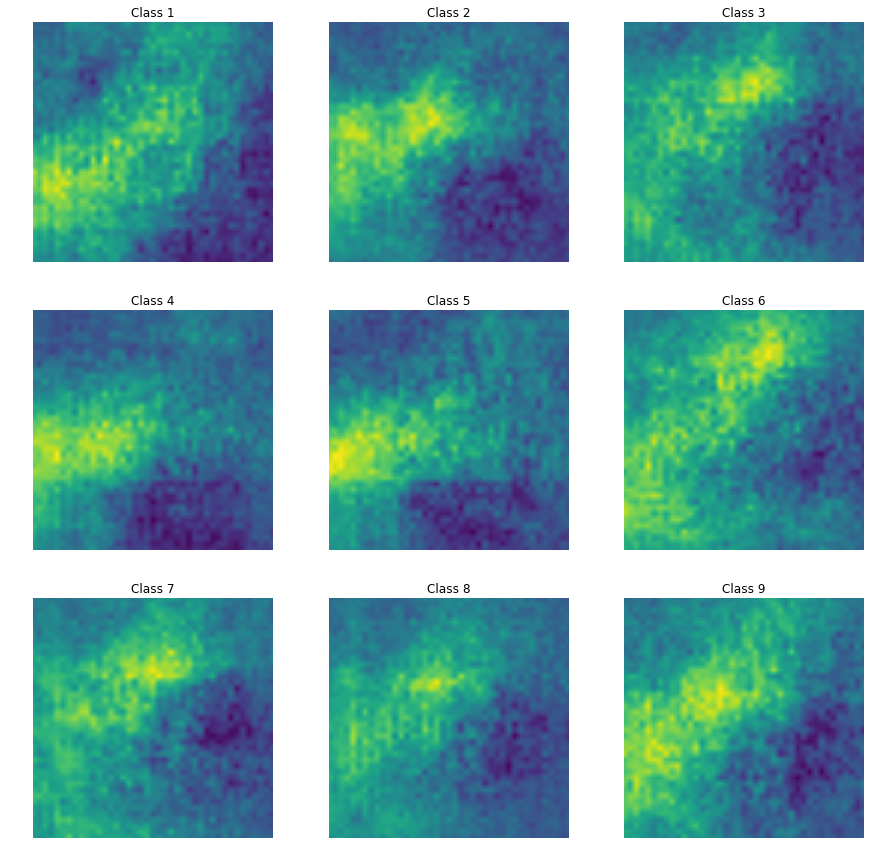

In [32]:
show_pics(output[0], 3, 3)